# Rossmann销售预测

## 问题描述

Rossmann在全欧洲有超过6000家药店，预测销售额一直是他们商店经理的工作，他们根据直觉来预测，
准确率有很大变化，现在我们要帮助构建一个销售额预测模型，针对位于德国的1115家店进行6周的销
售额预测，对于销售额的预测可以帮助经理们更合理的安排员工上班时间表、销售活动等。

## 问题链接

https://www.kaggle.com/c/rossmann-store-sales

## 基本流程

1. 开发环境初始化。
2. 加载数据。
3. 拼接数据。
4. 数据预处理。
5. 数据挖掘。
6. 特征工程。
7. 模型构建、训练、调参、融合到一个无法提升的地步。
8. 完善各步骤。
9. 生成kaggle的提交文件。
10. 记录kaggle得分情况。
11. 收获。
12. 引用。

## 环境初始化

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

## 准备数据

相关数据都存放于当前目录的/data/all中

In [2]:
!ls data/all

sample_submission.csv  store.csv  test.csv  train.csv


### 个别字段含义

    1. Id:测试集内(商店、日期)的组合。
    2. Store:表示每个商店的唯一Id。
    3. Sales:任意一天的销售额，也是我们要预测的字段。
    4. Open:是否开门，0=关门，1=开门。
    5. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
    6. StoreType:商店类型，有四种，abcd。
    7. Assortment:分类级别，a=基础，b=额外，c=扩展。
    8. CompetitionDistance:竞争对手距离。
    9. CompetitionOpenSince\[Month/Year\]:给出最近竞争对手的开张时间。
    10. Promo:表示商店当天是否进行促销？
    11. Promo2:表示商店是否进行持续的促销活动，0=没有参数，1=参与。
    12. Promo2Since\[Year/Week\]:商店开始持续促销的年/星期。
    13. PromoInterval:持续促销活动开始的间隔，"Feb,May,Aug,Nov"表示给定商店某一年的2589月开始持续促销活动。

### 读取数据

In [3]:
train_data = pd.read_csv('data/all/train.csv')
test_data = pd.read_csv('data/all/test.csv')
store_data = pd.read_csv('data/all/store.csv')

/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 字段数据类型转换

In [4]:
train_data.Date = pd.to_datetime(train_data.Date)
test_data.Date = pd.to_datetime(test_data.Date)
store_data['PromoInterval'] = store_data['PromoInterval'].astype(str)

### 浏览下数据

In [5]:
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_data.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,nan
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,nan


结论：

1. 可以看到train、test和store之间有一个Store字段是相同的，可以同于链接两张表。
2. train中的Store、DayOfWeek、Date、Open、Promo、StateHolidy、SchoolHoliday都不能直接使用，因为不是数值型。
3. store中除COmpetitionDistance外均不能直接使用。

能够看到有大量字段属于枚举型、时间序列，这些字段都要经过处理，否则会影响预测结果。

### 数据的统计值

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


可以看到，总共有1017209条数据，数据量不算很大，各字段都是完整的，无null字段，这是个好消息，对于train部分不需要做异常数据处理了。

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Open字段有11个NaN，这个直接用1，表示开门来填充即可。

In [10]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


对于Store数据来说，总共有1115条数据，对应分布于德国的1115间商店，而其中CompetitionOpenSinceMonth、CompetitionOpenSinceYear只有761条数据，也就是说有354个商店没有对应的竞争对手的开张日期字段，而Promo2SinceWeek、Promo2SinceYear、PromoInterval只有571条，也就是说有将近一半的商店是没有持续促销活动的，而还有3个商店没有竞争对手的距离。

In [11]:
store_data[store_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,nan
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,nan
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


可以看到有三家店是没有CompetitionDistance，不知道是没有竞争对手还是什么情况，不过既然只有3条，那么直接用平均值填充好了，本身想删掉的，但是考虑到store的信息要链接到train中，这里的3条数据对应train中可就是3\*N条了，因此不删了。

In [12]:
store_data[store_data['CompetitionOpenSinceMonth'].isnull()][:5]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,nan
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


看到对于CompetitionOpenSinceMonth、CompetitionOpenSinceYear的数据，并不是没有竞争对手，只是缺失了对手的开张日期而已，同时缺失了大概1/3的数据，不算很多，那么我们在后面将他们补全吧，补全方式使用其他数据该字段的平均值。

In [13]:
store_data[store_data['Promo2SinceWeek'].isnull()][:5]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,nan
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,nan
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,nan
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,nan


而对于Promo2SinceWeek、Promo2SinceYear、PromoInterval来说，它们并不是缺失，而是当Promo2为0，即没有持续的促销活动时，这三个字段都是NaN，这个是正常的，后面考虑下如何处理Promo2系的字段吧，毕竟缺失较多，或者可以将数据按照是否有Promo2划分开两部分，分别进行训练和预测，恩恩，感觉可以试试看。

## 数据预处理

### Open

In [14]:
test_data.Open.fillna(1, inplace=True)

### CompetitionOpenSinceMonth、CompetitionOpenSinceYear填充

使用该字段不为NaN的字段的数据的median填充，注意要取整。

In [15]:
store_data.CompetitionOpenSinceYear.fillna(store_data.CompetitionOpenSinceYear.median(), inplace=True)
store_data.CompetitionOpenSinceMonth.fillna(store_data.CompetitionOpenSinceMonth.median(), inplace=True)

### CompetitionDistance填充

直接使用该字段不为NaN的median填充。

In [16]:
store_data.CompetitionDistance.fillna(store_data.CompetitionDistance.median(), inplace=True)

## 数据拼接

### Train和Store的链接

根据Store字段将二者链接起来。

In [17]:
train_all = pd.merge(train_data, store_data)
train_all.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan


In [18]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 

### Test和Store的链接

同样也将Test和Store链接，方便后续对test进行预测时使用，后续对链接后的处理，同理都要应用到Test+Store的链接数据上。

In [19]:
test_all = pd.merge(test_data, store_data)

In [20]:
test_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                41088 non-null object
dtypes: datetime

### 促销信息缺失

In [21]:
train_all[train_all['Promo2']==0][:3]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan


可以看到这部分信息缺失是因为没有参与促销活动。

## 将数据按照日期排序

重要：由于后面需要将最近6周的数据抽取出来作为验证集数据，因此如果训练数据没有通过日期排序的话，会出现整个验证集数据都是Store为1的数据，那么我们根据其他商店的数据去预测Store为1的商店的预测，可想而知，肯定会出现验证集上早早的就无法降低RMSPE值的问题，因为训练的数据本身就不合理。

In [22]:
train_all = train_all.sort_values(['Date'],ascending = False)

In [23]:
train_all[:10] # 排序成功的话，这十条数据应该都是2015年7月31号的不同商店的数据才对吧，妈呀，坑死人了。。。。。。

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
679364,747,5,2015-07-31,10708,826,1,1,0,1,c,c,45740.0,8.0,2008.0,0,NaN,NaN,nan
702362,772,5,2015-07-31,5224,635,1,1,0,1,d,c,1850.0,8.0,2010.0,0,NaN,NaN,nan
683890,752,5,2015-07-31,7763,565,1,1,0,1,a,a,970.0,3.0,2013.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
17714,20,5,2015-07-31,9593,974,1,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
273422,302,5,2015-07-31,5356,393,1,1,0,1,d,c,2190.0,12.0,2007.0,1,9.0,2011.0,"Mar,Jun,Sept,Dec"
978933,1074,5,2015-07-31,6789,681,1,1,0,1,c,c,3330.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
84088,93,5,2015-07-31,6548,715,1,1,0,1,a,a,16690.0,8.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
660134,726,5,2015-07-31,13962,1192,1,1,0,1,a,c,40540.0,2.0,2002.0,0,NaN,NaN,nan
713298,784,5,2015-07-31,9284,921,1,1,0,1,a,a,560.0,10.0,2014.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"


## 数据挖掘：日期信息、促销信息、竞争对手信息

### 日期信息：提取年、月、日、WeekOfYear（对应Promo2SinceWeek）、是否工作日

对于时间字段，最早我的做法是将其当做枚举来处理，这么做有两个问题：
1. 枚举量很大，影响后续PCA等的效果，实际上如果特征数量有限就不需要PCA了，毕竟PCA算是牺牲了一部分数据表现。
2. 训练数据和测试数据在枚举变量One-Hot后不能对齐。
3. 没有真正对日期信息进行深度的挖掘。

最重要的是时间序列字段对于预测的影响应该是很大的，因为商店的销售应该是具有季节性、日期特殊性的，比如节假日、季节等，因此，通过已有信息挖掘这部分信息出来作为新特征，然后抛弃原有的较原始的信息对于我们的模型来说帮助更大。

提取字段：
1. Year。
2. Quarter。
3. Month。
4. Day。
5. WeekOfYear。
6. IsWorkDay。

In [24]:
def get_datetime_info(data):
    '''
    data:dataFrame
    return year,quarter,month,day,weekOfYear,isWorkDay
    '''
    return (data.Date.apply(lambda date:date.year), 
            data.Date.apply(lambda date:date.quarter), 
            data.Date.apply(lambda date:date.month), 
            data.Date.apply(lambda date:date.day), 
            data.Date.apply(lambda date:date.weekofyear), 
            data.DayOfWeek.apply(lambda dow:dow<=6)) # 周日不上班

In [25]:
get_datetime_info(train_all[:1])

(0    2015
 Name: Date, dtype: int64, 0    3
 Name: Date, dtype: int64, 0    7
 Name: Date, dtype: int64, 0    31
 Name: Date, dtype: int64, 0    31
 Name: Date, dtype: int64, 0    True
 Name: DayOfWeek, dtype: bool)

#### 可视化分析时间字段相对于销售额的影响

In [26]:
train_data.Date.min()

Timestamp('2013-01-01 00:00:00')

In [27]:
train_data.Date.max()

Timestamp('2015-07-31 00:00:00')

In [28]:
train_data.Date.unique()[:10]

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000'], dtype='datetime64[ns]')

日期是连续的，这有助于我们计算一些统计信息。

In [29]:
print '学校放假平均销售额：'+str(train_data[train_data['SchoolHoliday'] == 1].Sales.mean())
print '学校不放假平均销售额：'+str(train_data[train_data['SchoolHoliday'] == 0].Sales.mean())

学校放假平均销售额：6476.52220712
学校不放假平均销售额：5620.97903381


In [30]:
print '国家放假平均销售额：'+str(train_data[train_data['StateHoliday'] != 0].Sales.mean())
print '国家不放假平均销售额：'+str(train_data[train_data['StateHoliday'] == 0].Sales.mean())

国家放假平均销售额：5779.7781799
国家不放假平均销售额：5733.53062439


可以看到仅仅是是否放假，对销售额的影响不大，下面我们看看放假期间的销售额变化。

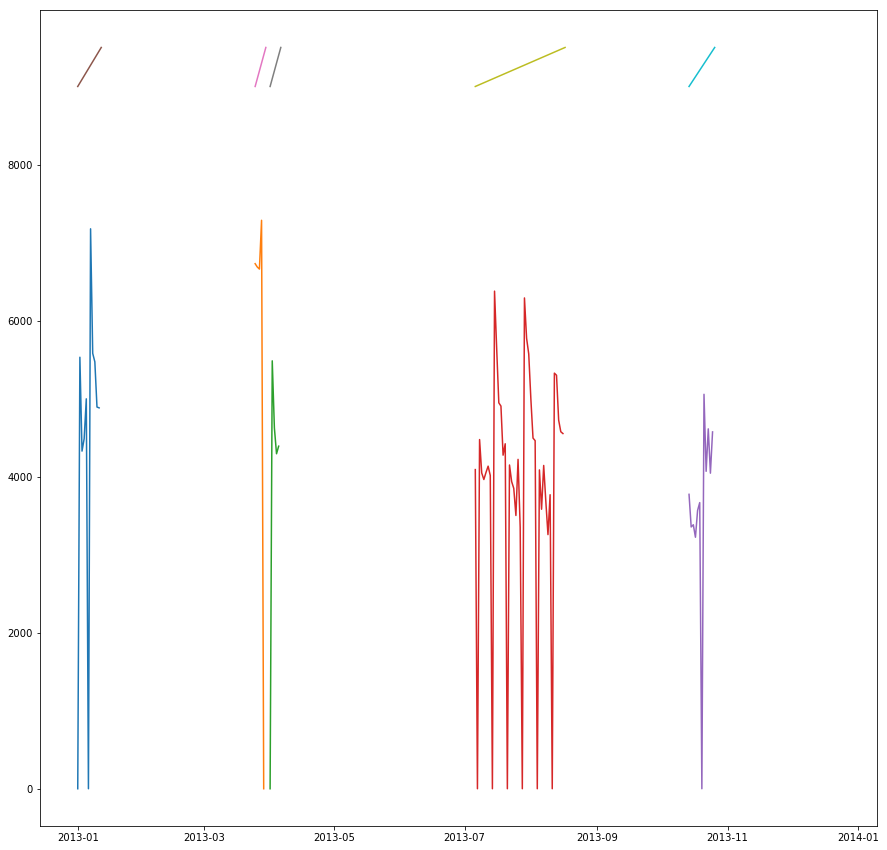

In [31]:
X=[]
Y=[]
X_=[]
Y_=[]
train_data_store1 = train_all[train_all.Store==1][::-1].reset_index()
train_data_store1 = train_data_store1[:360]
holiday_start = False
holiday_end = False
x_temp = []
y_temp = []
plt.figure(figsize=(15,15))
for i in range(len(train_data_store1)):
    d = train_data_store1.loc[i]
    if d.SchoolHoliday==1 and (i==0 or train_data_store1.loc[i-1].SchoolHoliday==0):
        X.append(d.Date)
        Y.append(9000)
        holiday_start = True
        holiday_end = False
        x_temp = []
        y_temp = []
    if d.SchoolHoliday==0 and (i==len(train_data_store1)-1 or train_data_store1.loc[i-1].SchoolHoliday==1):
        X.append(d.Date)
        Y.append(9500)
        holiday_end = True
        holiday_start = False
    if holiday_start and not holiday_end:
        x_temp.append(d.Date)
        y_temp.append(d.Sales)
    if holiday_end and not holiday_start:
        X_.append(x_temp)
        Y_.append(y_temp)
        holiday_end = False

for i in range(len(X_)):
    plt.plot(X_[i], Y_[i])
for i in range(0, min(len(X), len(Y)), 2):
    plt.plot(X[i:i+2], Y[i:i+2])
        

假期的销售额幅度不明显，看来假期对销售额的影响应该不大，至少不是主要的因素。

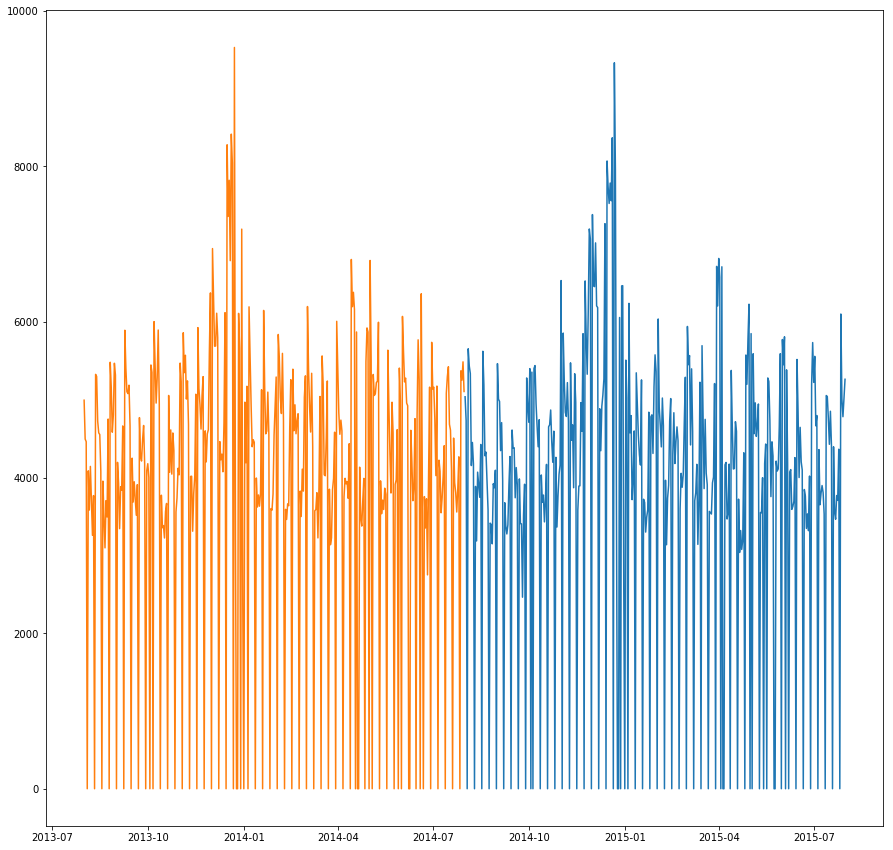

In [32]:
plt.figure(figsize=(15,15))
plt.plot(train_all[train_all.Store==1].Date[:365], train_all[train_all.Store==1].Sales[:365])
plt.plot(train_all[train_all.Store==1].Date[365:365+365], train_all[train_all.Store==1].Sales[365:365+365])

上述图很重要，分别表示了相邻的两年的销售额走势图，我们可以发现，大体上是一致的，这说明一个问题，销售额跟日期息息相关的，也就是说每一年的同一段时期内，可能销售额都会很接近，这就有点像很多行业有他的季节性特点的感觉，这一信息说明具体的日期对预测是至关重要的，因此我们需要提取出具体的年、月、日信息。

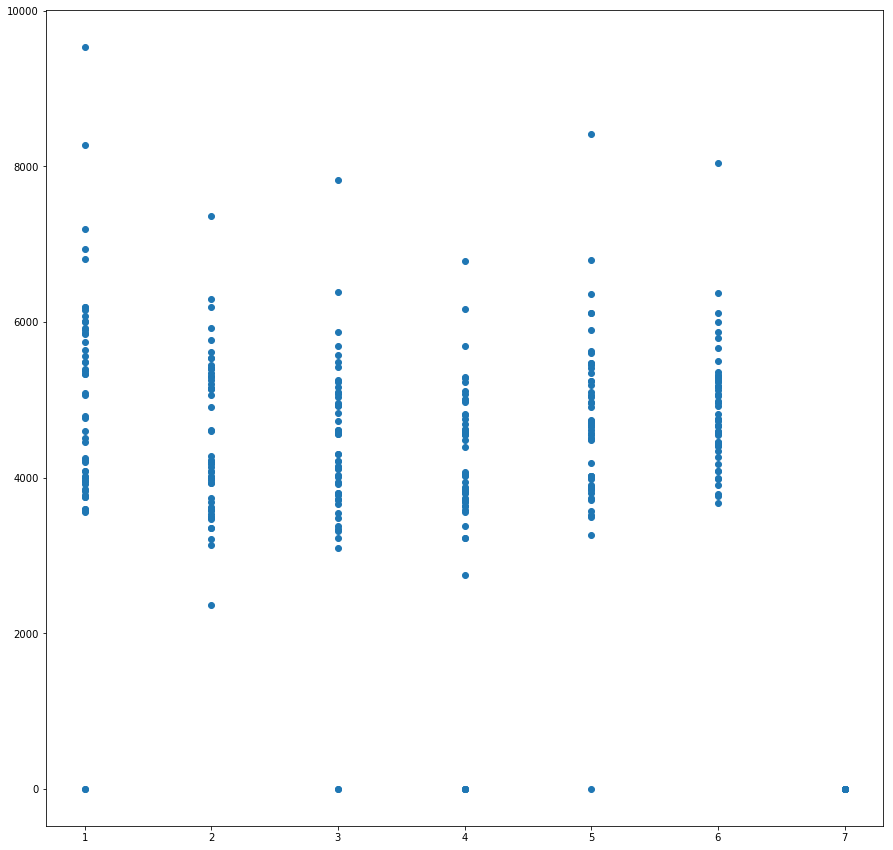

In [33]:
plt.figure(figsize=(15,15))
plt.scatter(train_data[train_data.Store==1].DayOfWeek[365:365+365], train_data[train_data.Store==1].Sales[365:365+365])

In [34]:
print '1~5平均销售额：'+str(train_data[train_data['DayOfWeek'] <=5].Sales.mean())
print '6平均销售额：'+str(train_data[train_data['DayOfWeek'] ==6].Sales.mean())
print '7平均销售额：'+str(train_data[train_data['DayOfWeek'] ==7].Sales.mean())

1~5平均销售额：6866.80635082
6平均销售额：5847.56259932
7平均销售额：204.183189387


可以看到相比于周六，周日对销售额的影响是巨大的，主要是因为很多商店这一天都关门吧。

分析一下每一天跟前一个星期、月、季度、半年、一年时间的平均销售额的对比。

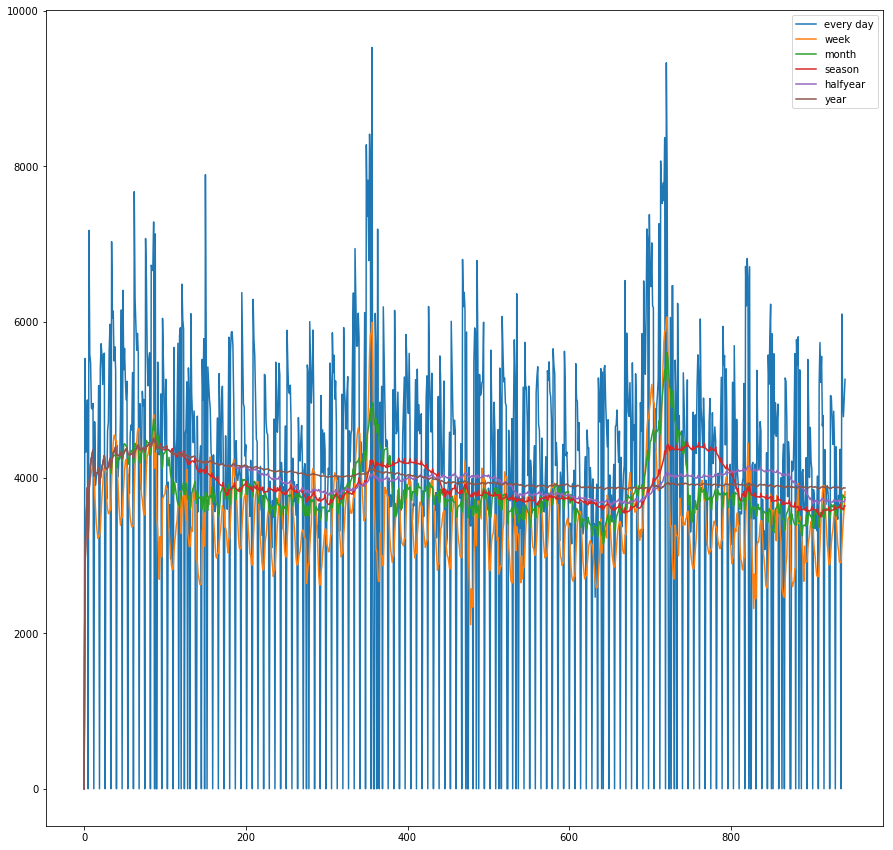

In [35]:
def get_week_month_season_halfyear_year(train_data_store):
    every_day = train_data_store1.Sales
    last_weeks = []
    last_months = []
    last_seasons = []
    last_halfyears = []
    last_years = []
    for i in range(len(every_day)):
        # week
        sales=0
        count=1
        for j in range(i, i-7 if i-7>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_weeks.append(sales/count)
        # month
        sales=0
        count=1
        for j in range(i, i-30 if i-30>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_months.append(sales/count)
        # season
        sales=0
        count=1
        for j in range(i, i-90 if i-90>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_seasons.append(sales/count)
        # halfyear
        sales=0
        count=1
        for j in range(i, i-180 if i-180>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_halfyears.append(sales/count)
        # year
        sales=0
        count=1
        for j in range(i, i-360 if i-360>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_years.append(sales/count)
    return every_day, last_weeks, last_months, last_seasons, last_halfyears, last_years

train_data_store1 = train_all[train_all['Store']==1][::-1].reset_index()
every_day, last_weeks, last_months, last_seasons, last_halfyears, last_years = get_week_month_season_halfyear_year(train_data_store1)
plt.figure(figsize=(15,15))
plt.plot(every_day, label='every day')
plt.plot(last_weeks, label='week')
plt.plot(last_months, label='month')
plt.plot(last_seasons, label='season')
plt.plot(last_halfyears, label='halfyear')
plt.plot(last_years, label='year')
plt.legend()
plt.show()

可以看到趋势方面最接近的应该是week，下面用相关系数确认以下。

In [36]:
pd.DataFrame([last_weeks, last_months, last_seasons, last_halfyears, last_years, 
              list(train_data_store1.Customers)]).corrwith(pd.Series(every_day), axis=1)

0    0.265649
1    0.256849
2    0.124013
3    0.098703
4    0.105531
5    0.984341
dtype: float64

可以看到，就相关性来看，最高的有0.26，也不算很高，暂时不考虑。

### 持续促销活动相关信息挖掘：PromoIntervel、Promo2SinceWeek、Promo2SinceYear

可以开发两个字段：
1. IsInPromo:分别表示当前店铺某天是否处于持续的促销活动中：根据Date、Promo2以及PromoIntervel。
2. PromoDays:促销活动已经持续的时间：根据Date以及Promo2SinceYear、Promo2SinceWeek。

In [37]:
def is_in_promo(data):
    '''
    data:DataFrame。
    return:返回bool值的Seris表示当前是否处于活动中。
    '''
    months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return data.apply(lambda d:False if d.Promo2==0 else (months_str[int(d.Month-1)] in d.PromoInterval), axis=1)

In [38]:
def get_promo_days(data):
    '''
    return:返回活动已经持续的天数的Series。
    '''
    return data.apply(lambda d:0 if not d.IsInPromo else d.Day, axis=1)

### 竞争对手信息挖掘：CompetitionOpenSinceYear、CompetitionOpenSinceMonth

按照一般的理解上，竞争对手也应该对店铺的销售有很大影响，毕竟同一地区的市场份额是固定的，有一个距离比较近、开张比较久（老字号？）的竞争对手对销售额还是有压力的吧，分析以下。

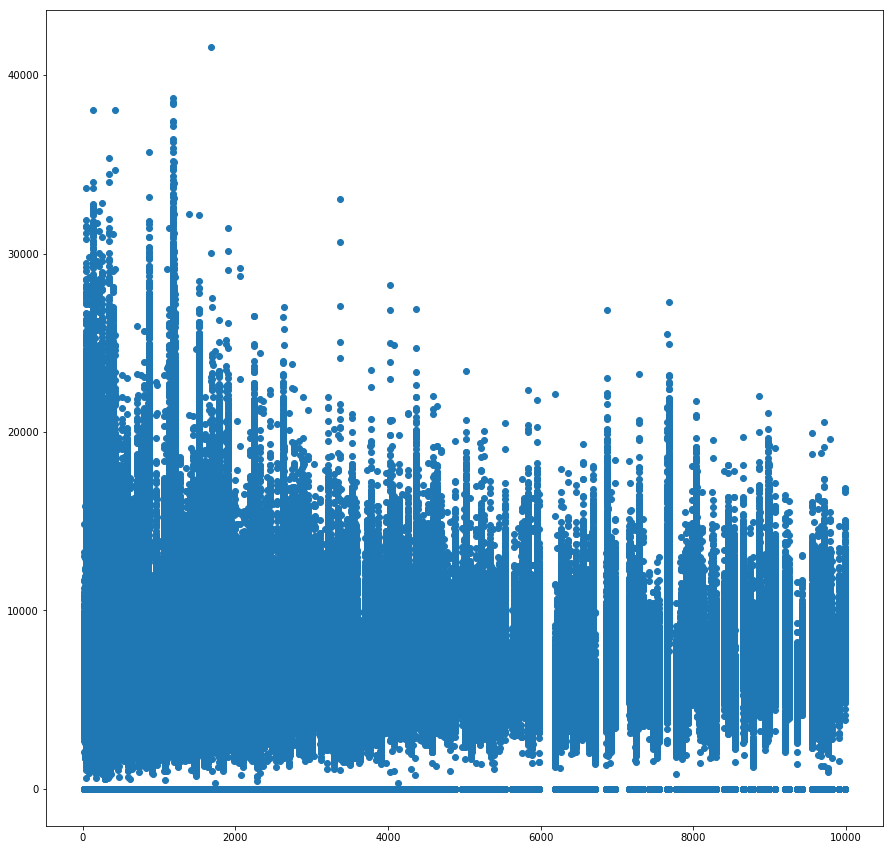

In [39]:
plt.figure(figsize=(15,15))
plt.scatter(train_all[train_all['CompetitionDistance']<10000].CompetitionDistance, train_all[train_all['CompetitionDistance']<10000].Sales)

可以看到一个奇怪的现象，似乎与我们的预计不符，并不是竞争对手越远，销售额越高，反而有点相反的意思，这个可能是类似商业圈的特点导致的吧，比如这一代有好几家同样的店，那么大家买这类商品时是不是都倾向于去这些地方买呢，那么就有一种互相促进的感觉，这一点是很有意思的点。

下面再看看跟竞争对手开张时间的关系。

增加字段：
1. CompetitionOpenMonths。

In [40]:
def get_competition_openmonths(data):
    '''
    return:返回截止当前竞争对手的开张时间，月为单位。
    '''
    return data.apply(lambda d:(d.Year-d.CompetitionOpenSinceYear)*12+(d.Month-d.CompetitionOpenSinceMonth), axis=1)

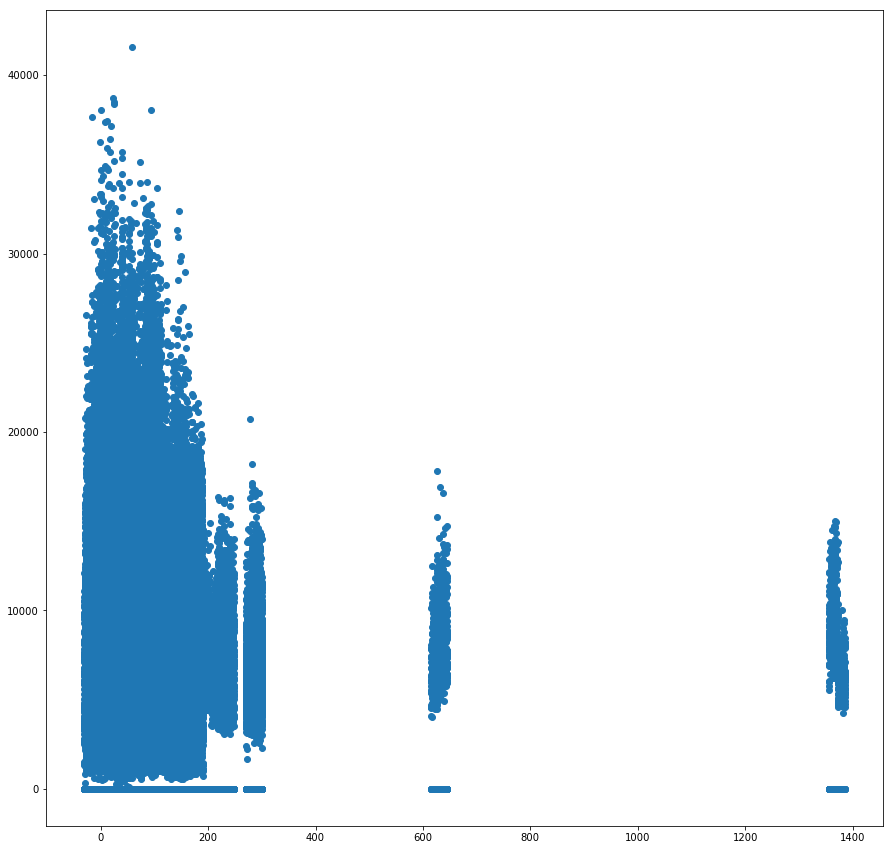

In [41]:
months = train_all.apply(lambda data:(data.Date.year - data.CompetitionOpenSinceYear)*12+(data.Date.month - data.CompetitionOpenSinceMonth), axis=1)
plt.figure(figsize=(15,15))
plt.scatter(months, train_all.Sales)

可以看到，这张图很明显的看到，当对手开张时间比较短时，店铺的销售额比较大，也就是在同一个区域更加受客户欢迎，这个是跟我们的认知一致的信息。

## 特征工程

### 挖掘到的新字段添加

#### Year、Quarter、Month、Day、WeekOfYear、IsWorkDay

In [42]:
train_all['Year'], train_all['Quarter'], train_all['Month'], train_all['Day'], train_all['WeekOfYear'], train_all['IsWorkDay'] = get_datetime_info(train_all)

In [43]:
test_all['Year'], test_all['Quarter'], test_all['Month'], test_all['Day'], test_all['WeekOfYear'], test_all['IsWorkDay'] = get_datetime_info(test_all)

Tips:如果使用train_all.Year增加列，而不是train_all\['Year'\]，后续虽然这个Year可以点出来使用，但是在columns列列表中不存在会有一些问题哦！！！

#### 可视化

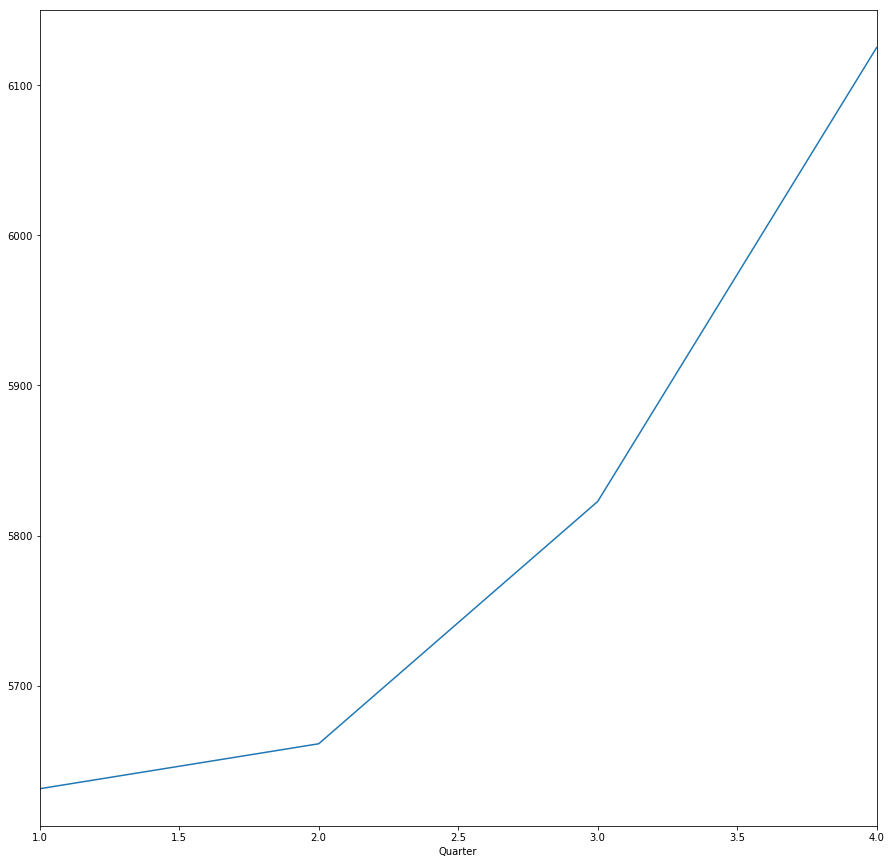

In [44]:
plt.figure(figsize=(15,15))
train_all.groupby(['Quarter']).Sales.mean().plot()

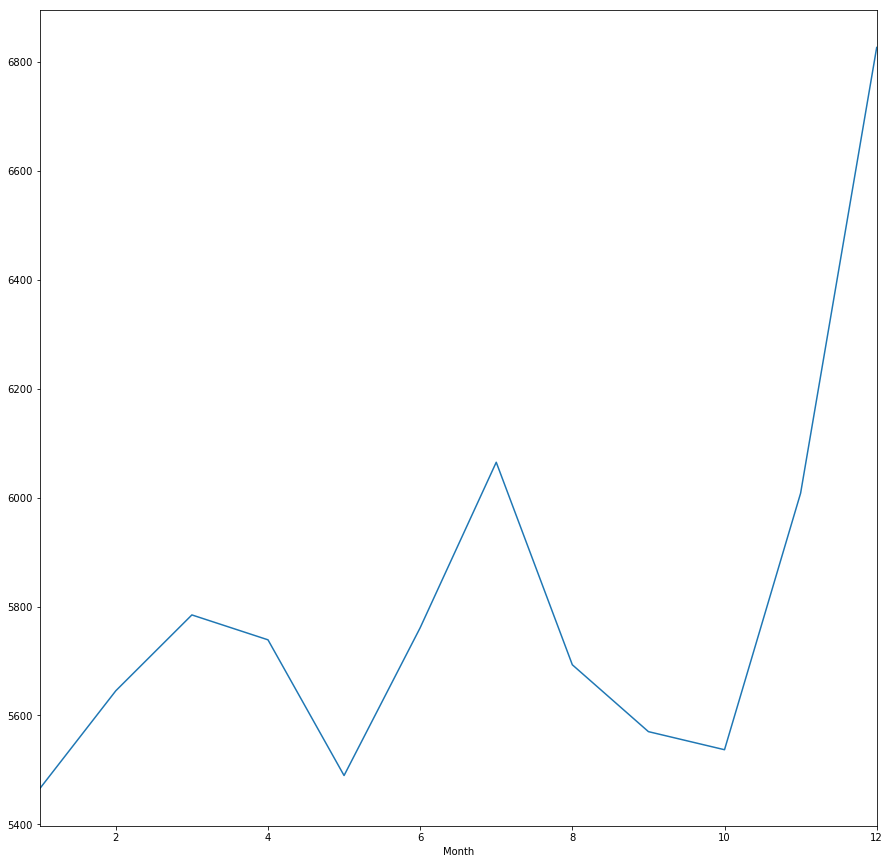

In [45]:
plt.figure(figsize=(15,15))
train_all.groupby(['Month']).Sales.mean().plot()

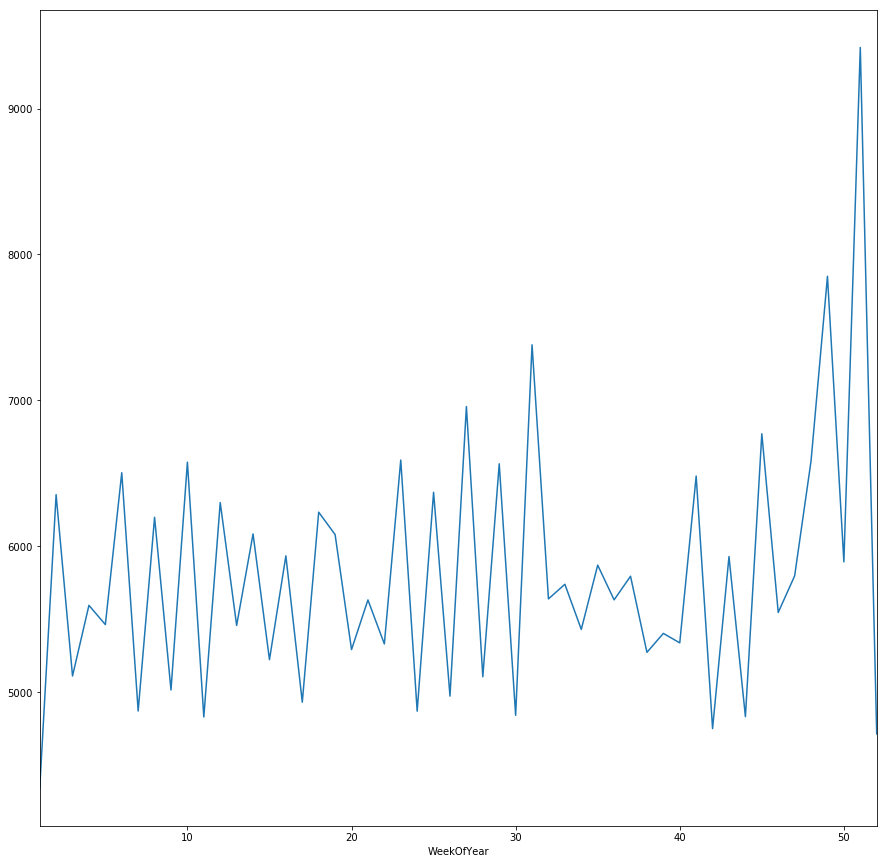

In [46]:
plt.figure(figsize=(15,15))
train_all.groupby(['WeekOfYear']).Sales.mean().plot()

#### IsInPromo、PromoDays

In [47]:
train_all['IsInPromo'] = is_in_promo(train_all)
train_all.IsInPromo.unique()

array([False,  True], dtype=bool)

In [48]:
test_all['IsInPromo'] = is_in_promo(test_all)

In [49]:
train_all['PromoDays'] = get_promo_days(train_all)
train_all.PromoDays.unique()

array([ 0, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [50]:
test_all['PromoDays'] = get_promo_days(test_all)

#### 可视化

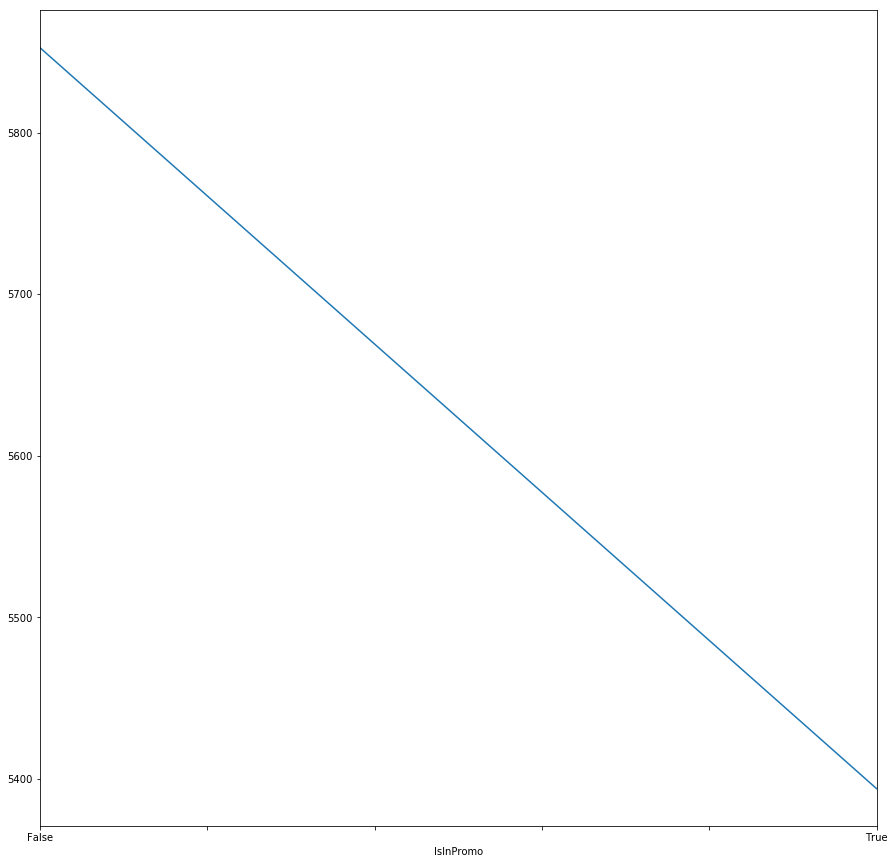

In [51]:
plt.figure(figsize=(15,15))
train_all.groupby(['IsInPromo']).Sales.mean().plot()

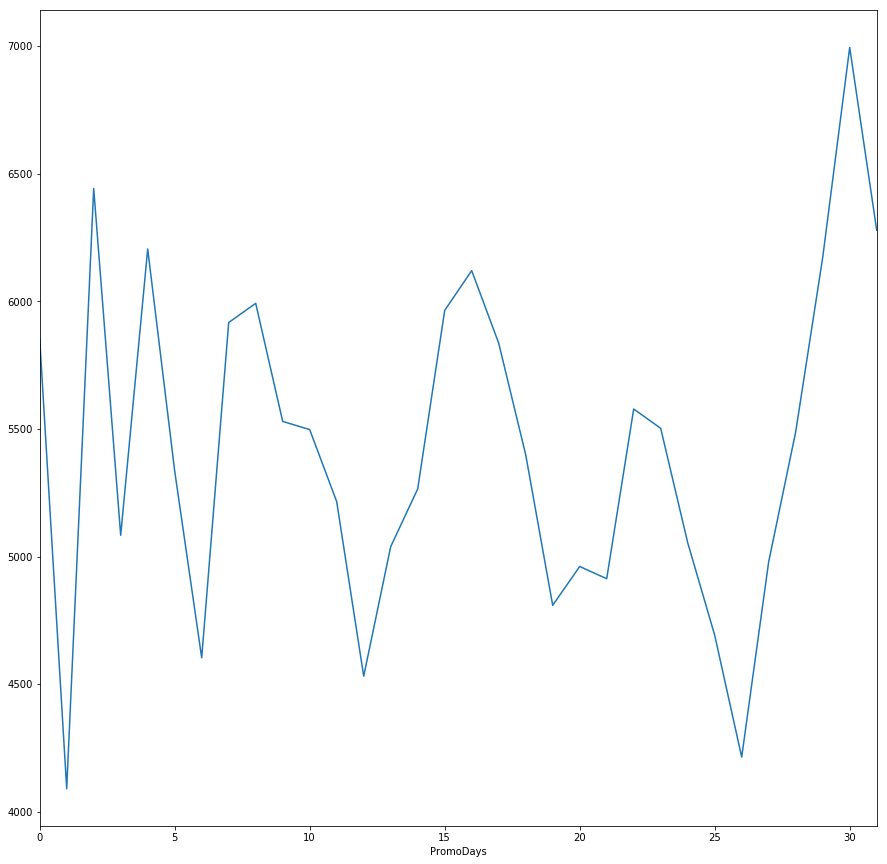

In [52]:
plt.figure(figsize=(15,15))
train_all.groupby(['PromoDays']).Sales.mean().plot()

上述表示，促销对销售额的影响是非常明显的，但是持续时间同样存在着影响。

#### CompetitionOpenMonths

In [53]:
train_all['CompetitionOpenMonths'] = get_competition_openmonths(train_all)
train_all.CompetitionOpenMonths.unique()[:10]

array([  82.,   83.,   59.,   28.,   74.,   91.,  165.,  161.,    9.,  117.])

In [54]:
test_all['CompetitionOpenMonths'] = get_competition_openmonths(test_all)

### 无用字段丢弃，注意test.csv是没有Customers数据的哈

Date、Promo2SinceWeek、Promo2SinceYear、PromoInterval、CompetitionOpenSinceMonth、CompetitionOpenSinceYear、Store

In [55]:
drop_cols = ['Date', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 
             'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Store']
train_all.drop(drop_cols+['Customers'], axis=1, inplace=True)
test_all.drop(drop_cols, axis=1, inplace=True)

### 当前字段

In [56]:
train_all.columns

Index([u'DayOfWeek', u'Sales', u'Open', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'Promo2', u'Year', u'Quarter', u'Month', u'Day', u'WeekOfYear',
       u'IsWorkDay', u'IsInPromo', u'PromoDays', u'CompetitionOpenMonths'],
      dtype='object')

In [57]:
test_all.columns

Index([u'Id', u'DayOfWeek', u'Open', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'Promo2', u'Year', u'Quarter', u'Month', u'Day', u'WeekOfYear',
       u'IsWorkDay', u'IsInPromo', u'PromoDays', u'CompetitionOpenMonths'],
      dtype='object')

### 枚举字段One-Hot编码

当前的枚举字段有：
1. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
2. StoreType:商店类型，有四种，abcd。
3. Assortment:分类级别，a=基础，b=额外，c=扩展。

在模型中应该是类似节点一样的存在，即作为四个节点将数据导向四个方向，因此将a、b、c、d都映射到1,2,3,4上，不使用OneHot编码，毕竟编码后的维度会增加。

In [58]:
# train_all.head(3)
# train_all = pd.get_dummies(train_all, columns=['StateHoliday', 'StoreType', 'Assortment'])
# train_all.info()
# test_all = pd.get_dummies(test_all, columns=['StateHoliday', 'StoreType', 'Assortment'])
# test_all.info()

In [59]:
code_map = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, '0':0, 
           1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 0:0}
train_all.StateHoliday = train_all.StateHoliday.map(code_map)
train_all.StoreType = train_all.StoreType.map(code_map)
train_all.Assortment = train_all.Assortment.map(code_map)

test_all.StateHoliday = test_all.StateHoliday.map(code_map)
test_all.StoreType = test_all.StoreType.map(code_map)
test_all.Assortment = test_all.Assortment.map(code_map)

print train_all.StateHoliday.unique()
print test_all.Assortment.unique()

[0 1 2 3]
[1 3 2]


## 数值型数据归一化处理

这主要是避免由数值大小导致的字段在对预测结果的影响中权重不一致，因此做归一化处理，即认为每个字段的影响都是一样的。

数值型字段有：
1. Sales：预测值不用管。
2. CompetitionDistance。
3. PromoDays。
4. CompetitionOpenMonths。

但是有个问题，如果对训练数据、测试数据分别进行了归一化，因为归一化使用的min、max不同，是否对预测有影响不可而知，暂时不进行归一化处理。

### 做归一化之前，我们要先查看下数据中是否有异常值，比如极大极小值等，避免对归一化结果造成影响

In [60]:
#plt.figure(figsize=(15,15))
#plt.plot(train_all.CompetitionDistance)

In [61]:
print 'min:'+str(train_all.CompetitionDistance.min())

min:20.0


In [62]:
print 'max:'+str(train_all.CompetitionDistance.max())

max:75860.0


恩恩，也没啥问题，不过这个min为20，这个不会是楼上楼下的关系吧，真的不会打起来么。。。。

### 进行归一化

归一化就使用简单的min-max归一化（是否需要看下数值的分布再决定呢，不是有个归一化算法可以减少值间距导致的差异么），因为现在所有字段都可以理解为数值型，因此直接应用到整个DataFrame上也是可以的，不过为了速度就不这么做了。

In [63]:
# train_all.CompetitionDistance = ((train_all.CompetitionDistance - train_all.CompetitionDistance.min())/(train_all.CompetitionDistance.max() - train_all.CompetitionDistance.min()))
# test_all.CompetitionDistance = ((test_all.CompetitionDistance - test_all.CompetitionDistance.min())/(test_all.CompetitionDistance.max() - test_all.CompetitionDistance.min()))
# print 'min:'+str(train_all.CompetitionDistance.min())
# print 'max:'+str(train_all.CompetitionDistance.max())
# print 'mean:'+str(train_all.CompetitionDistance.mean())

## 将目标字段提取出来

In [64]:
target_all = train_all.Sales
target_all.head(5)

0          5263
679364    10708
702362     5224
683890     7763
17714      9593
Name: Sales, dtype: int64

In [65]:
train_all = train_all.drop('Sales', axis=1)
print 'Sales' in train_all.columns

False


可以看到，Sales已经不在训练数据中了。

## 数据集划分

避免每一次模型验证都要上传到kaggle，因此将训练数据划分为训练集和验证集，比例9:1，这样方便自己调试模型，因为最终测试集上是预测6周的数据，因此我们也拿最近的6周出来做验证集数据，由于时间序列是连续的，而销售额又是跟日期强相关的，因此不适用随机划分。

In [160]:
#from sklearn.cross_validation import train_test_split

#x_train, x_valid, y_train, y_valid = train_test_split(train_all, target_all, test_size=0.1)

x_valid = train_all[:1115*6*7]
x_train = train_all[1115*6*7:]
x_all = train_all[:]
y_valid = target_all[:1115*6*7]
y_train = target_all[1115*6*7:]
y_all = target_all[:]

# y做对数处理
y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)
y_all = np.log1p(y_all)

In [67]:
x_train[:5]

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Quarter,Month,Day,WeekOfYear,IsWorkDay,IsInPromo,PromoDays,CompetitionOpenMonths
284584,5,1,1,0,0,1,1,3560.0,1,2015,2,6,19,25,True,False,0,164.0
417104,5,1,1,0,0,3,1,3390.0,0,2015,2,6,19,25,True,False,0,58.0
875290,5,1,1,0,0,4,3,9430.0,0,2015,2,6,19,25,True,False,0,58.0
119580,5,1,1,0,0,4,3,1040.0,1,2015,2,6,19,25,True,False,0,58.0
807974,5,1,1,0,0,4,1,19700.0,1,2015,2,6,19,25,True,False,0,58.0


In [68]:
x_valid[:5]

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Quarter,Month,Day,WeekOfYear,IsWorkDay,IsInPromo,PromoDays,CompetitionOpenMonths
0,5,1,1,0,1,3,1,1270.0,0,2015,3,7,31,31,True,False,0,82.0
679364,5,1,1,0,1,3,3,45740.0,0,2015,3,7,31,31,True,False,0,83.0
702362,5,1,1,0,1,4,3,1850.0,0,2015,3,7,31,31,True,False,0,59.0
683890,5,1,1,0,1,1,1,970.0,1,2015,3,7,31,31,True,False,0,28.0
17714,5,1,1,0,0,4,1,2340.0,1,2015,3,7,31,31,True,True,31,74.0


## 基准模型

基准模型采用恒定猜测为mean值的方式。

先将训练集中Sales的mean值计算出来。

In [69]:
pred_base = np.expm1(y_train).mean()
print '基准模型预测值：'+str(pred_base)

基准模型预测值：5762.7660172


## 性能指标

由于是要提交到kaggle，因此我们选择和kaggle一致的性能指标，即RMSPE。

In [70]:
def rmspe(y_pred, y_real):
    y_pred = list(y_pred)
    y_real = list(y_real)
    for i in range(len(y_real)):
        if y_real[i]==0:
            y_real[i], y_pred[i] = 1., 1.
    return np.sqrt(np.mean((np.divide(np.subtract(y_real, y_pred),y_real))**2))

跟RMSE不同的是引入了/y_i的处理，这样就不会忽略销量很低的情况了。

## 计算基准模型的性能

In [71]:
print '基准模型的RMSPE：'+str(rmspe([pred_base]*len(y_valid), np.expm1(y_valid)))

基准模型的RMSPE：0.424544500713


可以看到是一个很高的误差率了，就是不知道跟我们的模型比较如何。

## 主流程

接下来就是我们的模型相关的流程，之前的数据处理、基准模型构建、基准阈值计算、性能指标函数构建已经完成了，后续主要就是PCA以及模型构建、比较、调试的迭代过程了。

模型选择：本来是选择Adaboost，看中它在小数据集上的表现，但是开题报告的审阅导师推荐了xGBoost，去了解了一下，发现如何区别：
1. adaboost：在优化弱分类器时，依赖的是权重的设置，即加大分类错误的数据的权重，而减小分类正确的数据的权重，使得后续的分类器更关注之前分类错误的点。
2. GBDT：相比较adaboost，区别在于它是通过算梯度来定位模型的不足，因此相比较AdaBoost，它能使用更多的目标函数，比如我们的性能指标函数RMSPE。

而XGBoost是在GBDT的基础上的全方位加强版，具体表现在支持线性分类器、加入了正则项控制模型复杂度、学习速率、速度更快，支持并行等，因此我们的模型优先选择**XGBoost**。

### PCA

进行PCA的目的：
1. 去除数据噪音。
2. 降维，我们的维度高达1000+，以当前数据是不可能描述这么多维度的。
3. 更加了解数据，很多字段我们根本不知道跟目标的关系是什么，pca可以帮助我们梳理这一关系。

第一版的时候由于维度非常多，因此我采用了PCA，主要用于降维，以及特征提取，第二版由于去掉了大部分OneHot部分，因此维度并不是很高，先去掉PCA，毕竟PCA对信息是有损失的。

    from sklearn.decomposition import PCA

    pca = PCA(n_components=10).fit(x_train)
    print pca.explained_variance_ratio_
    print sum(pca.explained_variance_ratio_)

可以看到，效果并不是很理想，前10个新特征总共表现了原来50%的变化，不过也比原来好了很多，先用这个看看。

    x_train_pca = pd.DataFrame(pca.transform(x_train))
    x_valid_pca = pd.DataFrame(pca.transform(x_valid))
    x_train_pca.info()

### 模型构建

导入库、训练数据处理

In [72]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [73]:
train_matrix = xgb.DMatrix(x_train, y_train)
valid_matrix = xgb.DMatrix(x_valid, y_valid)
watchlist = [(train_matrix, 'train'), (valid_matrix, 'valid')]

### 模型训练

#### 第一版模型训练

xgboost基本调参方式：
1. 选择一个较大的学习率，一般在0.05到0.3，此处我们直接选择0.3，然后设置一个该学习率对应下合适的n_estimators。
2. 调参max_depth、min_child_weight，这两个参数对结果影响很大。
3. 调参subsample、colsample_bytree。
4. 调参gamma。
5. 降低learning_rate，再匹配一个合适的n_estimators。

初版参数

In [74]:
ps_first = {
    'max_depth':5,
    'learning_rate':.3,
    'n_estimators':5000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':0,
    'min_child_weight':1,
    'subsample':1,
    'colsample_bytree':1,
    'random_state':6,
    'silent':True,
}

params_first = {
    "objective": "reg:linear",
    "booster" : "gbtree",
    "eta": 0.1,
    "max_depth": 5,
    "silent": 1,
    "seed": 6}
num_boost_round_first = 1000

In [76]:
def train(params, num_boost_round):
    print 'XGBoost Model Train Start....'
    start_time = time.time()
    model = xgb.train(params, train_matrix, num_boost_round, evals=watchlist, early_stopping_rounds=100)
    print 'XGBoost Model Train End, Time: {:4f} s....'.format(time.time()-start_time)
    return model

def train2(ps, x, y, x_test, y_test):
    print 'XGBRegressor Train Start....'
    start_time = time.time()
    model = XGBRegressor(max_depth=ps['max_depth'], learning_rate=ps['learning_rate'], 
                         n_estimators=ps['n_estimators'],objective=ps['objective'], silent=ps['silent'],
                         booster=ps['booster'], gamma=ps['gamma'], min_child_weight=ps['min_child_weight'],
                         subsample=ps['subsample'], colsample_bytree=ps['colsample_bytree'],
                        random_state=ps['random_state'])
    model.fit(x, y, early_stopping_rounds=100, eval_set=[(x_test,y_test)], verbose=True)
    print 'XGBRegressor Train End, Time: {:4f} s....'.format(time.time()-start_time)
    return model

In [77]:
#model_first = train(params_first, num_boost_round_first)
model_first = train2(ps_first, x_train, y_train, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:5.38756
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.78881
[2]	validation_0-rmse:2.67033
[3]	validation_0-rmse:1.88928
[4]	validation_0-rmse:1.3471
[5]	validation_0-rmse:0.976553
[6]	validation_0-rmse:0.72651
[7]	validation_0-rmse:0.56092
[8]	validation_0-rmse:0.455826
[9]	validation_0-rmse:0.390031
[10]	validation_0-rmse:0.346425
[11]	validation_0-rmse:0.328759
[12]	validation_0-rmse:0.316614
[13]	validation_0-rmse:0.312768
[14]	validation_0-rmse:0.310043
[15]	validation_0-rmse:0.309222
[16]	validation_0-rmse:0.306753
[17]	validation_0-rmse:0.305289
[18]	validation_0-rmse:0.305713
[19]	validation_0-rmse:0.303994
[20]	validation_0-rmse:0.304124
[21]	validation_0-rmse:0.303112
[22]	validation_0-rmse:0.301355
[23]	validation_0-rmse:0.300636
[24]	validation_0-rmse:0.299543
[25]	validation_0-rmse:0.299595
[26]	validation_0-rmse:0.298679
[27]	validation_0-rmse:0.297124
[28]	validation_0-rmse:0.29

[250]	validation_0-rmse:0.194785
[251]	validation_0-rmse:0.194729
[252]	validation_0-rmse:0.194568
[253]	validation_0-rmse:0.194612
[254]	validation_0-rmse:0.194619
[255]	validation_0-rmse:0.194529
[256]	validation_0-rmse:0.19441
[257]	validation_0-rmse:0.194294
[258]	validation_0-rmse:0.194139
[259]	validation_0-rmse:0.194021
[260]	validation_0-rmse:0.193862
[261]	validation_0-rmse:0.193815
[262]	validation_0-rmse:0.193754
[263]	validation_0-rmse:0.193765
[264]	validation_0-rmse:0.193596
[265]	validation_0-rmse:0.193542
[266]	validation_0-rmse:0.193381
[267]	validation_0-rmse:0.193449
[268]	validation_0-rmse:0.193442
[269]	validation_0-rmse:0.193437
[270]	validation_0-rmse:0.192995
[271]	validation_0-rmse:0.192778
[272]	validation_0-rmse:0.192422
[273]	validation_0-rmse:0.191876
[274]	validation_0-rmse:0.19174
[275]	validation_0-rmse:0.191645
[276]	validation_0-rmse:0.19147
[277]	validation_0-rmse:0.19132
[278]	validation_0-rmse:0.191196
[279]	validation_0-rmse:0.191009
[280]	validati

[499]	validation_0-rmse:0.174974
[500]	validation_0-rmse:0.174923
[501]	validation_0-rmse:0.174944
[502]	validation_0-rmse:0.174844
[503]	validation_0-rmse:0.174711
[504]	validation_0-rmse:0.174686
[505]	validation_0-rmse:0.17479
[506]	validation_0-rmse:0.174748
[507]	validation_0-rmse:0.174756
[508]	validation_0-rmse:0.174741
[509]	validation_0-rmse:0.174669
[510]	validation_0-rmse:0.174674
[511]	validation_0-rmse:0.174591
[512]	validation_0-rmse:0.174553
[513]	validation_0-rmse:0.174534
[514]	validation_0-rmse:0.17452
[515]	validation_0-rmse:0.174495
[516]	validation_0-rmse:0.174482
[517]	validation_0-rmse:0.174463
[518]	validation_0-rmse:0.174421
[519]	validation_0-rmse:0.174384
[520]	validation_0-rmse:0.174222
[521]	validation_0-rmse:0.174126
[522]	validation_0-rmse:0.17409
[523]	validation_0-rmse:0.174078
[524]	validation_0-rmse:0.174013
[525]	validation_0-rmse:0.174164
[526]	validation_0-rmse:0.174287
[527]	validation_0-rmse:0.174174
[528]	validation_0-rmse:0.174128
[529]	validat

[748]	validation_0-rmse:0.166919
[749]	validation_0-rmse:0.166892
[750]	validation_0-rmse:0.166631
[751]	validation_0-rmse:0.166574
[752]	validation_0-rmse:0.166516
[753]	validation_0-rmse:0.166477
[754]	validation_0-rmse:0.166479
[755]	validation_0-rmse:0.166479
[756]	validation_0-rmse:0.1665
[757]	validation_0-rmse:0.166491
[758]	validation_0-rmse:0.166477
[759]	validation_0-rmse:0.166466
[760]	validation_0-rmse:0.16645
[761]	validation_0-rmse:0.16641
[762]	validation_0-rmse:0.166724
[763]	validation_0-rmse:0.166689
[764]	validation_0-rmse:0.16667
[765]	validation_0-rmse:0.166687
[766]	validation_0-rmse:0.166624
[767]	validation_0-rmse:0.166597
[768]	validation_0-rmse:0.166597
[769]	validation_0-rmse:0.16655
[770]	validation_0-rmse:0.166487
[771]	validation_0-rmse:0.166561
[772]	validation_0-rmse:0.166531
[773]	validation_0-rmse:0.16652
[774]	validation_0-rmse:0.16644
[775]	validation_0-rmse:0.166392
[776]	validation_0-rmse:0.166387
[777]	validation_0-rmse:0.166383
[778]	validation_0

[998]	validation_0-rmse:0.162062
[999]	validation_0-rmse:0.162056
[1000]	validation_0-rmse:0.162051
[1001]	validation_0-rmse:0.162012
[1002]	validation_0-rmse:0.162041
[1003]	validation_0-rmse:0.161953
[1004]	validation_0-rmse:0.161941
[1005]	validation_0-rmse:0.161873
[1006]	validation_0-rmse:0.161832
[1007]	validation_0-rmse:0.161825
[1008]	validation_0-rmse:0.161805
[1009]	validation_0-rmse:0.161803
[1010]	validation_0-rmse:0.16172
[1011]	validation_0-rmse:0.161711
[1012]	validation_0-rmse:0.161675
[1013]	validation_0-rmse:0.161672
[1014]	validation_0-rmse:0.161657
[1015]	validation_0-rmse:0.161658
[1016]	validation_0-rmse:0.161637
[1017]	validation_0-rmse:0.161554
[1018]	validation_0-rmse:0.161552
[1019]	validation_0-rmse:0.161522
[1020]	validation_0-rmse:0.161522
[1021]	validation_0-rmse:0.16148
[1022]	validation_0-rmse:0.161452
[1023]	validation_0-rmse:0.161471
[1024]	validation_0-rmse:0.161458
[1025]	validation_0-rmse:0.161394
[1026]	validation_0-rmse:0.161323
[1027]	validation_

#### 训练情况

1. ps_first = 
        {
        'max_depth':5,
        'learning_rate':.3,
        'n_estimators':5000,
        'objective':'reg:linear',
        'booster':'gbtree',
        'gamma':0,
        'min_child_weight':1,
        'subsample':.8,
        'colsample_bytree':.8,
        'colsample_bylevel':.8,
        'random_state':6,
        'silent':True,
        }
        
结果：在1077次时达到最优迭代，RMSPE为0.160147，花费时间1026s，且连续100次误差不能降低导致训练提前终止，因此对于学习0.3来说，n_estimators设置为1100是合适的。

#### 定义Cross Validation函数

In [78]:
def cv(params, num_boost_round):
    print 'XGBoost Model cv Start....'
    start_time = time.time()
    cv = xgb.cv(params, train_matrix, num_boost_round, early_stopping_rounds=100)
    print 'XGBoost Model cv End, Time: {:4f} s....'.format(time.time()-start_time)
    return cv

### 模型预测

In [79]:
def predict(model, x_valid, y_valid):
    print 'XGBoost Model Valid Start....'
    start_time = time.time()
    pred_valid = model.predict(xgb.DMatrix(x_valid))
    rmspe_value = rmspe(np.expm1(pred_valid), np.expm1(y_valid))
    print 'Valid RMSPE:'+str(rmspe_value)
    print 'XGBoost Model Valid End, Time: {:4f} s....'.format(time.time()-start_time)
    return pred_valid, rmspe_value

def predict2(model, x_valid, y_valid):
    print 'XGBoost Model Valid Start....'
    start_time = time.time()
    pred_valid = model.predict(x_valid)
    rmspe_value = rmspe(np.expm1(pred_valid), np.expm1(y_valid))
    print 'Valid RMSPE:'+str(rmspe_value)
    print 'XGBoost Model Valid End, Time: {:4f} s....'.format(time.time()-start_time)
    return pred_valid, rmspe_value

In [80]:
pred_valid_first, rmspe_first = predict2(model_first, x_valid, y_valid)

XGBoost Model Valid Start....
Valid RMSPE:0.164605545389
XGBoost Model Valid End, Time: 3.010702 s....


RMSPE值达到0.1646，花费时间2.9s，基本与训练时看到的数据相符，也就是略高一些。

### 模型保存

In [81]:
model_first.save_model('/home/kael/projects/model/first.model')

### 模型优化

#### 参数优化 - 网格搜索最优参数

In [105]:
ps_opt_estimators = {
    'max_depth':5,
    'learning_rate':.3,
    'n_estimators':1100,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':0,
    'min_child_weight':1,
    'subsample':1,
    'colsample_bytree':1,
    'random_state':6,
    'silent':True,
}

##### max_depth和min_child_weight最优参数组合

优先调试这两个的原因是它们对结果的影响比较大，方便我们更快的得到更好的结果。

* min_child_weight [default=1]
  
      定义了一个子集的所有观察值的最小权重和。 
      这个可以用来减少过拟合，但是过高的值也会导致欠拟合，因此可以通过CV来调整min_child_weight。

* max_depth [default=6]
  
      树的最大深度，值越大，树越复杂。 
      这个可以用来控制过拟合，典型值是3-10。

目前max_depth=5, min_child_weight=1

In [106]:
param_grid_maxdepth_minchildweight = {
    'max_depth':[5, 7, 9],
    'min_child_weight':[1, 3, 5]
}

In [107]:
def gridSearch(ps, param_grid, X, Y):
    print 'XGBRegressor Grid Search Start....'
    start_time = time.time()
    model = XGBRegressor(max_depth=ps['max_depth'], learning_rate=ps['learning_rate'], 
                         n_estimators=ps['n_estimators'],objective=ps['objective'], silent=ps['silent'],
                         booster=ps['booster'], gamma=ps['gamma'], min_child_weight=ps['min_child_weight'],
                         subsample=ps['subsample'], colsample_bytree=ps['colsample_bytree'],
                         random_state=ps['random_state'])
    
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')
    grid_result = grid_search.fit(X, Y)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    print 'XGBRegressor Grid Search End, Time: {:4f} s....'.format(time.time()-start_time)
    return grid_result

grid_result = gridSearch(ps_opt_estimators, param_grid_maxdepth_minchildweight, x_train, y_train)

XGBRegressor Grid Search Start....
Best: -0.038621 using {'max_depth': 7, 'min_child_weight': 1}
XGBRegressor Grid Search End, Time: 27851.039786 s....


网格搜索花费时间s，最优组合为：
* max_depth:7
* min_child_weight:1

下面使用最优组合训练一个模型，并计算下在验证集上的RMSPE值。

In [108]:
grid_result.grid_scores_

/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.03924, std: 0.00492, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: -0.03946, std: 0.00492, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: -0.03882, std: 0.00423, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: -0.03862, std: 0.00537, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: -0.03871, std: 0.00532, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: -0.03904, std: 0.00495, params: {'max_depth': 7, 'min_child_weight': 5},
 mean: -0.04203, std: 0.00624, params: {'max_depth': 9, 'min_child_weight': 1},
 mean: -0.04052, std: 0.00609, params: {'max_depth': 9, 'min_child_weight': 3},
 mean: -0.03886, std: 0.00498, params: {'max_depth': 9, 'min_child_weight': 5}]

In [109]:
ps_opt_estimators_maxdepth_minchildweight = {
    'max_depth':7,
    'learning_rate':.3,
    'n_estimators':1100,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':0,
    'min_child_weight':1,
    'subsample':1,
    'colsample_bytree':1,
    'random_state':6,
    'silent':True,
}

In [110]:
model_estimators_maxdepth_minchildweight = train2(ps_opt_estimators_maxdepth_minchildweight, x_train, y_train, x_valid, y_valid)
pred_valid_estimators_maxdepth_minchildweight, rmspe_estimators_maxdepth_minchildweight = predict2(model_estimators_maxdepth_minchildweight, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:5.38766
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.78348
[2]	validation_0-rmse:2.66417
[3]	validation_0-rmse:1.88293
[4]	validation_0-rmse:1.32837
[5]	validation_0-rmse:0.954247
[6]	validation_0-rmse:0.703276
[7]	validation_0-rmse:0.53701
[8]	validation_0-rmse:0.426305
[9]	validation_0-rmse:0.364366
[10]	validation_0-rmse:0.327127
[11]	validation_0-rmse:0.308893
[12]	validation_0-rmse:0.297257
[13]	validation_0-rmse:0.290098
[14]	validation_0-rmse:0.287938
[15]	validation_0-rmse:0.284105
[16]	validation_0-rmse:0.283756
[17]	validation_0-rmse:0.282425
[18]	validation_0-rmse:0.278301
[19]	validation_0-rmse:0.278053
[20]	validation_0-rmse:0.274018
[21]	validation_0-rmse:0.273722
[22]	validation_0-rmse:0.272806
[23]	validation_0-rmse:0.270169
[24]	validation_0-rmse:0.267222
[25]	validation_0-rmse:0.265338
[26]	validation_0-rmse:0.265973
[27]	validation_0-rmse:0.263495
[28]	validation_0-rmse:0.

[250]	validation_0-rmse:0.16416
[251]	validation_0-rmse:0.164131
[252]	validation_0-rmse:0.164135
[253]	validation_0-rmse:0.163926
[254]	validation_0-rmse:0.163966
[255]	validation_0-rmse:0.163927
[256]	validation_0-rmse:0.163858
[257]	validation_0-rmse:0.163878
[258]	validation_0-rmse:0.163638
[259]	validation_0-rmse:0.163587
[260]	validation_0-rmse:0.16352
[261]	validation_0-rmse:0.163543
[262]	validation_0-rmse:0.163507
[263]	validation_0-rmse:0.163499
[264]	validation_0-rmse:0.163556
[265]	validation_0-rmse:0.163504
[266]	validation_0-rmse:0.163506
[267]	validation_0-rmse:0.16327
[268]	validation_0-rmse:0.163129
[269]	validation_0-rmse:0.16306
[270]	validation_0-rmse:0.162961
[271]	validation_0-rmse:0.162947
[272]	validation_0-rmse:0.162907
[273]	validation_0-rmse:0.162825
[274]	validation_0-rmse:0.162743
[275]	validation_0-rmse:0.16267
[276]	validation_0-rmse:0.162437
[277]	validation_0-rmse:0.162433
[278]	validation_0-rmse:0.162109
[279]	validation_0-rmse:0.162032
[280]	validatio

[500]	validation_0-rmse:0.157797
[501]	validation_0-rmse:0.157676
[502]	validation_0-rmse:0.157673
[503]	validation_0-rmse:0.157808
[504]	validation_0-rmse:0.157759
[505]	validation_0-rmse:0.157754
[506]	validation_0-rmse:0.157602
[507]	validation_0-rmse:0.157586
[508]	validation_0-rmse:0.157576
[509]	validation_0-rmse:0.157602
[510]	validation_0-rmse:0.157585
[511]	validation_0-rmse:0.157529
[512]	validation_0-rmse:0.157537
[513]	validation_0-rmse:0.157491
[514]	validation_0-rmse:0.157411
[515]	validation_0-rmse:0.157363
[516]	validation_0-rmse:0.157342
[517]	validation_0-rmse:0.157339
[518]	validation_0-rmse:0.157266
[519]	validation_0-rmse:0.157278
[520]	validation_0-rmse:0.157237
[521]	validation_0-rmse:0.1572
[522]	validation_0-rmse:0.157191
[523]	validation_0-rmse:0.157147
[524]	validation_0-rmse:0.157039
[525]	validation_0-rmse:0.157034
[526]	validation_0-rmse:0.157021
[527]	validation_0-rmse:0.156862
[528]	validation_0-rmse:0.156937
[529]	validation_0-rmse:0.156878
[530]	valida

##### 模型保存

In [111]:
model_estimators_maxdepth_minchildweight.save_model('/home/kael/projects/model/estimators_maxdepth_minchildweight.model')

##### gamma


gamma [default=0, alias: min_split_loss]

      这个指定了一个结点被分割时，所需要的最小损失函数减小的大小。 
      这个值一般来说需要根据损失函数来调整。
  
目前gamma为0。

In [112]:
param_grid_gamma = {
 'gamma':[i/10.0 for i in range(0,5,2)]
}
grid_result2 = gridSearch(ps_opt_estimators_maxdepth_minchildweight, param_grid_gamma, x_train, y_train)

XGBRegressor Grid Search Start....
Best: -0.038621 using {'gamma': 0.0}
XGBRegressor Grid Search End, Time: 9285.333055 s....


看到，最优的gamma值为0。

In [113]:
ps_opt_estimators_maxdepth_minchildweight_gamma = {
    'max_depth':7,
    'learning_rate':.3,
    'n_estimators':1100,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':1,
    'colsample_bytree':1,
    'random_state':6,
    'silent':True,
}

In [114]:
model_estimators_maxdepth_minchildweight_gamma = train2(ps_opt_estimators_maxdepth_minchildweight_gamma, 
                                                  x_train, y_train, x_valid, y_valid)
pred_valid_estimators_maxdepth_minchildweight_gamma, rmspe_estimators_maxdepth_minchildweight_gamma = predict2(
    model_estimators_maxdepth_minchildweight_gamma, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:5.38766
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.78348
[2]	validation_0-rmse:2.66417
[3]	validation_0-rmse:1.88293
[4]	validation_0-rmse:1.32837
[5]	validation_0-rmse:0.954247
[6]	validation_0-rmse:0.703276
[7]	validation_0-rmse:0.53701
[8]	validation_0-rmse:0.426305
[9]	validation_0-rmse:0.364366
[10]	validation_0-rmse:0.327127
[11]	validation_0-rmse:0.308893
[12]	validation_0-rmse:0.297257
[13]	validation_0-rmse:0.290098
[14]	validation_0-rmse:0.287938
[15]	validation_0-rmse:0.284105
[16]	validation_0-rmse:0.283756
[17]	validation_0-rmse:0.282425
[18]	validation_0-rmse:0.278301
[19]	validation_0-rmse:0.278053
[20]	validation_0-rmse:0.274018
[21]	validation_0-rmse:0.273722
[22]	validation_0-rmse:0.272806
[23]	validation_0-rmse:0.270169
[24]	validation_0-rmse:0.267222
[25]	validation_0-rmse:0.265338
[26]	validation_0-rmse:0.265973
[27]	validation_0-rmse:0.263495
[28]	validation_0-rmse:0.

[250]	validation_0-rmse:0.16416
[251]	validation_0-rmse:0.164131
[252]	validation_0-rmse:0.164135
[253]	validation_0-rmse:0.163926
[254]	validation_0-rmse:0.163966
[255]	validation_0-rmse:0.163927
[256]	validation_0-rmse:0.163858
[257]	validation_0-rmse:0.163878
[258]	validation_0-rmse:0.163638
[259]	validation_0-rmse:0.163587
[260]	validation_0-rmse:0.16352
[261]	validation_0-rmse:0.163543
[262]	validation_0-rmse:0.163507
[263]	validation_0-rmse:0.163499
[264]	validation_0-rmse:0.163556
[265]	validation_0-rmse:0.163504
[266]	validation_0-rmse:0.163506
[267]	validation_0-rmse:0.16327
[268]	validation_0-rmse:0.163129
[269]	validation_0-rmse:0.16306
[270]	validation_0-rmse:0.162961
[271]	validation_0-rmse:0.162947
[272]	validation_0-rmse:0.162907
[273]	validation_0-rmse:0.162825
[274]	validation_0-rmse:0.162743
[275]	validation_0-rmse:0.16267
[276]	validation_0-rmse:0.162437
[277]	validation_0-rmse:0.162433
[278]	validation_0-rmse:0.162109
[279]	validation_0-rmse:0.162032
[280]	validatio

[500]	validation_0-rmse:0.157797
[501]	validation_0-rmse:0.157676
[502]	validation_0-rmse:0.157673
[503]	validation_0-rmse:0.157808
[504]	validation_0-rmse:0.157759
[505]	validation_0-rmse:0.157754
[506]	validation_0-rmse:0.157602
[507]	validation_0-rmse:0.157586
[508]	validation_0-rmse:0.157576
[509]	validation_0-rmse:0.157602
[510]	validation_0-rmse:0.157585
[511]	validation_0-rmse:0.157529
[512]	validation_0-rmse:0.157537
[513]	validation_0-rmse:0.157491
[514]	validation_0-rmse:0.157411
[515]	validation_0-rmse:0.157363
[516]	validation_0-rmse:0.157342
[517]	validation_0-rmse:0.157339
[518]	validation_0-rmse:0.157266
[519]	validation_0-rmse:0.157278
[520]	validation_0-rmse:0.157237
[521]	validation_0-rmse:0.1572
[522]	validation_0-rmse:0.157191
[523]	validation_0-rmse:0.157147
[524]	validation_0-rmse:0.157039
[525]	validation_0-rmse:0.157034
[526]	validation_0-rmse:0.157021
[527]	validation_0-rmse:0.156862
[528]	validation_0-rmse:0.156937
[529]	validation_0-rmse:0.156878
[530]	valida

优化gamma的模型训练时间s，验证集上RMSPE值，能够看到较优化前的，还是

##### 模型保存

In [115]:
model_estimators_maxdepth_minchildweight_gamma.save_model('/home/kael/projects/model/estimators_maxdepth_minchildweight_gamma.model')

##### subsample 和colsample_bytree

* subsample [default=1]

        样本的采样率，如果设置成0.5，那么Xgboost会随机选择一般的样本作为训练集。
* colsample_bytree [default=1]

        构造每棵树时，列采样率（一般是特征采样率）。
        
当前subsample为1，colsample_bytree为1。

In [116]:
param_grid_subsample_colsample_bytree = {
    'subsample':[.7, .8, .9],
    'colsample_bytree':[.7, .8, .9]
}
grid_result3 = gridSearch(ps_opt_estimators_maxdepth_minchildweight_gamma, 
                          param_grid_subsample_colsample_bytree, x_train, y_train)

XGBRegressor Grid Search Start....
Best: -0.039613 using {'subsample': 0.8, 'colsample_bytree': 0.9}
XGBRegressor Grid Search End, Time: 26338.595597 s....


看到，最优的组合为：
* subsample:0.8
* colsample_bytree:0.9

In [118]:
ps_opt_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree = {
    'max_depth':7,
    'learning_rate':.3,
    'n_estimators':1100,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}

In [119]:
model_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree = train2(ps_opt_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree, 
                                                  x_train, y_train, x_valid, y_valid)
pred_valid_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree, rmspe_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree = predict2(
    model_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:5.3876
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.78524
[2]	validation_0-rmse:2.6648
[3]	validation_0-rmse:1.88485
[4]	validation_0-rmse:1.34028
[5]	validation_0-rmse:0.966949
[6]	validation_0-rmse:0.708121
[7]	validation_0-rmse:0.541783
[8]	validation_0-rmse:0.435435
[9]	validation_0-rmse:0.369494
[10]	validation_0-rmse:0.335999
[11]	validation_0-rmse:0.314688
[12]	validation_0-rmse:0.302248
[13]	validation_0-rmse:0.296324
[14]	validation_0-rmse:0.293085
[15]	validation_0-rmse:0.28859
[16]	validation_0-rmse:0.285934
[17]	validation_0-rmse:0.284406
[18]	validation_0-rmse:0.283407
[19]	validation_0-rmse:0.282726
[20]	validation_0-rmse:0.281982
[21]	validation_0-rmse:0.281289
[22]	validation_0-rmse:0.281186
[23]	validation_0-rmse:0.281082
[24]	validation_0-rmse:0.276908
[25]	validation_0-rmse:0.276447
[26]	validation_0-rmse:0.269457
[27]	validation_0-rmse:0.266798
[28]	validation_0-rmse:0.26

[250]	validation_0-rmse:0.168873
[251]	validation_0-rmse:0.168733
[252]	validation_0-rmse:0.168743
[253]	validation_0-rmse:0.168726
[254]	validation_0-rmse:0.168948
[255]	validation_0-rmse:0.168895
[256]	validation_0-rmse:0.168735
[257]	validation_0-rmse:0.172975
[258]	validation_0-rmse:0.172909
[259]	validation_0-rmse:0.172795
[260]	validation_0-rmse:0.172803
[261]	validation_0-rmse:0.17334
[262]	validation_0-rmse:0.173325
[263]	validation_0-rmse:0.173319
[264]	validation_0-rmse:0.173182
[265]	validation_0-rmse:0.173284
[266]	validation_0-rmse:0.173294
[267]	validation_0-rmse:0.17322
[268]	validation_0-rmse:0.173128
[269]	validation_0-rmse:0.173068
[270]	validation_0-rmse:0.173029
[271]	validation_0-rmse:0.172804
[272]	validation_0-rmse:0.172589
[273]	validation_0-rmse:0.172569
[274]	validation_0-rmse:0.173169
[275]	validation_0-rmse:0.17315
[276]	validation_0-rmse:0.173029
[277]	validation_0-rmse:0.173035
[278]	validation_0-rmse:0.172938
[279]	validation_0-rmse:0.172845
[280]	validat

优化gamma的模型训练时间s，验证集上RMSPE值，能够看到较优化前的，还是

##### 模型保存

In [120]:
model_estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree.save_model('/home/kael/projects/model/estimators_maxdepth_minchildweight_gamma_subsample_colsamplebytree.model')

##### 减小学习率，重新设置n_estimators

In [123]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.01,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:7.60068
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.52511
[2]	validation_0-rmse:7.45029
[3]	validation_0-rmse:7.37627
[4]	validation_0-rmse:7.30289
[5]	validation_0-rmse:7.2302
[6]	validation_0-rmse:7.15833
[7]	validation_0-rmse:7.08718
[8]	validation_0-rmse:7.01675
[9]	validation_0-rmse:6.94707
[10]	validation_0-rmse:6.87798
[11]	validation_0-rmse:6.80964
[12]	validation_0-rmse:6.74178
[13]	validation_0-rmse:6.67485
[14]	validation_0-rmse:6.60849
[15]	validation_0-rmse:6.54279
[16]	validation_0-rmse:6.47787
[17]	validation_0-rmse:6.41355
[18]	validation_0-rmse:6.35107
[19]	validation_0-rmse:6.28801
[20]	validation_0-rmse:6.22545
[21]	validation_0-rmse:6.16358
[22]	validation_0-rmse:6.10239
[23]	validation_0-rmse:6.04176
[24]	validation_0-rmse:5.9816
[25]	validation_0-rmse:5.92217
[26]	validation_0-rmse:5.86339
[27]	validation_0-rmse:5.80539
[28]	validation_0-rmse:5.74778
[29]	validation_0-

[257]	validation_0-rmse:0.653009
[258]	validation_0-rmse:0.647611
[259]	validation_0-rmse:0.642517
[260]	validation_0-rmse:0.637379
[261]	validation_0-rmse:0.632238
[262]	validation_0-rmse:0.627386
[263]	validation_0-rmse:0.622642
[264]	validation_0-rmse:0.617786
[265]	validation_0-rmse:0.612815
[266]	validation_0-rmse:0.608164
[267]	validation_0-rmse:0.60353
[268]	validation_0-rmse:0.599051
[269]	validation_0-rmse:0.594331
[270]	validation_0-rmse:0.589856
[271]	validation_0-rmse:0.58546
[272]	validation_0-rmse:0.58112
[273]	validation_0-rmse:0.576908
[274]	validation_0-rmse:0.572491
[275]	validation_0-rmse:0.56815
[276]	validation_0-rmse:0.563992
[277]	validation_0-rmse:0.559946
[278]	validation_0-rmse:0.555914
[279]	validation_0-rmse:0.552019
[280]	validation_0-rmse:0.548049
[281]	validation_0-rmse:0.544192
[282]	validation_0-rmse:0.540145
[283]	validation_0-rmse:0.53646
[284]	validation_0-rmse:0.532719
[285]	validation_0-rmse:0.528971
[286]	validation_0-rmse:0.525425
[287]	validatio

[507]	validation_0-rmse:0.28906
[508]	validation_0-rmse:0.288971
[509]	validation_0-rmse:0.288872
[510]	validation_0-rmse:0.288737
[511]	validation_0-rmse:0.288599
[512]	validation_0-rmse:0.288427
[513]	validation_0-rmse:0.288322
[514]	validation_0-rmse:0.288186
[515]	validation_0-rmse:0.28811
[516]	validation_0-rmse:0.288009
[517]	validation_0-rmse:0.287904
[518]	validation_0-rmse:0.28774
[519]	validation_0-rmse:0.287682
[520]	validation_0-rmse:0.287551
[521]	validation_0-rmse:0.287461
[522]	validation_0-rmse:0.287348
[523]	validation_0-rmse:0.287236
[524]	validation_0-rmse:0.287061
[525]	validation_0-rmse:0.287004
[526]	validation_0-rmse:0.286883
[527]	validation_0-rmse:0.286796
[528]	validation_0-rmse:0.286692
[529]	validation_0-rmse:0.286608
[530]	validation_0-rmse:0.28654
[531]	validation_0-rmse:0.286389
[532]	validation_0-rmse:0.286328
[533]	validation_0-rmse:0.286196
[534]	validation_0-rmse:0.286163
[535]	validation_0-rmse:0.286095
[536]	validation_0-rmse:0.286012
[537]	validati

[757]	validation_0-rmse:0.272536
[758]	validation_0-rmse:0.272392
[759]	validation_0-rmse:0.272375
[760]	validation_0-rmse:0.272249
[761]	validation_0-rmse:0.272087
[762]	validation_0-rmse:0.271912
[763]	validation_0-rmse:0.27187
[764]	validation_0-rmse:0.271845
[765]	validation_0-rmse:0.271825
[766]	validation_0-rmse:0.271758
[767]	validation_0-rmse:0.271706
[768]	validation_0-rmse:0.271589
[769]	validation_0-rmse:0.271514
[770]	validation_0-rmse:0.271365
[771]	validation_0-rmse:0.271297
[772]	validation_0-rmse:0.271178
[773]	validation_0-rmse:0.271063
[774]	validation_0-rmse:0.271034
[775]	validation_0-rmse:0.270979
[776]	validation_0-rmse:0.270824
[777]	validation_0-rmse:0.270798
[778]	validation_0-rmse:0.270802
[779]	validation_0-rmse:0.270667
[780]	validation_0-rmse:0.270628
[781]	validation_0-rmse:0.270622
[782]	validation_0-rmse:0.270518
[783]	validation_0-rmse:0.270374
[784]	validation_0-rmse:0.270269
[785]	validation_0-rmse:0.27012
[786]	validation_0-rmse:0.270057
[787]	valida

[1006]	validation_0-rmse:0.256224
[1007]	validation_0-rmse:0.256147
[1008]	validation_0-rmse:0.25613
[1009]	validation_0-rmse:0.256057
[1010]	validation_0-rmse:0.255942
[1011]	validation_0-rmse:0.255941
[1012]	validation_0-rmse:0.255909
[1013]	validation_0-rmse:0.255857
[1014]	validation_0-rmse:0.255833
[1015]	validation_0-rmse:0.255799
[1016]	validation_0-rmse:0.255729
[1017]	validation_0-rmse:0.255657
[1018]	validation_0-rmse:0.25565
[1019]	validation_0-rmse:0.255623
[1020]	validation_0-rmse:0.255571
[1021]	validation_0-rmse:0.255507
[1022]	validation_0-rmse:0.255439
[1023]	validation_0-rmse:0.255407
[1024]	validation_0-rmse:0.255397
[1025]	validation_0-rmse:0.255316
[1026]	validation_0-rmse:0.255263
[1027]	validation_0-rmse:0.255227
[1028]	validation_0-rmse:0.255185
[1029]	validation_0-rmse:0.255087
[1030]	validation_0-rmse:0.25506
[1031]	validation_0-rmse:0.254979
[1032]	validation_0-rmse:0.254916
[1033]	validation_0-rmse:0.254797
[1034]	validation_0-rmse:0.254762
[1035]	validation

[1248]	validation_0-rmse:0.243246
[1249]	validation_0-rmse:0.243176
[1250]	validation_0-rmse:0.243161
[1251]	validation_0-rmse:0.24302
[1252]	validation_0-rmse:0.242968
[1253]	validation_0-rmse:0.242831
[1254]	validation_0-rmse:0.242811
[1255]	validation_0-rmse:0.242733
[1256]	validation_0-rmse:0.242717
[1257]	validation_0-rmse:0.242681
[1258]	validation_0-rmse:0.242597
[1259]	validation_0-rmse:0.242539
[1260]	validation_0-rmse:0.242461
[1261]	validation_0-rmse:0.242412
[1262]	validation_0-rmse:0.242383
[1263]	validation_0-rmse:0.242376
[1264]	validation_0-rmse:0.242317
[1265]	validation_0-rmse:0.242166
[1266]	validation_0-rmse:0.242144
[1267]	validation_0-rmse:0.24206
[1268]	validation_0-rmse:0.242042
[1269]	validation_0-rmse:0.24204
[1270]	validation_0-rmse:0.242037
[1271]	validation_0-rmse:0.241964
[1272]	validation_0-rmse:0.241904
[1273]	validation_0-rmse:0.241882
[1274]	validation_0-rmse:0.241871
[1275]	validation_0-rmse:0.241862
[1276]	validation_0-rmse:0.241839
[1277]	validation

[1490]	validation_0-rmse:0.232476
[1491]	validation_0-rmse:0.232404
[1492]	validation_0-rmse:0.232367
[1493]	validation_0-rmse:0.232317
[1494]	validation_0-rmse:0.232288
[1495]	validation_0-rmse:0.232246
[1496]	validation_0-rmse:0.232243
[1497]	validation_0-rmse:0.232212
[1498]	validation_0-rmse:0.232145
[1499]	validation_0-rmse:0.232125
[1500]	validation_0-rmse:0.232103
[1501]	validation_0-rmse:0.232099
[1502]	validation_0-rmse:0.232049
[1503]	validation_0-rmse:0.23204
[1504]	validation_0-rmse:0.231972
[1505]	validation_0-rmse:0.231941
[1506]	validation_0-rmse:0.231936
[1507]	validation_0-rmse:0.231939
[1508]	validation_0-rmse:0.231881
[1509]	validation_0-rmse:0.231843
[1510]	validation_0-rmse:0.23184
[1511]	validation_0-rmse:0.231776
[1512]	validation_0-rmse:0.231726
[1513]	validation_0-rmse:0.231661
[1514]	validation_0-rmse:0.231606
[1515]	validation_0-rmse:0.231603
[1516]	validation_0-rmse:0.23157
[1517]	validation_0-rmse:0.231558
[1518]	validation_0-rmse:0.231525
[1519]	validation

[1732]	validation_0-rmse:0.224184
[1733]	validation_0-rmse:0.224159
[1734]	validation_0-rmse:0.224158
[1735]	validation_0-rmse:0.224153
[1736]	validation_0-rmse:0.224149
[1737]	validation_0-rmse:0.224107
[1738]	validation_0-rmse:0.224075
[1739]	validation_0-rmse:0.22403
[1740]	validation_0-rmse:0.223972
[1741]	validation_0-rmse:0.223959
[1742]	validation_0-rmse:0.223932
[1743]	validation_0-rmse:0.223928
[1744]	validation_0-rmse:0.223903
[1745]	validation_0-rmse:0.223889
[1746]	validation_0-rmse:0.223884
[1747]	validation_0-rmse:0.223863
[1748]	validation_0-rmse:0.223769
[1749]	validation_0-rmse:0.223751
[1750]	validation_0-rmse:0.223744
[1751]	validation_0-rmse:0.223691
[1752]	validation_0-rmse:0.223611
[1753]	validation_0-rmse:0.223568
[1754]	validation_0-rmse:0.223548
[1755]	validation_0-rmse:0.223504
[1756]	validation_0-rmse:0.223437
[1757]	validation_0-rmse:0.223432
[1758]	validation_0-rmse:0.223424
[1759]	validation_0-rmse:0.22342
[1760]	validation_0-rmse:0.223397
[1761]	validatio

[1974]	validation_0-rmse:0.217331
[1975]	validation_0-rmse:0.217305
[1976]	validation_0-rmse:0.217263
[1977]	validation_0-rmse:0.217229
[1978]	validation_0-rmse:0.217207
[1979]	validation_0-rmse:0.217179
[1980]	validation_0-rmse:0.217175
[1981]	validation_0-rmse:0.217163
[1982]	validation_0-rmse:0.217124
[1983]	validation_0-rmse:0.217093
[1984]	validation_0-rmse:0.217058
[1985]	validation_0-rmse:0.216992
[1986]	validation_0-rmse:0.216982
[1987]	validation_0-rmse:0.216968
[1988]	validation_0-rmse:0.216903
[1989]	validation_0-rmse:0.216817
[1990]	validation_0-rmse:0.216804
[1991]	validation_0-rmse:0.216795
[1992]	validation_0-rmse:0.216763
[1993]	validation_0-rmse:0.216694
[1994]	validation_0-rmse:0.21665
[1995]	validation_0-rmse:0.216621
[1996]	validation_0-rmse:0.216611
[1997]	validation_0-rmse:0.216579
[1998]	validation_0-rmse:0.216529
[1999]	validation_0-rmse:0.216506
[2000]	validation_0-rmse:0.216488
[2001]	validation_0-rmse:0.216484
[2002]	validation_0-rmse:0.216481
[2003]	validati

[2216]	validation_0-rmse:0.211342
[2217]	validation_0-rmse:0.211323
[2218]	validation_0-rmse:0.211316
[2219]	validation_0-rmse:0.211312
[2220]	validation_0-rmse:0.21123
[2221]	validation_0-rmse:0.211227
[2222]	validation_0-rmse:0.211213
[2223]	validation_0-rmse:0.211151
[2224]	validation_0-rmse:0.211075
[2225]	validation_0-rmse:0.211075
[2226]	validation_0-rmse:0.211067
[2227]	validation_0-rmse:0.211043
[2228]	validation_0-rmse:0.211024
[2229]	validation_0-rmse:0.211022
[2230]	validation_0-rmse:0.210978
[2231]	validation_0-rmse:0.210937
[2232]	validation_0-rmse:0.210912
[2233]	validation_0-rmse:0.210898
[2234]	validation_0-rmse:0.210856
[2235]	validation_0-rmse:0.210823
[2236]	validation_0-rmse:0.210799
[2237]	validation_0-rmse:0.210786
[2238]	validation_0-rmse:0.210779
[2239]	validation_0-rmse:0.210748
[2240]	validation_0-rmse:0.210707
[2241]	validation_0-rmse:0.210706
[2242]	validation_0-rmse:0.210683
[2243]	validation_0-rmse:0.210676
[2244]	validation_0-rmse:0.210641
[2245]	validati

[2458]	validation_0-rmse:0.206651
[2459]	validation_0-rmse:0.206641
[2460]	validation_0-rmse:0.206615
[2461]	validation_0-rmse:0.206595
[2462]	validation_0-rmse:0.206604
[2463]	validation_0-rmse:0.20658
[2464]	validation_0-rmse:0.206588
[2465]	validation_0-rmse:0.206569
[2466]	validation_0-rmse:0.206561
[2467]	validation_0-rmse:0.206526
[2468]	validation_0-rmse:0.20652
[2469]	validation_0-rmse:0.206523
[2470]	validation_0-rmse:0.206516
[2471]	validation_0-rmse:0.206481
[2472]	validation_0-rmse:0.206416
[2473]	validation_0-rmse:0.20641
[2474]	validation_0-rmse:0.206408
[2475]	validation_0-rmse:0.206356
[2476]	validation_0-rmse:0.206294
[2477]	validation_0-rmse:0.206292
[2478]	validation_0-rmse:0.206284
[2479]	validation_0-rmse:0.206271
[2480]	validation_0-rmse:0.206246
[2481]	validation_0-rmse:0.206234
[2482]	validation_0-rmse:0.206213
[2483]	validation_0-rmse:0.206186
[2484]	validation_0-rmse:0.206173
[2485]	validation_0-rmse:0.206111
[2486]	validation_0-rmse:0.206091
[2487]	validation

[2700]	validation_0-rmse:0.202169
[2701]	validation_0-rmse:0.20216
[2702]	validation_0-rmse:0.202104
[2703]	validation_0-rmse:0.202056
[2704]	validation_0-rmse:0.202043
[2705]	validation_0-rmse:0.202012
[2706]	validation_0-rmse:0.201994
[2707]	validation_0-rmse:0.201963
[2708]	validation_0-rmse:0.201956
[2709]	validation_0-rmse:0.201945
[2710]	validation_0-rmse:0.201942
[2711]	validation_0-rmse:0.201931
[2712]	validation_0-rmse:0.201926
[2713]	validation_0-rmse:0.201923
[2714]	validation_0-rmse:0.201907
[2715]	validation_0-rmse:0.201905
[2716]	validation_0-rmse:0.201903
[2717]	validation_0-rmse:0.201884
[2718]	validation_0-rmse:0.201877
[2719]	validation_0-rmse:0.201849
[2720]	validation_0-rmse:0.201829
[2721]	validation_0-rmse:0.201816
[2722]	validation_0-rmse:0.201811
[2723]	validation_0-rmse:0.201811
[2724]	validation_0-rmse:0.201785
[2725]	validation_0-rmse:0.201775
[2726]	validation_0-rmse:0.201771
[2727]	validation_0-rmse:0.201739
[2728]	validation_0-rmse:0.20173
[2729]	validatio

[2942]	validation_0-rmse:0.197882
[2943]	validation_0-rmse:0.197872
[2944]	validation_0-rmse:0.197865
[2945]	validation_0-rmse:0.197842
[2946]	validation_0-rmse:0.19781
[2947]	validation_0-rmse:0.197808
[2948]	validation_0-rmse:0.197782
[2949]	validation_0-rmse:0.197772
[2950]	validation_0-rmse:0.19776
[2951]	validation_0-rmse:0.19775
[2952]	validation_0-rmse:0.197727
[2953]	validation_0-rmse:0.197703
[2954]	validation_0-rmse:0.197659
[2955]	validation_0-rmse:0.197658
[2956]	validation_0-rmse:0.197647
[2957]	validation_0-rmse:0.197635
[2958]	validation_0-rmse:0.197611
[2959]	validation_0-rmse:0.197591
[2960]	validation_0-rmse:0.197589
[2961]	validation_0-rmse:0.19756
[2962]	validation_0-rmse:0.197556
[2963]	validation_0-rmse:0.19753
[2964]	validation_0-rmse:0.197515
[2965]	validation_0-rmse:0.197514
[2966]	validation_0-rmse:0.19749
[2967]	validation_0-rmse:0.197473
[2968]	validation_0-rmse:0.197441
[2969]	validation_0-rmse:0.197404
[2970]	validation_0-rmse:0.19738
[2971]	validation_0-r

[3184]	validation_0-rmse:0.193977
[3185]	validation_0-rmse:0.193961
[3186]	validation_0-rmse:0.193997
[3187]	validation_0-rmse:0.193987
[3188]	validation_0-rmse:0.193964
[3189]	validation_0-rmse:0.193923
[3190]	validation_0-rmse:0.193886
[3191]	validation_0-rmse:0.193875
[3192]	validation_0-rmse:0.19385
[3193]	validation_0-rmse:0.193848
[3194]	validation_0-rmse:0.193844
[3195]	validation_0-rmse:0.193834
[3196]	validation_0-rmse:0.193827
[3197]	validation_0-rmse:0.193806
[3198]	validation_0-rmse:0.193798
[3199]	validation_0-rmse:0.193789
[3200]	validation_0-rmse:0.19378
[3201]	validation_0-rmse:0.193742
[3202]	validation_0-rmse:0.193731
[3203]	validation_0-rmse:0.193725
[3204]	validation_0-rmse:0.193721
[3205]	validation_0-rmse:0.193674
[3206]	validation_0-rmse:0.193673
[3207]	validation_0-rmse:0.193646
[3208]	validation_0-rmse:0.193639
[3209]	validation_0-rmse:0.19363
[3210]	validation_0-rmse:0.193619
[3211]	validation_0-rmse:0.193583
[3212]	validation_0-rmse:0.19358
[3213]	validation_

[3426]	validation_0-rmse:0.190586
[3427]	validation_0-rmse:0.190566
[3428]	validation_0-rmse:0.190527
[3429]	validation_0-rmse:0.190513
[3430]	validation_0-rmse:0.190495
[3431]	validation_0-rmse:0.190505
[3432]	validation_0-rmse:0.190502
[3433]	validation_0-rmse:0.190495
[3434]	validation_0-rmse:0.190491
[3435]	validation_0-rmse:0.190481
[3436]	validation_0-rmse:0.190464
[3437]	validation_0-rmse:0.190462
[3438]	validation_0-rmse:0.190467
[3439]	validation_0-rmse:0.19046
[3440]	validation_0-rmse:0.190457
[3441]	validation_0-rmse:0.190424
[3442]	validation_0-rmse:0.190401
[3443]	validation_0-rmse:0.190378
[3444]	validation_0-rmse:0.190359
[3445]	validation_0-rmse:0.190348
[3446]	validation_0-rmse:0.190314
[3447]	validation_0-rmse:0.190309
[3448]	validation_0-rmse:0.190299
[3449]	validation_0-rmse:0.190296
[3450]	validation_0-rmse:0.190285
[3451]	validation_0-rmse:0.190257
[3452]	validation_0-rmse:0.190243
[3453]	validation_0-rmse:0.190272
[3454]	validation_0-rmse:0.190249
[3455]	validati

[3668]	validation_0-rmse:0.187551
[3669]	validation_0-rmse:0.187523
[3670]	validation_0-rmse:0.187514
[3671]	validation_0-rmse:0.187507
[3672]	validation_0-rmse:0.187457
[3673]	validation_0-rmse:0.187443
[3674]	validation_0-rmse:0.187425
[3675]	validation_0-rmse:0.187424
[3676]	validation_0-rmse:0.187418
[3677]	validation_0-rmse:0.1874
[3678]	validation_0-rmse:0.187377
[3679]	validation_0-rmse:0.187377
[3680]	validation_0-rmse:0.187355
[3681]	validation_0-rmse:0.187327
[3682]	validation_0-rmse:0.187322
[3683]	validation_0-rmse:0.187314
[3684]	validation_0-rmse:0.187308
[3685]	validation_0-rmse:0.187303
[3686]	validation_0-rmse:0.18729
[3687]	validation_0-rmse:0.187279
[3688]	validation_0-rmse:0.187279
[3689]	validation_0-rmse:0.187263
[3690]	validation_0-rmse:0.187244
[3691]	validation_0-rmse:0.187241
[3692]	validation_0-rmse:0.187217
[3693]	validation_0-rmse:0.187208
[3694]	validation_0-rmse:0.187189
[3695]	validation_0-rmse:0.187185
[3696]	validation_0-rmse:0.187174
[3697]	validation

[3910]	validation_0-rmse:0.184829
[3911]	validation_0-rmse:0.184828
[3912]	validation_0-rmse:0.184827
[3913]	validation_0-rmse:0.184815
[3914]	validation_0-rmse:0.18481
[3915]	validation_0-rmse:0.184769
[3916]	validation_0-rmse:0.184763
[3917]	validation_0-rmse:0.18475
[3918]	validation_0-rmse:0.184744
[3919]	validation_0-rmse:0.184737
[3920]	validation_0-rmse:0.184736
[3921]	validation_0-rmse:0.184716
[3922]	validation_0-rmse:0.18471
[3923]	validation_0-rmse:0.184708
[3924]	validation_0-rmse:0.184689
[3925]	validation_0-rmse:0.184677
[3926]	validation_0-rmse:0.184662
[3927]	validation_0-rmse:0.184655
[3928]	validation_0-rmse:0.184633
[3929]	validation_0-rmse:0.184587
[3930]	validation_0-rmse:0.184567
[3931]	validation_0-rmse:0.184554
[3932]	validation_0-rmse:0.184549
[3933]	validation_0-rmse:0.184549
[3934]	validation_0-rmse:0.184545
[3935]	validation_0-rmse:0.184545
[3936]	validation_0-rmse:0.184543
[3937]	validation_0-rmse:0.184537
[3938]	validation_0-rmse:0.184499
[3939]	validation

[4152]	validation_0-rmse:0.18227
[4153]	validation_0-rmse:0.182259
[4154]	validation_0-rmse:0.182236
[4155]	validation_0-rmse:0.182237
[4156]	validation_0-rmse:0.182202
[4157]	validation_0-rmse:0.182181
[4158]	validation_0-rmse:0.182181
[4159]	validation_0-rmse:0.182161
[4160]	validation_0-rmse:0.18215
[4161]	validation_0-rmse:0.182139
[4162]	validation_0-rmse:0.182138
[4163]	validation_0-rmse:0.182134
[4164]	validation_0-rmse:0.182121
[4165]	validation_0-rmse:0.182116
[4166]	validation_0-rmse:0.182117
[4167]	validation_0-rmse:0.182109
[4168]	validation_0-rmse:0.182087
[4169]	validation_0-rmse:0.182083
[4170]	validation_0-rmse:0.182082
[4171]	validation_0-rmse:0.182076
[4172]	validation_0-rmse:0.182051
[4173]	validation_0-rmse:0.182043
[4174]	validation_0-rmse:0.182019
[4175]	validation_0-rmse:0.181996
[4176]	validation_0-rmse:0.181993
[4177]	validation_0-rmse:0.181989
[4178]	validation_0-rmse:0.181971
[4179]	validation_0-rmse:0.181968
[4180]	validation_0-rmse:0.181942
[4181]	validatio

[4394]	validation_0-rmse:0.179813
[4395]	validation_0-rmse:0.179809
[4396]	validation_0-rmse:0.179806
[4397]	validation_0-rmse:0.179805
[4398]	validation_0-rmse:0.179807
[4399]	validation_0-rmse:0.179805
[4400]	validation_0-rmse:0.179795
[4401]	validation_0-rmse:0.179792
[4402]	validation_0-rmse:0.179789
[4403]	validation_0-rmse:0.179788
[4404]	validation_0-rmse:0.179777
[4405]	validation_0-rmse:0.179775
[4406]	validation_0-rmse:0.179771
[4407]	validation_0-rmse:0.179763
[4408]	validation_0-rmse:0.179755
[4409]	validation_0-rmse:0.17974
[4410]	validation_0-rmse:0.179738
[4411]	validation_0-rmse:0.179734
[4412]	validation_0-rmse:0.179719
[4413]	validation_0-rmse:0.179708
[4414]	validation_0-rmse:0.17969
[4415]	validation_0-rmse:0.179655
[4416]	validation_0-rmse:0.179642
[4417]	validation_0-rmse:0.179637
[4418]	validation_0-rmse:0.179609
[4419]	validation_0-rmse:0.179602
[4420]	validation_0-rmse:0.179592
[4421]	validation_0-rmse:0.179572
[4422]	validation_0-rmse:0.179564
[4423]	validatio

[4636]	validation_0-rmse:0.177816
[4637]	validation_0-rmse:0.177795
[4638]	validation_0-rmse:0.177778
[4639]	validation_0-rmse:0.177775
[4640]	validation_0-rmse:0.177771
[4641]	validation_0-rmse:0.177745
[4642]	validation_0-rmse:0.177742
[4643]	validation_0-rmse:0.177741
[4644]	validation_0-rmse:0.177732
[4645]	validation_0-rmse:0.177722
[4646]	validation_0-rmse:0.177719
[4647]	validation_0-rmse:0.177716
[4648]	validation_0-rmse:0.177705
[4649]	validation_0-rmse:0.177701
[4650]	validation_0-rmse:0.177695
[4651]	validation_0-rmse:0.177685
[4652]	validation_0-rmse:0.177657
[4653]	validation_0-rmse:0.177648
[4654]	validation_0-rmse:0.17764
[4655]	validation_0-rmse:0.177632
[4656]	validation_0-rmse:0.177615
[4657]	validation_0-rmse:0.177615
[4658]	validation_0-rmse:0.17761
[4659]	validation_0-rmse:0.177602
[4660]	validation_0-rmse:0.177603
[4661]	validation_0-rmse:0.177586
[4662]	validation_0-rmse:0.177584
[4663]	validation_0-rmse:0.177566
[4664]	validation_0-rmse:0.17756
[4665]	validation

[4878]	validation_0-rmse:0.17596
[4879]	validation_0-rmse:0.175953
[4880]	validation_0-rmse:0.175937
[4881]	validation_0-rmse:0.175914
[4882]	validation_0-rmse:0.175894
[4883]	validation_0-rmse:0.175882
[4884]	validation_0-rmse:0.175859
[4885]	validation_0-rmse:0.175858
[4886]	validation_0-rmse:0.175832
[4887]	validation_0-rmse:0.175831
[4888]	validation_0-rmse:0.175817
[4889]	validation_0-rmse:0.175807
[4890]	validation_0-rmse:0.175801
[4891]	validation_0-rmse:0.175797
[4892]	validation_0-rmse:0.175785
[4893]	validation_0-rmse:0.175773
[4894]	validation_0-rmse:0.175768
[4895]	validation_0-rmse:0.175773
[4896]	validation_0-rmse:0.175752
[4897]	validation_0-rmse:0.175737
[4898]	validation_0-rmse:0.175731
[4899]	validation_0-rmse:0.175718
[4900]	validation_0-rmse:0.175715
[4901]	validation_0-rmse:0.175705
[4902]	validation_0-rmse:0.175702
[4903]	validation_0-rmse:0.175706
[4904]	validation_0-rmse:0.175697
[4905]	validation_0-rmse:0.175691
[4906]	validation_0-rmse:0.175673
[4907]	validati

[5120]	validation_0-rmse:0.174014
[5121]	validation_0-rmse:0.174002
[5122]	validation_0-rmse:0.173996
[5123]	validation_0-rmse:0.173992
[5124]	validation_0-rmse:0.173992
[5125]	validation_0-rmse:0.173992
[5126]	validation_0-rmse:0.173979
[5127]	validation_0-rmse:0.173986
[5128]	validation_0-rmse:0.173979
[5129]	validation_0-rmse:0.173963
[5130]	validation_0-rmse:0.173964
[5131]	validation_0-rmse:0.173967
[5132]	validation_0-rmse:0.173966
[5133]	validation_0-rmse:0.17396
[5134]	validation_0-rmse:0.173961
[5135]	validation_0-rmse:0.173957
[5136]	validation_0-rmse:0.17394
[5137]	validation_0-rmse:0.17394
[5138]	validation_0-rmse:0.17394
[5139]	validation_0-rmse:0.173921
[5140]	validation_0-rmse:0.173904
[5141]	validation_0-rmse:0.173898
[5142]	validation_0-rmse:0.173896
[5143]	validation_0-rmse:0.173894
[5144]	validation_0-rmse:0.173876
[5145]	validation_0-rmse:0.173873
[5146]	validation_0-rmse:0.173872
[5147]	validation_0-rmse:0.173857
[5148]	validation_0-rmse:0.173857
[5149]	validation_

[5362]	validation_0-rmse:0.172191
[5363]	validation_0-rmse:0.172178
[5364]	validation_0-rmse:0.172175
[5365]	validation_0-rmse:0.172171
[5366]	validation_0-rmse:0.17217
[5367]	validation_0-rmse:0.172163
[5368]	validation_0-rmse:0.172163
[5369]	validation_0-rmse:0.172154
[5370]	validation_0-rmse:0.17214
[5371]	validation_0-rmse:0.17214
[5372]	validation_0-rmse:0.172138
[5373]	validation_0-rmse:0.172121
[5374]	validation_0-rmse:0.172113
[5375]	validation_0-rmse:0.172112
[5376]	validation_0-rmse:0.172106
[5377]	validation_0-rmse:0.172105
[5378]	validation_0-rmse:0.1721
[5379]	validation_0-rmse:0.172095
[5380]	validation_0-rmse:0.172092
[5381]	validation_0-rmse:0.172087
[5382]	validation_0-rmse:0.172086
[5383]	validation_0-rmse:0.172089
[5384]	validation_0-rmse:0.172086
[5385]	validation_0-rmse:0.172079
[5386]	validation_0-rmse:0.172072
[5387]	validation_0-rmse:0.172056
[5388]	validation_0-rmse:0.172051
[5389]	validation_0-rmse:0.172047
[5390]	validation_0-rmse:0.172047
[5391]	validation_0

[5604]	validation_0-rmse:0.170482
[5605]	validation_0-rmse:0.170484
[5606]	validation_0-rmse:0.170471
[5607]	validation_0-rmse:0.170454
[5608]	validation_0-rmse:0.170452
[5609]	validation_0-rmse:0.170451
[5610]	validation_0-rmse:0.170442
[5611]	validation_0-rmse:0.170436
[5612]	validation_0-rmse:0.170413
[5613]	validation_0-rmse:0.170411
[5614]	validation_0-rmse:0.170402
[5615]	validation_0-rmse:0.170402
[5616]	validation_0-rmse:0.170382
[5617]	validation_0-rmse:0.170365
[5618]	validation_0-rmse:0.170349
[5619]	validation_0-rmse:0.170329
[5620]	validation_0-rmse:0.170328
[5621]	validation_0-rmse:0.170327
[5622]	validation_0-rmse:0.170322
[5623]	validation_0-rmse:0.170322
[5624]	validation_0-rmse:0.170317
[5625]	validation_0-rmse:0.17032
[5626]	validation_0-rmse:0.170317
[5627]	validation_0-rmse:0.170308
[5628]	validation_0-rmse:0.170303
[5629]	validation_0-rmse:0.170303
[5630]	validation_0-rmse:0.170302
[5631]	validation_0-rmse:0.170289
[5632]	validation_0-rmse:0.170271
[5633]	validati

[5846]	validation_0-rmse:0.168975
[5847]	validation_0-rmse:0.168958
[5848]	validation_0-rmse:0.168957
[5849]	validation_0-rmse:0.168952
[5850]	validation_0-rmse:0.168933
[5851]	validation_0-rmse:0.168923
[5852]	validation_0-rmse:0.16892
[5853]	validation_0-rmse:0.168919
[5854]	validation_0-rmse:0.168915
[5855]	validation_0-rmse:0.168901
[5856]	validation_0-rmse:0.168898
[5857]	validation_0-rmse:0.168892
[5858]	validation_0-rmse:0.168884
[5859]	validation_0-rmse:0.168875
[5860]	validation_0-rmse:0.168868
[5861]	validation_0-rmse:0.168864
[5862]	validation_0-rmse:0.168859
[5863]	validation_0-rmse:0.168852
[5864]	validation_0-rmse:0.168847
[5865]	validation_0-rmse:0.168842
[5866]	validation_0-rmse:0.168839
[5867]	validation_0-rmse:0.168832
[5868]	validation_0-rmse:0.168814
[5869]	validation_0-rmse:0.168811
[5870]	validation_0-rmse:0.168807
[5871]	validation_0-rmse:0.168804
[5872]	validation_0-rmse:0.168804
[5873]	validation_0-rmse:0.168796
[5874]	validation_0-rmse:0.168781
[5875]	validati

[6088]	validation_0-rmse:0.167543
[6089]	validation_0-rmse:0.167528
[6090]	validation_0-rmse:0.167528
[6091]	validation_0-rmse:0.167519
[6092]	validation_0-rmse:0.167518
[6093]	validation_0-rmse:0.167511
[6094]	validation_0-rmse:0.167503
[6095]	validation_0-rmse:0.167497
[6096]	validation_0-rmse:0.167494
[6097]	validation_0-rmse:0.167491
[6098]	validation_0-rmse:0.167501
[6099]	validation_0-rmse:0.167499
[6100]	validation_0-rmse:0.167496
[6101]	validation_0-rmse:0.167487
[6102]	validation_0-rmse:0.167479
[6103]	validation_0-rmse:0.167466
[6104]	validation_0-rmse:0.167452
[6105]	validation_0-rmse:0.16744
[6106]	validation_0-rmse:0.167434
[6107]	validation_0-rmse:0.167449
[6108]	validation_0-rmse:0.167442
[6109]	validation_0-rmse:0.167437
[6110]	validation_0-rmse:0.16743
[6111]	validation_0-rmse:0.167424
[6112]	validation_0-rmse:0.167421
[6113]	validation_0-rmse:0.167412
[6114]	validation_0-rmse:0.167411
[6115]	validation_0-rmse:0.167412
[6116]	validation_0-rmse:0.167406
[6117]	validatio

[6330]	validation_0-rmse:0.166447
[6331]	validation_0-rmse:0.166436
[6332]	validation_0-rmse:0.166428
[6333]	validation_0-rmse:0.166429
[6334]	validation_0-rmse:0.166421
[6335]	validation_0-rmse:0.166416
[6336]	validation_0-rmse:0.166415
[6337]	validation_0-rmse:0.16642
[6338]	validation_0-rmse:0.166418
[6339]	validation_0-rmse:0.166411
[6340]	validation_0-rmse:0.166405
[6341]	validation_0-rmse:0.166402
[6342]	validation_0-rmse:0.1664
[6343]	validation_0-rmse:0.166393
[6344]	validation_0-rmse:0.166392
[6345]	validation_0-rmse:0.166374
[6346]	validation_0-rmse:0.166374
[6347]	validation_0-rmse:0.166356
[6348]	validation_0-rmse:0.166345
[6349]	validation_0-rmse:0.166343
[6350]	validation_0-rmse:0.16635
[6351]	validation_0-rmse:0.166347
[6352]	validation_0-rmse:0.16634
[6353]	validation_0-rmse:0.16632
[6354]	validation_0-rmse:0.166299
[6355]	validation_0-rmse:0.166296
[6356]	validation_0-rmse:0.166286
[6357]	validation_0-rmse:0.166276
[6358]	validation_0-rmse:0.166274
[6359]	validation_0-

[6572]	validation_0-rmse:0.165231
[6573]	validation_0-rmse:0.165226
[6574]	validation_0-rmse:0.165218
[6575]	validation_0-rmse:0.165213
[6576]	validation_0-rmse:0.165207
[6577]	validation_0-rmse:0.165204
[6578]	validation_0-rmse:0.165201
[6579]	validation_0-rmse:0.165185
[6580]	validation_0-rmse:0.165184
[6581]	validation_0-rmse:0.165173
[6582]	validation_0-rmse:0.165165
[6583]	validation_0-rmse:0.165158
[6584]	validation_0-rmse:0.165144
[6585]	validation_0-rmse:0.165136
[6586]	validation_0-rmse:0.165132
[6587]	validation_0-rmse:0.165123
[6588]	validation_0-rmse:0.165112
[6589]	validation_0-rmse:0.16511
[6590]	validation_0-rmse:0.165111
[6591]	validation_0-rmse:0.16511
[6592]	validation_0-rmse:0.165106
[6593]	validation_0-rmse:0.165104
[6594]	validation_0-rmse:0.165097
[6595]	validation_0-rmse:0.165096
[6596]	validation_0-rmse:0.165093
[6597]	validation_0-rmse:0.165093
[6598]	validation_0-rmse:0.165091
[6599]	validation_0-rmse:0.165091
[6600]	validation_0-rmse:0.165079
[6601]	validatio

[6814]	validation_0-rmse:0.164388
[6815]	validation_0-rmse:0.164383
[6816]	validation_0-rmse:0.164383
[6817]	validation_0-rmse:0.16438
[6818]	validation_0-rmse:0.164424
[6819]	validation_0-rmse:0.164427
[6820]	validation_0-rmse:0.164414
[6821]	validation_0-rmse:0.164413
[6822]	validation_0-rmse:0.164408
[6823]	validation_0-rmse:0.164409
[6824]	validation_0-rmse:0.164401
[6825]	validation_0-rmse:0.164396
[6826]	validation_0-rmse:0.16439
[6827]	validation_0-rmse:0.164389
[6828]	validation_0-rmse:0.164375
[6829]	validation_0-rmse:0.164372
[6830]	validation_0-rmse:0.164365
[6831]	validation_0-rmse:0.164364
[6832]	validation_0-rmse:0.164362
[6833]	validation_0-rmse:0.164346
[6834]	validation_0-rmse:0.164339
[6835]	validation_0-rmse:0.164325
[6836]	validation_0-rmse:0.164317
[6837]	validation_0-rmse:0.164316
[6838]	validation_0-rmse:0.164309
[6839]	validation_0-rmse:0.164305
[6840]	validation_0-rmse:0.164302
[6841]	validation_0-rmse:0.164295
[6842]	validation_0-rmse:0.164289
[6843]	validatio

[7056]	validation_0-rmse:0.163607
[7057]	validation_0-rmse:0.163603
[7058]	validation_0-rmse:0.1636
[7059]	validation_0-rmse:0.163578
[7060]	validation_0-rmse:0.163564
[7061]	validation_0-rmse:0.163565
[7062]	validation_0-rmse:0.163562
[7063]	validation_0-rmse:0.163553
[7064]	validation_0-rmse:0.16355
[7065]	validation_0-rmse:0.163535
[7066]	validation_0-rmse:0.163532
[7067]	validation_0-rmse:0.163529
[7068]	validation_0-rmse:0.163522
[7069]	validation_0-rmse:0.163521
[7070]	validation_0-rmse:0.163518
[7071]	validation_0-rmse:0.163511
[7072]	validation_0-rmse:0.163505
[7073]	validation_0-rmse:0.163502
[7074]	validation_0-rmse:0.163499
[7075]	validation_0-rmse:0.163497
[7076]	validation_0-rmse:0.163494
[7077]	validation_0-rmse:0.163488
[7078]	validation_0-rmse:0.163472
[7079]	validation_0-rmse:0.163463
[7080]	validation_0-rmse:0.163459
[7081]	validation_0-rmse:0.163458
[7082]	validation_0-rmse:0.163452
[7083]	validation_0-rmse:0.163453
[7084]	validation_0-rmse:0.163454
[7085]	validation

[7298]	validation_0-rmse:0.162759
[7299]	validation_0-rmse:0.162755
[7300]	validation_0-rmse:0.16275
[7301]	validation_0-rmse:0.162747
[7302]	validation_0-rmse:0.162745
[7303]	validation_0-rmse:0.162744
[7304]	validation_0-rmse:0.162733
[7305]	validation_0-rmse:0.162734
[7306]	validation_0-rmse:0.162732
[7307]	validation_0-rmse:0.162727
[7308]	validation_0-rmse:0.162723
[7309]	validation_0-rmse:0.16272
[7310]	validation_0-rmse:0.162719
[7311]	validation_0-rmse:0.162714
[7312]	validation_0-rmse:0.162713
[7313]	validation_0-rmse:0.162712
[7314]	validation_0-rmse:0.162704
[7315]	validation_0-rmse:0.162707
[7316]	validation_0-rmse:0.162705
[7317]	validation_0-rmse:0.1627
[7318]	validation_0-rmse:0.162698
[7319]	validation_0-rmse:0.162693
[7320]	validation_0-rmse:0.162692
[7321]	validation_0-rmse:0.162687
[7322]	validation_0-rmse:0.162678
[7323]	validation_0-rmse:0.162677
[7324]	validation_0-rmse:0.162675
[7325]	validation_0-rmse:0.162672
[7326]	validation_0-rmse:0.162671
[7327]	validation_

[7540]	validation_0-rmse:0.162052
[7541]	validation_0-rmse:0.16205
[7542]	validation_0-rmse:0.162041
[7543]	validation_0-rmse:0.16204
[7544]	validation_0-rmse:0.162037
[7545]	validation_0-rmse:0.162035
[7546]	validation_0-rmse:0.162032
[7547]	validation_0-rmse:0.162032
[7548]	validation_0-rmse:0.16203
[7549]	validation_0-rmse:0.162028
[7550]	validation_0-rmse:0.162025
[7551]	validation_0-rmse:0.162022
[7552]	validation_0-rmse:0.162022
[7553]	validation_0-rmse:0.162015
[7554]	validation_0-rmse:0.162009
[7555]	validation_0-rmse:0.162008
[7556]	validation_0-rmse:0.162008
[7557]	validation_0-rmse:0.162012
[7558]	validation_0-rmse:0.162012
[7559]	validation_0-rmse:0.162007
[7560]	validation_0-rmse:0.162009
[7561]	validation_0-rmse:0.162001
[7562]	validation_0-rmse:0.162003
[7563]	validation_0-rmse:0.161995
[7564]	validation_0-rmse:0.161988
[7565]	validation_0-rmse:0.161985
[7566]	validation_0-rmse:0.161983
[7567]	validation_0-rmse:0.161978
[7568]	validation_0-rmse:0.161981
[7569]	validation

[7782]	validation_0-rmse:0.161303
[7783]	validation_0-rmse:0.161292
[7784]	validation_0-rmse:0.161279
[7785]	validation_0-rmse:0.161277
[7786]	validation_0-rmse:0.161274
[7787]	validation_0-rmse:0.16127
[7788]	validation_0-rmse:0.161271
[7789]	validation_0-rmse:0.161271
[7790]	validation_0-rmse:0.161275
[7791]	validation_0-rmse:0.161273
[7792]	validation_0-rmse:0.161347
[7793]	validation_0-rmse:0.161341
[7794]	validation_0-rmse:0.16134
[7795]	validation_0-rmse:0.161331
[7796]	validation_0-rmse:0.161329
[7797]	validation_0-rmse:0.161316
[7798]	validation_0-rmse:0.161309
[7799]	validation_0-rmse:0.161304
[7800]	validation_0-rmse:0.161299
[7801]	validation_0-rmse:0.161294
[7802]	validation_0-rmse:0.161292
[7803]	validation_0-rmse:0.16129
[7804]	validation_0-rmse:0.16128
[7805]	validation_0-rmse:0.161283
[7806]	validation_0-rmse:0.161282
[7807]	validation_0-rmse:0.161281
[7808]	validation_0-rmse:0.161282
[7809]	validation_0-rmse:0.161278
[7810]	validation_0-rmse:0.16127
[7811]	validation_0

[8024]	validation_0-rmse:0.16064
[8025]	validation_0-rmse:0.160637
[8026]	validation_0-rmse:0.160641
[8027]	validation_0-rmse:0.160654
[8028]	validation_0-rmse:0.160653
[8029]	validation_0-rmse:0.160651
[8030]	validation_0-rmse:0.160653
[8031]	validation_0-rmse:0.160651
[8032]	validation_0-rmse:0.160648
[8033]	validation_0-rmse:0.160648
[8034]	validation_0-rmse:0.160641
[8035]	validation_0-rmse:0.160633
[8036]	validation_0-rmse:0.16063
[8037]	validation_0-rmse:0.160624
[8038]	validation_0-rmse:0.160619
[8039]	validation_0-rmse:0.160619
[8040]	validation_0-rmse:0.160694
[8041]	validation_0-rmse:0.160697
[8042]	validation_0-rmse:0.160695
[8043]	validation_0-rmse:0.160694
[8044]	validation_0-rmse:0.160694
[8045]	validation_0-rmse:0.16069
[8046]	validation_0-rmse:0.160687
[8047]	validation_0-rmse:0.160684
[8048]	validation_0-rmse:0.16069
[8049]	validation_0-rmse:0.160692
[8050]	validation_0-rmse:0.16069
[8051]	validation_0-rmse:0.160684
[8052]	validation_0-rmse:0.160676
[8053]	validation_0

[8266]	validation_0-rmse:0.160162
[8267]	validation_0-rmse:0.16016
[8268]	validation_0-rmse:0.160153
[8269]	validation_0-rmse:0.160153
[8270]	validation_0-rmse:0.160147
[8271]	validation_0-rmse:0.160145
[8272]	validation_0-rmse:0.160145
[8273]	validation_0-rmse:0.160146
[8274]	validation_0-rmse:0.160143
[8275]	validation_0-rmse:0.160138
[8276]	validation_0-rmse:0.160139
[8277]	validation_0-rmse:0.160135
[8278]	validation_0-rmse:0.160129
[8279]	validation_0-rmse:0.160128
[8280]	validation_0-rmse:0.160128
[8281]	validation_0-rmse:0.160134
[8282]	validation_0-rmse:0.160134
[8283]	validation_0-rmse:0.160133
[8284]	validation_0-rmse:0.160126
[8285]	validation_0-rmse:0.160123
[8286]	validation_0-rmse:0.160124
[8287]	validation_0-rmse:0.16012
[8288]	validation_0-rmse:0.160117
[8289]	validation_0-rmse:0.160109
[8290]	validation_0-rmse:0.160099
[8291]	validation_0-rmse:0.160094
[8292]	validation_0-rmse:0.160091
[8293]	validation_0-rmse:0.160092
[8294]	validation_0-rmse:0.160083
[8295]	validatio

[8508]	validation_0-rmse:0.159565
[8509]	validation_0-rmse:0.159563
[8510]	validation_0-rmse:0.159562
[8511]	validation_0-rmse:0.159557
[8512]	validation_0-rmse:0.159555
[8513]	validation_0-rmse:0.159554
[8514]	validation_0-rmse:0.159554
[8515]	validation_0-rmse:0.159554
[8516]	validation_0-rmse:0.15955
[8517]	validation_0-rmse:0.159548
[8518]	validation_0-rmse:0.159546
[8519]	validation_0-rmse:0.159531
[8520]	validation_0-rmse:0.15953
[8521]	validation_0-rmse:0.159532
[8522]	validation_0-rmse:0.159612
[8523]	validation_0-rmse:0.159612
[8524]	validation_0-rmse:0.15961
[8525]	validation_0-rmse:0.159609
[8526]	validation_0-rmse:0.159609
[8527]	validation_0-rmse:0.159605
[8528]	validation_0-rmse:0.1596
[8529]	validation_0-rmse:0.159599
[8530]	validation_0-rmse:0.159593
[8531]	validation_0-rmse:0.159592
[8532]	validation_0-rmse:0.159589
[8533]	validation_0-rmse:0.159592
[8534]	validation_0-rmse:0.159591
[8535]	validation_0-rmse:0.159589
[8536]	validation_0-rmse:0.159579
[8537]	validation_0

[8750]	validation_0-rmse:0.159062
[8751]	validation_0-rmse:0.159055
[8752]	validation_0-rmse:0.159053
[8753]	validation_0-rmse:0.159054
[8754]	validation_0-rmse:0.159051
[8755]	validation_0-rmse:0.15905
[8756]	validation_0-rmse:0.159048
[8757]	validation_0-rmse:0.159046
[8758]	validation_0-rmse:0.159038
[8759]	validation_0-rmse:0.159036
[8760]	validation_0-rmse:0.159034
[8761]	validation_0-rmse:0.159033
[8762]	validation_0-rmse:0.159029
[8763]	validation_0-rmse:0.159029
[8764]	validation_0-rmse:0.159026
[8765]	validation_0-rmse:0.15901
[8766]	validation_0-rmse:0.159009
[8767]	validation_0-rmse:0.159005
[8768]	validation_0-rmse:0.159002
[8769]	validation_0-rmse:0.159
[8770]	validation_0-rmse:0.159002
[8771]	validation_0-rmse:0.159006
[8772]	validation_0-rmse:0.159003
[8773]	validation_0-rmse:0.158997
[8774]	validation_0-rmse:0.158997
[8775]	validation_0-rmse:0.158997
[8776]	validation_0-rmse:0.158996
[8777]	validation_0-rmse:0.158995
[8778]	validation_0-rmse:0.158994
[8779]	validation_0

[8992]	validation_0-rmse:0.15875
[8993]	validation_0-rmse:0.158749
[8994]	validation_0-rmse:0.158749
[8995]	validation_0-rmse:0.158744
[8996]	validation_0-rmse:0.158737
[8997]	validation_0-rmse:0.158738
[8998]	validation_0-rmse:0.158734
[8999]	validation_0-rmse:0.158733
[9000]	validation_0-rmse:0.158723
[9001]	validation_0-rmse:0.158723
[9002]	validation_0-rmse:0.158719
[9003]	validation_0-rmse:0.158716
[9004]	validation_0-rmse:0.158716
[9005]	validation_0-rmse:0.158713
[9006]	validation_0-rmse:0.158713
[9007]	validation_0-rmse:0.158706
[9008]	validation_0-rmse:0.158702
[9009]	validation_0-rmse:0.158697
[9010]	validation_0-rmse:0.158695
[9011]	validation_0-rmse:0.158688
[9012]	validation_0-rmse:0.158686
[9013]	validation_0-rmse:0.158682
[9014]	validation_0-rmse:0.158685
[9015]	validation_0-rmse:0.15868
[9016]	validation_0-rmse:0.15868
[9017]	validation_0-rmse:0.15868
[9018]	validation_0-rmse:0.158679
[9019]	validation_0-rmse:0.158677
[9020]	validation_0-rmse:0.158676
[9021]	validation_

[9234]	validation_0-rmse:0.158306
[9235]	validation_0-rmse:0.158306
[9236]	validation_0-rmse:0.1583
[9237]	validation_0-rmse:0.158294
[9238]	validation_0-rmse:0.158289
[9239]	validation_0-rmse:0.158282
[9240]	validation_0-rmse:0.158284
[9241]	validation_0-rmse:0.158284
[9242]	validation_0-rmse:0.158384
[9243]	validation_0-rmse:0.158383
[9244]	validation_0-rmse:0.158387
[9245]	validation_0-rmse:0.158384
[9246]	validation_0-rmse:0.158381
[9247]	validation_0-rmse:0.158381
[9248]	validation_0-rmse:0.158378
[9249]	validation_0-rmse:0.158373
[9250]	validation_0-rmse:0.158371
[9251]	validation_0-rmse:0.15837
[9252]	validation_0-rmse:0.158369
[9253]	validation_0-rmse:0.158369
[9254]	validation_0-rmse:0.158369
[9255]	validation_0-rmse:0.158367
[9256]	validation_0-rmse:0.158366
[9257]	validation_0-rmse:0.158362
[9258]	validation_0-rmse:0.15836
[9259]	validation_0-rmse:0.158359
[9260]	validation_0-rmse:0.158351
[9261]	validation_0-rmse:0.15834
[9262]	validation_0-rmse:0.15834
[9263]	validation_0-

[9476]	validation_0-rmse:0.158206
[9477]	validation_0-rmse:0.158201
[9478]	validation_0-rmse:0.158198
[9479]	validation_0-rmse:0.158194
[9480]	validation_0-rmse:0.158191
[9481]	validation_0-rmse:0.15819
[9482]	validation_0-rmse:0.15819
[9483]	validation_0-rmse:0.158187
[9484]	validation_0-rmse:0.158185
[9485]	validation_0-rmse:0.15819
[9486]	validation_0-rmse:0.15819
[9487]	validation_0-rmse:0.158182
[9488]	validation_0-rmse:0.158173
[9489]	validation_0-rmse:0.158172
[9490]	validation_0-rmse:0.158172
[9491]	validation_0-rmse:0.158173
[9492]	validation_0-rmse:0.158172
[9493]	validation_0-rmse:0.158172
[9494]	validation_0-rmse:0.158166
[9495]	validation_0-rmse:0.158276
[9496]	validation_0-rmse:0.158274
[9497]	validation_0-rmse:0.158272
[9498]	validation_0-rmse:0.158272
[9499]	validation_0-rmse:0.158271
[9500]	validation_0-rmse:0.158268
[9501]	validation_0-rmse:0.158264
[9502]	validation_0-rmse:0.158264
[9503]	validation_0-rmse:0.15826
[9504]	validation_0-rmse:0.158258
[9505]	validation_0

In [124]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.02,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:7.52434
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.37472
[2]	validation_0-rmse:7.22809
[3]	validation_0-rmse:7.08452
[4]	validation_0-rmse:6.94361
[5]	validation_0-rmse:6.80545
[6]	validation_0-rmse:6.67021
[7]	validation_0-rmse:6.53781
[8]	validation_0-rmse:6.40782
[9]	validation_0-rmse:6.28054
[10]	validation_0-rmse:6.15561
[11]	validation_0-rmse:6.0334
[12]	validation_0-rmse:5.91331
[13]	validation_0-rmse:5.79576
[14]	validation_0-rmse:5.68066
[15]	validation_0-rmse:5.56786
[16]	validation_0-rmse:5.45731
[17]	validation_0-rmse:5.34888
[18]	validation_0-rmse:5.24486
[19]	validation_0-rmse:5.1409
[20]	validation_0-rmse:5.03879
[21]	validation_0-rmse:4.93875
[22]	validation_0-rmse:4.8406
[23]	validation_0-rmse:4.74442
[24]	validation_0-rmse:4.65019
[25]	validation_0-rmse:4.55792
[26]	validation_0-rmse:4.46769
[27]	validation_0-rmse:4.3796
[28]	validation_0-rmse:4.29303
[29]	validation_0-rm

[253]	validation_0-rmse:0.288273
[254]	validation_0-rmse:0.288133
[255]	validation_0-rmse:0.287988
[256]	validation_0-rmse:0.287664
[257]	validation_0-rmse:0.287404
[258]	validation_0-rmse:0.28718
[259]	validation_0-rmse:0.286943
[260]	validation_0-rmse:0.286767
[261]	validation_0-rmse:0.286646
[262]	validation_0-rmse:0.286536
[263]	validation_0-rmse:0.286351
[264]	validation_0-rmse:0.286018
[265]	validation_0-rmse:0.285914
[266]	validation_0-rmse:0.285641
[267]	validation_0-rmse:0.285373
[268]	validation_0-rmse:0.285302
[269]	validation_0-rmse:0.285162
[270]	validation_0-rmse:0.285023
[271]	validation_0-rmse:0.284864
[272]	validation_0-rmse:0.284659
[273]	validation_0-rmse:0.284498
[274]	validation_0-rmse:0.284451
[275]	validation_0-rmse:0.284135
[276]	validation_0-rmse:0.283983
[277]	validation_0-rmse:0.283826
[278]	validation_0-rmse:0.2836
[279]	validation_0-rmse:0.283536
[280]	validation_0-rmse:0.283399
[281]	validation_0-rmse:0.283248
[282]	validation_0-rmse:0.283127
[283]	validat

[503]	validation_0-rmse:0.255292
[504]	validation_0-rmse:0.255124
[505]	validation_0-rmse:0.255067
[506]	validation_0-rmse:0.254986
[507]	validation_0-rmse:0.254953
[508]	validation_0-rmse:0.254621
[509]	validation_0-rmse:0.254605
[510]	validation_0-rmse:0.254435
[511]	validation_0-rmse:0.25428
[512]	validation_0-rmse:0.254161
[513]	validation_0-rmse:0.254093
[514]	validation_0-rmse:0.253966
[515]	validation_0-rmse:0.253949
[516]	validation_0-rmse:0.253855
[517]	validation_0-rmse:0.253841
[518]	validation_0-rmse:0.253653
[519]	validation_0-rmse:0.253532
[520]	validation_0-rmse:0.253377
[521]	validation_0-rmse:0.25332
[522]	validation_0-rmse:0.253229
[523]	validation_0-rmse:0.253147
[524]	validation_0-rmse:0.253077
[525]	validation_0-rmse:0.253037
[526]	validation_0-rmse:0.252924
[527]	validation_0-rmse:0.252804
[528]	validation_0-rmse:0.252755
[529]	validation_0-rmse:0.252596
[530]	validation_0-rmse:0.252305
[531]	validation_0-rmse:0.252132
[532]	validation_0-rmse:0.25207
[533]	validat

[753]	validation_0-rmse:0.229416
[754]	validation_0-rmse:0.229277
[755]	validation_0-rmse:0.229207
[756]	validation_0-rmse:0.229151
[757]	validation_0-rmse:0.228998
[758]	validation_0-rmse:0.228895
[759]	validation_0-rmse:0.228891
[760]	validation_0-rmse:0.228859
[761]	validation_0-rmse:0.228743
[762]	validation_0-rmse:0.228691
[763]	validation_0-rmse:0.22866
[764]	validation_0-rmse:0.228632
[765]	validation_0-rmse:0.228597
[766]	validation_0-rmse:0.228477
[767]	validation_0-rmse:0.228296
[768]	validation_0-rmse:0.22826
[769]	validation_0-rmse:0.228149
[770]	validation_0-rmse:0.228081
[771]	validation_0-rmse:0.227976
[772]	validation_0-rmse:0.227943
[773]	validation_0-rmse:0.227805
[774]	validation_0-rmse:0.227705
[775]	validation_0-rmse:0.227689
[776]	validation_0-rmse:0.227541
[777]	validation_0-rmse:0.227482
[778]	validation_0-rmse:0.227492
[779]	validation_0-rmse:0.227415
[780]	validation_0-rmse:0.227378
[781]	validation_0-rmse:0.227265
[782]	validation_0-rmse:0.2272
[783]	validati

[1002]	validation_0-rmse:0.213851
[1003]	validation_0-rmse:0.213785
[1004]	validation_0-rmse:0.213761
[1005]	validation_0-rmse:0.213678
[1006]	validation_0-rmse:0.213618
[1007]	validation_0-rmse:0.213533
[1008]	validation_0-rmse:0.213531
[1009]	validation_0-rmse:0.213481
[1010]	validation_0-rmse:0.213403
[1011]	validation_0-rmse:0.213399
[1012]	validation_0-rmse:0.213422
[1013]	validation_0-rmse:0.213397
[1014]	validation_0-rmse:0.213375
[1015]	validation_0-rmse:0.213286
[1016]	validation_0-rmse:0.213198
[1017]	validation_0-rmse:0.213106
[1018]	validation_0-rmse:0.213069
[1019]	validation_0-rmse:0.213061
[1020]	validation_0-rmse:0.213056
[1021]	validation_0-rmse:0.212978
[1022]	validation_0-rmse:0.212953
[1023]	validation_0-rmse:0.212883
[1024]	validation_0-rmse:0.21288
[1025]	validation_0-rmse:0.212808
[1026]	validation_0-rmse:0.212789
[1027]	validation_0-rmse:0.21275
[1028]	validation_0-rmse:0.212724
[1029]	validation_0-rmse:0.212685
[1030]	validation_0-rmse:0.212678
[1031]	validatio

[1244]	validation_0-rmse:0.203425
[1245]	validation_0-rmse:0.203389
[1246]	validation_0-rmse:0.203323
[1247]	validation_0-rmse:0.203263
[1248]	validation_0-rmse:0.203251
[1249]	validation_0-rmse:0.203248
[1250]	validation_0-rmse:0.2032
[1251]	validation_0-rmse:0.203169
[1252]	validation_0-rmse:0.203154
[1253]	validation_0-rmse:0.203108
[1254]	validation_0-rmse:0.203055
[1255]	validation_0-rmse:0.203002
[1256]	validation_0-rmse:0.202975
[1257]	validation_0-rmse:0.202916
[1258]	validation_0-rmse:0.202868
[1259]	validation_0-rmse:0.202807
[1260]	validation_0-rmse:0.202777
[1261]	validation_0-rmse:0.202703
[1262]	validation_0-rmse:0.202695
[1263]	validation_0-rmse:0.202668
[1264]	validation_0-rmse:0.202651
[1265]	validation_0-rmse:0.202598
[1266]	validation_0-rmse:0.202545
[1267]	validation_0-rmse:0.202516
[1268]	validation_0-rmse:0.202462
[1269]	validation_0-rmse:0.202435
[1270]	validation_0-rmse:0.202425
[1271]	validation_0-rmse:0.202376
[1272]	validation_0-rmse:0.202327
[1273]	validatio

[1486]	validation_0-rmse:0.195385
[1487]	validation_0-rmse:0.195436
[1488]	validation_0-rmse:0.195398
[1489]	validation_0-rmse:0.195401
[1490]	validation_0-rmse:0.195367
[1491]	validation_0-rmse:0.195348
[1492]	validation_0-rmse:0.195295
[1493]	validation_0-rmse:0.195261
[1494]	validation_0-rmse:0.195219
[1495]	validation_0-rmse:0.195189
[1496]	validation_0-rmse:0.195183
[1497]	validation_0-rmse:0.195143
[1498]	validation_0-rmse:0.195127
[1499]	validation_0-rmse:0.195116
[1500]	validation_0-rmse:0.195056
[1501]	validation_0-rmse:0.195053
[1502]	validation_0-rmse:0.195016
[1503]	validation_0-rmse:0.194991
[1504]	validation_0-rmse:0.194944
[1505]	validation_0-rmse:0.194904
[1506]	validation_0-rmse:0.194861
[1507]	validation_0-rmse:0.194848
[1508]	validation_0-rmse:0.194794
[1509]	validation_0-rmse:0.194754
[1510]	validation_0-rmse:0.194725
[1511]	validation_0-rmse:0.194681
[1512]	validation_0-rmse:0.194637
[1513]	validation_0-rmse:0.194632
[1514]	validation_0-rmse:0.194619
[1515]	validat

[1728]	validation_0-rmse:0.189402
[1729]	validation_0-rmse:0.189394
[1730]	validation_0-rmse:0.189387
[1731]	validation_0-rmse:0.189369
[1732]	validation_0-rmse:0.189355
[1733]	validation_0-rmse:0.189336
[1734]	validation_0-rmse:0.189337
[1735]	validation_0-rmse:0.189333
[1736]	validation_0-rmse:0.189293
[1737]	validation_0-rmse:0.189264
[1738]	validation_0-rmse:0.189179
[1739]	validation_0-rmse:0.189154
[1740]	validation_0-rmse:0.189123
[1741]	validation_0-rmse:0.189104
[1742]	validation_0-rmse:0.189079
[1743]	validation_0-rmse:0.189068
[1744]	validation_0-rmse:0.18906
[1745]	validation_0-rmse:0.189027
[1746]	validation_0-rmse:0.189025
[1747]	validation_0-rmse:0.188995
[1748]	validation_0-rmse:0.188975
[1749]	validation_0-rmse:0.188956
[1750]	validation_0-rmse:0.188954
[1751]	validation_0-rmse:0.188899
[1752]	validation_0-rmse:0.188869
[1753]	validation_0-rmse:0.188856
[1754]	validation_0-rmse:0.188769
[1755]	validation_0-rmse:0.188748
[1756]	validation_0-rmse:0.188702
[1757]	validati

[1970]	validation_0-rmse:0.183591
[1971]	validation_0-rmse:0.183566
[1972]	validation_0-rmse:0.183536
[1973]	validation_0-rmse:0.18349
[1974]	validation_0-rmse:0.183419
[1975]	validation_0-rmse:0.183415
[1976]	validation_0-rmse:0.183413
[1977]	validation_0-rmse:0.183396
[1978]	validation_0-rmse:0.183367
[1979]	validation_0-rmse:0.183359
[1980]	validation_0-rmse:0.183335
[1981]	validation_0-rmse:0.18332
[1982]	validation_0-rmse:0.183296
[1983]	validation_0-rmse:0.183288
[1984]	validation_0-rmse:0.183225
[1985]	validation_0-rmse:0.183187
[1986]	validation_0-rmse:0.183169
[1987]	validation_0-rmse:0.183162
[1988]	validation_0-rmse:0.183127
[1989]	validation_0-rmse:0.183081
[1990]	validation_0-rmse:0.183068
[1991]	validation_0-rmse:0.183025
[1992]	validation_0-rmse:0.182998
[1993]	validation_0-rmse:0.182994
[1994]	validation_0-rmse:0.182949
[1995]	validation_0-rmse:0.182905
[1996]	validation_0-rmse:0.182893
[1997]	validation_0-rmse:0.182885
[1998]	validation_0-rmse:0.182841
[1999]	validatio

[2212]	validation_0-rmse:0.178213
[2213]	validation_0-rmse:0.178184
[2214]	validation_0-rmse:0.178136
[2215]	validation_0-rmse:0.178105
[2216]	validation_0-rmse:0.178103
[2217]	validation_0-rmse:0.178098
[2218]	validation_0-rmse:0.178057
[2219]	validation_0-rmse:0.178029
[2220]	validation_0-rmse:0.178
[2221]	validation_0-rmse:0.177978
[2222]	validation_0-rmse:0.177954
[2223]	validation_0-rmse:0.177935
[2224]	validation_0-rmse:0.177904
[2225]	validation_0-rmse:0.177901
[2226]	validation_0-rmse:0.177899
[2227]	validation_0-rmse:0.177888
[2228]	validation_0-rmse:0.177929
[2229]	validation_0-rmse:0.177922
[2230]	validation_0-rmse:0.177852
[2231]	validation_0-rmse:0.177785
[2232]	validation_0-rmse:0.177768
[2233]	validation_0-rmse:0.177745
[2234]	validation_0-rmse:0.177715
[2235]	validation_0-rmse:0.177663
[2236]	validation_0-rmse:0.177658
[2237]	validation_0-rmse:0.177651
[2238]	validation_0-rmse:0.177646
[2239]	validation_0-rmse:0.177617
[2240]	validation_0-rmse:0.177609
[2241]	validation

[2454]	validation_0-rmse:0.17431
[2455]	validation_0-rmse:0.17431
[2456]	validation_0-rmse:0.174282
[2457]	validation_0-rmse:0.174255
[2458]	validation_0-rmse:0.174238
[2459]	validation_0-rmse:0.174181
[2460]	validation_0-rmse:0.174161
[2461]	validation_0-rmse:0.174155
[2462]	validation_0-rmse:0.174149
[2463]	validation_0-rmse:0.174185
[2464]	validation_0-rmse:0.174167
[2465]	validation_0-rmse:0.174212
[2466]	validation_0-rmse:0.174203
[2467]	validation_0-rmse:0.174197
[2468]	validation_0-rmse:0.174194
[2469]	validation_0-rmse:0.174181
[2470]	validation_0-rmse:0.174171
[2471]	validation_0-rmse:0.17417
[2472]	validation_0-rmse:0.174136
[2473]	validation_0-rmse:0.17413
[2474]	validation_0-rmse:0.174159
[2475]	validation_0-rmse:0.174152
[2476]	validation_0-rmse:0.174102
[2477]	validation_0-rmse:0.174063
[2478]	validation_0-rmse:0.174026
[2479]	validation_0-rmse:0.174021
[2480]	validation_0-rmse:0.174015
[2481]	validation_0-rmse:0.173997
[2482]	validation_0-rmse:0.173985
[2483]	validation_

[2696]	validation_0-rmse:0.170917
[2697]	validation_0-rmse:0.170909
[2698]	validation_0-rmse:0.170897
[2699]	validation_0-rmse:0.170894
[2700]	validation_0-rmse:0.170881
[2701]	validation_0-rmse:0.17088
[2702]	validation_0-rmse:0.170873
[2703]	validation_0-rmse:0.170856
[2704]	validation_0-rmse:0.170844
[2705]	validation_0-rmse:0.170813
[2706]	validation_0-rmse:0.170799
[2707]	validation_0-rmse:0.170782
[2708]	validation_0-rmse:0.170771
[2709]	validation_0-rmse:0.170764
[2710]	validation_0-rmse:0.170763
[2711]	validation_0-rmse:0.170756
[2712]	validation_0-rmse:0.170743
[2713]	validation_0-rmse:0.170696
[2714]	validation_0-rmse:0.17068
[2715]	validation_0-rmse:0.170681
[2716]	validation_0-rmse:0.170669
[2717]	validation_0-rmse:0.170665
[2718]	validation_0-rmse:0.170644
[2719]	validation_0-rmse:0.170647
[2720]	validation_0-rmse:0.170644
[2721]	validation_0-rmse:0.170642
[2722]	validation_0-rmse:0.170632
[2723]	validation_0-rmse:0.170626
[2724]	validation_0-rmse:0.170607
[2725]	validatio

[2938]	validation_0-rmse:0.167932
[2939]	validation_0-rmse:0.167891
[2940]	validation_0-rmse:0.167886
[2941]	validation_0-rmse:0.167867
[2942]	validation_0-rmse:0.167858
[2943]	validation_0-rmse:0.167832
[2944]	validation_0-rmse:0.167841
[2945]	validation_0-rmse:0.167818
[2946]	validation_0-rmse:0.167799
[2947]	validation_0-rmse:0.16776
[2948]	validation_0-rmse:0.167755
[2949]	validation_0-rmse:0.167739
[2950]	validation_0-rmse:0.167729
[2951]	validation_0-rmse:0.167713
[2952]	validation_0-rmse:0.16771
[2953]	validation_0-rmse:0.167702
[2954]	validation_0-rmse:0.167697
[2955]	validation_0-rmse:0.167671
[2956]	validation_0-rmse:0.167663
[2957]	validation_0-rmse:0.167621
[2958]	validation_0-rmse:0.167613
[2959]	validation_0-rmse:0.167598
[2960]	validation_0-rmse:0.167598
[2961]	validation_0-rmse:0.167584
[2962]	validation_0-rmse:0.167579
[2963]	validation_0-rmse:0.167567
[2964]	validation_0-rmse:0.167539
[2965]	validation_0-rmse:0.167537
[2966]	validation_0-rmse:0.167528
[2967]	validatio

[3180]	validation_0-rmse:0.165712
[3181]	validation_0-rmse:0.165717
[3182]	validation_0-rmse:0.165696
[3183]	validation_0-rmse:0.165686
[3184]	validation_0-rmse:0.165675
[3185]	validation_0-rmse:0.16566
[3186]	validation_0-rmse:0.165653
[3187]	validation_0-rmse:0.165646
[3188]	validation_0-rmse:0.165627
[3189]	validation_0-rmse:0.165602
[3190]	validation_0-rmse:0.165598
[3191]	validation_0-rmse:0.165696
[3192]	validation_0-rmse:0.165802
[3193]	validation_0-rmse:0.165781
[3194]	validation_0-rmse:0.165774
[3195]	validation_0-rmse:0.165761
[3196]	validation_0-rmse:0.165763
[3197]	validation_0-rmse:0.165762
[3198]	validation_0-rmse:0.165756
[3199]	validation_0-rmse:0.165748
[3200]	validation_0-rmse:0.165743
[3201]	validation_0-rmse:0.165746
[3202]	validation_0-rmse:0.165755
[3203]	validation_0-rmse:0.165754
[3204]	validation_0-rmse:0.165735
[3205]	validation_0-rmse:0.165701
[3206]	validation_0-rmse:0.165685
[3207]	validation_0-rmse:0.165671
[3208]	validation_0-rmse:0.16565
[3209]	validatio

[3422]	validation_0-rmse:0.164276
[3423]	validation_0-rmse:0.164257
[3424]	validation_0-rmse:0.164241
[3425]	validation_0-rmse:0.164236
[3426]	validation_0-rmse:0.164224
[3427]	validation_0-rmse:0.164198
[3428]	validation_0-rmse:0.164173
[3429]	validation_0-rmse:0.164174
[3430]	validation_0-rmse:0.164169
[3431]	validation_0-rmse:0.164155
[3432]	validation_0-rmse:0.164156
[3433]	validation_0-rmse:0.164197
[3434]	validation_0-rmse:0.16419
[3435]	validation_0-rmse:0.164188
[3436]	validation_0-rmse:0.164172
[3437]	validation_0-rmse:0.164162
[3438]	validation_0-rmse:0.164149
[3439]	validation_0-rmse:0.164115
[3440]	validation_0-rmse:0.164121
[3441]	validation_0-rmse:0.164101
[3442]	validation_0-rmse:0.164076
[3443]	validation_0-rmse:0.164051
[3444]	validation_0-rmse:0.16404
[3445]	validation_0-rmse:0.164038
[3446]	validation_0-rmse:0.164024
[3447]	validation_0-rmse:0.164024
[3448]	validation_0-rmse:0.164019
[3449]	validation_0-rmse:0.16401
[3450]	validation_0-rmse:0.164005
[3451]	validation

[3664]	validation_0-rmse:0.162604
[3665]	validation_0-rmse:0.162603
[3666]	validation_0-rmse:0.162598
[3667]	validation_0-rmse:0.162569
[3668]	validation_0-rmse:0.162554
[3669]	validation_0-rmse:0.16254
[3670]	validation_0-rmse:0.162529
[3671]	validation_0-rmse:0.162523
[3672]	validation_0-rmse:0.162528
[3673]	validation_0-rmse:0.162517
[3674]	validation_0-rmse:0.162508
[3675]	validation_0-rmse:0.162486
[3676]	validation_0-rmse:0.162477
[3677]	validation_0-rmse:0.162473
[3678]	validation_0-rmse:0.162474
[3679]	validation_0-rmse:0.162464
[3680]	validation_0-rmse:0.162456
[3681]	validation_0-rmse:0.162437
[3682]	validation_0-rmse:0.162432
[3683]	validation_0-rmse:0.162413
[3684]	validation_0-rmse:0.162411
[3685]	validation_0-rmse:0.162409
[3686]	validation_0-rmse:0.162376
[3687]	validation_0-rmse:0.162374
[3688]	validation_0-rmse:0.162379
[3689]	validation_0-rmse:0.162376
[3690]	validation_0-rmse:0.162372
[3691]	validation_0-rmse:0.162378
[3692]	validation_0-rmse:0.162357
[3693]	validati

[3906]	validation_0-rmse:0.16123
[3907]	validation_0-rmse:0.161232
[3908]	validation_0-rmse:0.161215
[3909]	validation_0-rmse:0.161199
[3910]	validation_0-rmse:0.161198
[3911]	validation_0-rmse:0.16119
[3912]	validation_0-rmse:0.161184
[3913]	validation_0-rmse:0.161173
[3914]	validation_0-rmse:0.16117
[3915]	validation_0-rmse:0.161165
[3916]	validation_0-rmse:0.161123
[3917]	validation_0-rmse:0.161096
[3918]	validation_0-rmse:0.161093
[3919]	validation_0-rmse:0.161094
[3920]	validation_0-rmse:0.161093
[3921]	validation_0-rmse:0.161088
[3922]	validation_0-rmse:0.161082
[3923]	validation_0-rmse:0.161063
[3924]	validation_0-rmse:0.161049
[3925]	validation_0-rmse:0.161041
[3926]	validation_0-rmse:0.161038
[3927]	validation_0-rmse:0.161026
[3928]	validation_0-rmse:0.161005
[3929]	validation_0-rmse:0.161
[3930]	validation_0-rmse:0.160989
[3931]	validation_0-rmse:0.160985
[3932]	validation_0-rmse:0.160982
[3933]	validation_0-rmse:0.160975
[3934]	validation_0-rmse:0.160972
[3935]	validation_0-

[4148]	validation_0-rmse:0.160132
[4149]	validation_0-rmse:0.160131
[4150]	validation_0-rmse:0.160133
[4151]	validation_0-rmse:0.160149
[4152]	validation_0-rmse:0.160153
[4153]	validation_0-rmse:0.160154
[4154]	validation_0-rmse:0.160315
[4155]	validation_0-rmse:0.160312
[4156]	validation_0-rmse:0.160315
[4157]	validation_0-rmse:0.160311
[4158]	validation_0-rmse:0.160313
[4159]	validation_0-rmse:0.160296
[4160]	validation_0-rmse:0.160294
[4161]	validation_0-rmse:0.160295
[4162]	validation_0-rmse:0.160288
[4163]	validation_0-rmse:0.160287
[4164]	validation_0-rmse:0.160282
[4165]	validation_0-rmse:0.160276
[4166]	validation_0-rmse:0.160273
[4167]	validation_0-rmse:0.160262
[4168]	validation_0-rmse:0.160279
[4169]	validation_0-rmse:0.160281
[4170]	validation_0-rmse:0.160275
[4171]	validation_0-rmse:0.160257
[4172]	validation_0-rmse:0.160249
[4173]	validation_0-rmse:0.160245
[4174]	validation_0-rmse:0.160242
[4175]	validation_0-rmse:0.160242
[4176]	validation_0-rmse:0.160238
[4177]	validat

[4390]	validation_0-rmse:0.159492
[4391]	validation_0-rmse:0.159492
[4392]	validation_0-rmse:0.15949
[4393]	validation_0-rmse:0.159489
[4394]	validation_0-rmse:0.159482
[4395]	validation_0-rmse:0.159479
[4396]	validation_0-rmse:0.159462
[4397]	validation_0-rmse:0.159462
[4398]	validation_0-rmse:0.159467
[4399]	validation_0-rmse:0.159463
[4400]	validation_0-rmse:0.15946
[4401]	validation_0-rmse:0.159462
[4402]	validation_0-rmse:0.159462
[4403]	validation_0-rmse:0.159461
[4404]	validation_0-rmse:0.15946
[4405]	validation_0-rmse:0.159443
[4406]	validation_0-rmse:0.159432
[4407]	validation_0-rmse:0.159428
[4408]	validation_0-rmse:0.159423
[4409]	validation_0-rmse:0.159432
[4410]	validation_0-rmse:0.159437
[4411]	validation_0-rmse:0.159436
[4412]	validation_0-rmse:0.159437
[4413]	validation_0-rmse:0.159434
[4414]	validation_0-rmse:0.159433
[4415]	validation_0-rmse:0.159435
[4416]	validation_0-rmse:0.159424
[4417]	validation_0-rmse:0.159431
[4418]	validation_0-rmse:0.159424
[4419]	validation

[4632]	validation_0-rmse:0.158706
[4633]	validation_0-rmse:0.158705
[4634]	validation_0-rmse:0.158699
[4635]	validation_0-rmse:0.158691
[4636]	validation_0-rmse:0.158698
[4637]	validation_0-rmse:0.15869
[4638]	validation_0-rmse:0.158689
[4639]	validation_0-rmse:0.158686
[4640]	validation_0-rmse:0.158685
[4641]	validation_0-rmse:0.158687
[4642]	validation_0-rmse:0.158655
[4643]	validation_0-rmse:0.158852
[4644]	validation_0-rmse:0.158854
[4645]	validation_0-rmse:0.158843
[4646]	validation_0-rmse:0.158843
[4647]	validation_0-rmse:0.158843
[4648]	validation_0-rmse:0.158845
[4649]	validation_0-rmse:0.158843
[4650]	validation_0-rmse:0.158838
[4651]	validation_0-rmse:0.158825
[4652]	validation_0-rmse:0.158805
[4653]	validation_0-rmse:0.158801
[4654]	validation_0-rmse:0.158795
[4655]	validation_0-rmse:0.158791
[4656]	validation_0-rmse:0.15878
[4657]	validation_0-rmse:0.158781
[4658]	validation_0-rmse:0.158778
[4659]	validation_0-rmse:0.158774
[4660]	validation_0-rmse:0.158771
[4661]	validatio

In [125]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.03,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:7.448
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:7.22588
[2]	validation_0-rmse:7.01045
[3]	validation_0-rmse:6.80164
[4]	validation_0-rmse:6.5989
[5]	validation_0-rmse:6.40203
[6]	validation_0-rmse:6.21128
[7]	validation_0-rmse:6.02612
[8]	validation_0-rmse:5.84655
[9]	validation_0-rmse:5.67249
[10]	validation_0-rmse:5.50308
[11]	validation_0-rmse:5.33931
[12]	validation_0-rmse:5.17964
[13]	validation_0-rmse:5.0254
[14]	validation_0-rmse:4.8757
[15]	validation_0-rmse:4.7307
[16]	validation_0-rmse:4.59008
[17]	validation_0-rmse:4.45363
[18]	validation_0-rmse:4.32404
[19]	validation_0-rmse:4.19583
[20]	validation_0-rmse:4.07095
[21]	validation_0-rmse:3.95026
[22]	validation_0-rmse:3.8331
[23]	validation_0-rmse:3.71909
[24]	validation_0-rmse:3.60893
[25]	validation_0-rmse:3.50187
[26]	validation_0-rmse:3.39836
[27]	validation_0-rmse:3.29764
[28]	validation_0-rmse:3.20029
[29]	validation_0-rmse:

[252]	validation_0-rmse:0.271016
[253]	validation_0-rmse:0.270968
[254]	validation_0-rmse:0.270919
[255]	validation_0-rmse:0.270874
[256]	validation_0-rmse:0.270732
[257]	validation_0-rmse:0.270662
[258]	validation_0-rmse:0.270623
[259]	validation_0-rmse:0.27006
[260]	validation_0-rmse:0.269641
[261]	validation_0-rmse:0.269499
[262]	validation_0-rmse:0.269513
[263]	validation_0-rmse:0.26944
[264]	validation_0-rmse:0.269375
[265]	validation_0-rmse:0.269107
[266]	validation_0-rmse:0.26917
[267]	validation_0-rmse:0.268953
[268]	validation_0-rmse:0.269008
[269]	validation_0-rmse:0.268841
[270]	validation_0-rmse:0.268914
[271]	validation_0-rmse:0.268769
[272]	validation_0-rmse:0.268777
[273]	validation_0-rmse:0.268729
[274]	validation_0-rmse:0.268581
[275]	validation_0-rmse:0.268216
[276]	validation_0-rmse:0.268116
[277]	validation_0-rmse:0.26814
[278]	validation_0-rmse:0.267778
[279]	validation_0-rmse:0.267462
[280]	validation_0-rmse:0.267162
[281]	validation_0-rmse:0.267103
[282]	validati

[502]	validation_0-rmse:0.233748
[503]	validation_0-rmse:0.233723
[504]	validation_0-rmse:0.233605
[505]	validation_0-rmse:0.23358
[506]	validation_0-rmse:0.233427
[507]	validation_0-rmse:0.23338
[508]	validation_0-rmse:0.233222
[509]	validation_0-rmse:0.233216
[510]	validation_0-rmse:0.233127
[511]	validation_0-rmse:0.233031
[512]	validation_0-rmse:0.232962
[513]	validation_0-rmse:0.23291
[514]	validation_0-rmse:0.232822
[515]	validation_0-rmse:0.232783
[516]	validation_0-rmse:0.23262
[517]	validation_0-rmse:0.232588
[518]	validation_0-rmse:0.232377
[519]	validation_0-rmse:0.23229
[520]	validation_0-rmse:0.232189
[521]	validation_0-rmse:0.231771
[522]	validation_0-rmse:0.231686
[523]	validation_0-rmse:0.231679
[524]	validation_0-rmse:0.231669
[525]	validation_0-rmse:0.23166
[526]	validation_0-rmse:0.231522
[527]	validation_0-rmse:0.231427
[528]	validation_0-rmse:0.231357
[529]	validation_0-rmse:0.231081
[530]	validation_0-rmse:0.230668
[531]	validation_0-rmse:0.230566
[532]	validation

[752]	validation_0-rmse:0.210944
[753]	validation_0-rmse:0.210847
[754]	validation_0-rmse:0.210839
[755]	validation_0-rmse:0.210764
[756]	validation_0-rmse:0.210723
[757]	validation_0-rmse:0.210613
[758]	validation_0-rmse:0.21055
[759]	validation_0-rmse:0.210565
[760]	validation_0-rmse:0.210415
[761]	validation_0-rmse:0.210314
[762]	validation_0-rmse:0.210025
[763]	validation_0-rmse:0.209922
[764]	validation_0-rmse:0.20985
[765]	validation_0-rmse:0.209821
[766]	validation_0-rmse:0.209815
[767]	validation_0-rmse:0.209747
[768]	validation_0-rmse:0.20967
[769]	validation_0-rmse:0.209644
[770]	validation_0-rmse:0.209567
[771]	validation_0-rmse:0.209536
[772]	validation_0-rmse:0.209373
[773]	validation_0-rmse:0.209083
[774]	validation_0-rmse:0.20899
[775]	validation_0-rmse:0.208933
[776]	validation_0-rmse:0.208764
[777]	validation_0-rmse:0.208599
[778]	validation_0-rmse:0.208577
[779]	validation_0-rmse:0.208453
[780]	validation_0-rmse:0.208438
[781]	validation_0-rmse:0.208433
[782]	validati

[1002]	validation_0-rmse:0.1953
[1003]	validation_0-rmse:0.195151
[1004]	validation_0-rmse:0.19506
[1005]	validation_0-rmse:0.195027
[1006]	validation_0-rmse:0.194984
[1007]	validation_0-rmse:0.194933
[1008]	validation_0-rmse:0.194922
[1009]	validation_0-rmse:0.194888
[1010]	validation_0-rmse:0.19487
[1011]	validation_0-rmse:0.194872
[1012]	validation_0-rmse:0.194928
[1013]	validation_0-rmse:0.194926
[1014]	validation_0-rmse:0.19492
[1015]	validation_0-rmse:0.194904
[1016]	validation_0-rmse:0.194872
[1017]	validation_0-rmse:0.194856
[1018]	validation_0-rmse:0.194826
[1019]	validation_0-rmse:0.194817
[1020]	validation_0-rmse:0.194778
[1021]	validation_0-rmse:0.194783
[1022]	validation_0-rmse:0.194755
[1023]	validation_0-rmse:0.194724
[1024]	validation_0-rmse:0.194696
[1025]	validation_0-rmse:0.194666
[1026]	validation_0-rmse:0.194642
[1027]	validation_0-rmse:0.194531
[1028]	validation_0-rmse:0.194508
[1029]	validation_0-rmse:0.194443
[1030]	validation_0-rmse:0.194458
[1031]	validation_0

[1244]	validation_0-rmse:0.186467
[1245]	validation_0-rmse:0.186378
[1246]	validation_0-rmse:0.186373
[1247]	validation_0-rmse:0.186352
[1248]	validation_0-rmse:0.186306
[1249]	validation_0-rmse:0.186289
[1250]	validation_0-rmse:0.186261
[1251]	validation_0-rmse:0.186246
[1252]	validation_0-rmse:0.186237
[1253]	validation_0-rmse:0.186175
[1254]	validation_0-rmse:0.186144
[1255]	validation_0-rmse:0.186113
[1256]	validation_0-rmse:0.186082
[1257]	validation_0-rmse:0.186064
[1258]	validation_0-rmse:0.186058
[1259]	validation_0-rmse:0.186031
[1260]	validation_0-rmse:0.186004
[1261]	validation_0-rmse:0.185913
[1262]	validation_0-rmse:0.185882
[1263]	validation_0-rmse:0.185881
[1264]	validation_0-rmse:0.185841
[1265]	validation_0-rmse:0.185823
[1266]	validation_0-rmse:0.185775
[1267]	validation_0-rmse:0.185752
[1268]	validation_0-rmse:0.18573
[1269]	validation_0-rmse:0.185799
[1270]	validation_0-rmse:0.185776
[1271]	validation_0-rmse:0.185762
[1272]	validation_0-rmse:0.185741
[1273]	validati

[1487]	validation_0-rmse:0.178991
[1488]	validation_0-rmse:0.178979
[1489]	validation_0-rmse:0.178966
[1490]	validation_0-rmse:0.178894
[1491]	validation_0-rmse:0.178803
[1492]	validation_0-rmse:0.178774
[1493]	validation_0-rmse:0.178738
[1494]	validation_0-rmse:0.178716
[1495]	validation_0-rmse:0.178679
[1496]	validation_0-rmse:0.178687
[1497]	validation_0-rmse:0.178664
[1498]	validation_0-rmse:0.178646
[1499]	validation_0-rmse:0.178612
[1500]	validation_0-rmse:0.178582
[1501]	validation_0-rmse:0.178513
[1502]	validation_0-rmse:0.178435
[1503]	validation_0-rmse:0.178428
[1504]	validation_0-rmse:0.178398
[1505]	validation_0-rmse:0.178376
[1506]	validation_0-rmse:0.178348
[1507]	validation_0-rmse:0.178345
[1508]	validation_0-rmse:0.178295
[1509]	validation_0-rmse:0.178275
[1510]	validation_0-rmse:0.178336
[1511]	validation_0-rmse:0.178305
[1512]	validation_0-rmse:0.178258
[1513]	validation_0-rmse:0.178229
[1514]	validation_0-rmse:0.178175
[1515]	validation_0-rmse:0.178173
[1516]	validat

[1729]	validation_0-rmse:0.17331
[1730]	validation_0-rmse:0.173197
[1731]	validation_0-rmse:0.173184
[1732]	validation_0-rmse:0.173173
[1733]	validation_0-rmse:0.173168
[1734]	validation_0-rmse:0.173152
[1735]	validation_0-rmse:0.173111
[1736]	validation_0-rmse:0.173118
[1737]	validation_0-rmse:0.17309
[1738]	validation_0-rmse:0.17303
[1739]	validation_0-rmse:0.17301
[1740]	validation_0-rmse:0.172998
[1741]	validation_0-rmse:0.172993
[1742]	validation_0-rmse:0.172985
[1743]	validation_0-rmse:0.172982
[1744]	validation_0-rmse:0.172948
[1745]	validation_0-rmse:0.172938
[1746]	validation_0-rmse:0.172883
[1747]	validation_0-rmse:0.17287
[1748]	validation_0-rmse:0.17286
[1749]	validation_0-rmse:0.172849
[1750]	validation_0-rmse:0.172897
[1751]	validation_0-rmse:0.172899
[1752]	validation_0-rmse:0.172855
[1753]	validation_0-rmse:0.172849
[1754]	validation_0-rmse:0.172801
[1755]	validation_0-rmse:0.172773
[1756]	validation_0-rmse:0.172745
[1757]	validation_0-rmse:0.172733
[1758]	validation_0-

[1971]	validation_0-rmse:0.169168
[1972]	validation_0-rmse:0.169172
[1973]	validation_0-rmse:0.16916
[1974]	validation_0-rmse:0.169125
[1975]	validation_0-rmse:0.169114
[1976]	validation_0-rmse:0.169113
[1977]	validation_0-rmse:0.16906
[1978]	validation_0-rmse:0.169044
[1979]	validation_0-rmse:0.16901
[1980]	validation_0-rmse:0.169013
[1981]	validation_0-rmse:0.168991
[1982]	validation_0-rmse:0.168992
[1983]	validation_0-rmse:0.168979
[1984]	validation_0-rmse:0.168968
[1985]	validation_0-rmse:0.168955
[1986]	validation_0-rmse:0.168954
[1987]	validation_0-rmse:0.168931
[1988]	validation_0-rmse:0.168877
[1989]	validation_0-rmse:0.168828
[1990]	validation_0-rmse:0.168818
[1991]	validation_0-rmse:0.168794
[1992]	validation_0-rmse:0.168752
[1993]	validation_0-rmse:0.168738
[1994]	validation_0-rmse:0.168695
[1995]	validation_0-rmse:0.168646
[1996]	validation_0-rmse:0.168641
[1997]	validation_0-rmse:0.168618
[1998]	validation_0-rmse:0.168616
[1999]	validation_0-rmse:0.168615
[2000]	validation

[2213]	validation_0-rmse:0.16572
[2214]	validation_0-rmse:0.165705
[2215]	validation_0-rmse:0.16568
[2216]	validation_0-rmse:0.165667
[2217]	validation_0-rmse:0.165661
[2218]	validation_0-rmse:0.165627
[2219]	validation_0-rmse:0.165612
[2220]	validation_0-rmse:0.165597
[2221]	validation_0-rmse:0.165587
[2222]	validation_0-rmse:0.165572
[2223]	validation_0-rmse:0.165553
[2224]	validation_0-rmse:0.165496
[2225]	validation_0-rmse:0.16549
[2226]	validation_0-rmse:0.165483
[2227]	validation_0-rmse:0.16548
[2228]	validation_0-rmse:0.165473
[2229]	validation_0-rmse:0.165455
[2230]	validation_0-rmse:0.165439
[2231]	validation_0-rmse:0.165404
[2232]	validation_0-rmse:0.165399
[2233]	validation_0-rmse:0.165382
[2234]	validation_0-rmse:0.165354
[2235]	validation_0-rmse:0.165323
[2236]	validation_0-rmse:0.165327
[2237]	validation_0-rmse:0.165301
[2238]	validation_0-rmse:0.165292
[2239]	validation_0-rmse:0.165277
[2240]	validation_0-rmse:0.165275
[2241]	validation_0-rmse:0.165277
[2242]	validation_

[2456]	validation_0-rmse:0.162631
[2457]	validation_0-rmse:0.162615
[2458]	validation_0-rmse:0.162624
[2459]	validation_0-rmse:0.16261
[2460]	validation_0-rmse:0.162595
[2461]	validation_0-rmse:0.1626
[2462]	validation_0-rmse:0.162595
[2463]	validation_0-rmse:0.162618
[2464]	validation_0-rmse:0.162613
[2465]	validation_0-rmse:0.162607
[2466]	validation_0-rmse:0.16261
[2467]	validation_0-rmse:0.162612
[2468]	validation_0-rmse:0.162626
[2469]	validation_0-rmse:0.162626
[2470]	validation_0-rmse:0.162615
[2471]	validation_0-rmse:0.162614
[2472]	validation_0-rmse:0.162597
[2473]	validation_0-rmse:0.162599
[2474]	validation_0-rmse:0.162592
[2475]	validation_0-rmse:0.16259
[2476]	validation_0-rmse:0.162553
[2477]	validation_0-rmse:0.162506
[2478]	validation_0-rmse:0.162486
[2479]	validation_0-rmse:0.162489
[2480]	validation_0-rmse:0.162484
[2481]	validation_0-rmse:0.162486
[2482]	validation_0-rmse:0.162486
[2483]	validation_0-rmse:0.162484
[2484]	validation_0-rmse:0.162469
[2485]	validation_0

[2698]	validation_0-rmse:0.160819
[2699]	validation_0-rmse:0.160811
[2700]	validation_0-rmse:0.160801
[2701]	validation_0-rmse:0.160801
[2702]	validation_0-rmse:0.16079
[2703]	validation_0-rmse:0.160763
[2704]	validation_0-rmse:0.16075
[2705]	validation_0-rmse:0.160737
[2706]	validation_0-rmse:0.160726
[2707]	validation_0-rmse:0.160701
[2708]	validation_0-rmse:0.160702
[2709]	validation_0-rmse:0.160707
[2710]	validation_0-rmse:0.160702
[2711]	validation_0-rmse:0.160676
[2712]	validation_0-rmse:0.160652
[2713]	validation_0-rmse:0.160631
[2714]	validation_0-rmse:0.16064
[2715]	validation_0-rmse:0.160631
[2716]	validation_0-rmse:0.160631
[2717]	validation_0-rmse:0.160586
[2718]	validation_0-rmse:0.160575
[2719]	validation_0-rmse:0.160571
[2720]	validation_0-rmse:0.160542
[2721]	validation_0-rmse:0.16054
[2722]	validation_0-rmse:0.16056
[2723]	validation_0-rmse:0.160557
[2724]	validation_0-rmse:0.160509
[2725]	validation_0-rmse:0.160499
[2726]	validation_0-rmse:0.160487
[2727]	validation_0

[2940]	validation_0-rmse:0.159002
[2941]	validation_0-rmse:0.158994
[2942]	validation_0-rmse:0.158984
[2943]	validation_0-rmse:0.15898
[2944]	validation_0-rmse:0.158979
[2945]	validation_0-rmse:0.158958
[2946]	validation_0-rmse:0.158943
[2947]	validation_0-rmse:0.158927
[2948]	validation_0-rmse:0.158924
[2949]	validation_0-rmse:0.158921
[2950]	validation_0-rmse:0.158902
[2951]	validation_0-rmse:0.158886
[2952]	validation_0-rmse:0.158882
[2953]	validation_0-rmse:0.158877
[2954]	validation_0-rmse:0.158875
[2955]	validation_0-rmse:0.158866
[2956]	validation_0-rmse:0.158856
[2957]	validation_0-rmse:0.158854
[2958]	validation_0-rmse:0.158836
[2959]	validation_0-rmse:0.158799
[2960]	validation_0-rmse:0.158797
[2961]	validation_0-rmse:0.158778
[2962]	validation_0-rmse:0.158776
[2963]	validation_0-rmse:0.158765
[2964]	validation_0-rmse:0.158763
[2965]	validation_0-rmse:0.158755
[2966]	validation_0-rmse:0.158751
[2967]	validation_0-rmse:0.158737
[2968]	validation_0-rmse:0.158723
[2969]	validati

[3182]	validation_0-rmse:0.157553
[3183]	validation_0-rmse:0.157546
[3184]	validation_0-rmse:0.157536
[3185]	validation_0-rmse:0.157524
[3186]	validation_0-rmse:0.157522
[3187]	validation_0-rmse:0.157517
[3188]	validation_0-rmse:0.157517
[3189]	validation_0-rmse:0.157505
[3190]	validation_0-rmse:0.157489
[3191]	validation_0-rmse:0.157486
[3192]	validation_0-rmse:0.157467
[3193]	validation_0-rmse:0.157468
[3194]	validation_0-rmse:0.157466
[3195]	validation_0-rmse:0.157459
[3196]	validation_0-rmse:0.15746
[3197]	validation_0-rmse:0.157461
[3198]	validation_0-rmse:0.157457
[3199]	validation_0-rmse:0.157443
[3200]	validation_0-rmse:0.157438
[3201]	validation_0-rmse:0.157428
[3202]	validation_0-rmse:0.157419
[3203]	validation_0-rmse:0.157684
[3204]	validation_0-rmse:0.157679
[3205]	validation_0-rmse:0.157659
[3206]	validation_0-rmse:0.157648
[3207]	validation_0-rmse:0.157642
[3208]	validation_0-rmse:0.157621
[3209]	validation_0-rmse:0.157594
[3210]	validation_0-rmse:0.157563
[3211]	validati

[3424]	validation_0-rmse:0.156661
[3425]	validation_0-rmse:0.156655
[3426]	validation_0-rmse:0.156648
[3427]	validation_0-rmse:0.156634
[3428]	validation_0-rmse:0.156614
[3429]	validation_0-rmse:0.156609
[3430]	validation_0-rmse:0.15661
[3431]	validation_0-rmse:0.156615
[3432]	validation_0-rmse:0.156504
[3433]	validation_0-rmse:0.156511
[3434]	validation_0-rmse:0.156513
[3435]	validation_0-rmse:0.156528
[3436]	validation_0-rmse:0.156505
[3437]	validation_0-rmse:0.156488
[3438]	validation_0-rmse:0.156484
[3439]	validation_0-rmse:0.156465
[3440]	validation_0-rmse:0.156466
[3441]	validation_0-rmse:0.156484
[3442]	validation_0-rmse:0.156479
[3443]	validation_0-rmse:0.156459
[3444]	validation_0-rmse:0.156454
[3445]	validation_0-rmse:0.156451
[3446]	validation_0-rmse:0.15643
[3447]	validation_0-rmse:0.156427
[3448]	validation_0-rmse:0.156414
[3449]	validation_0-rmse:0.156414
[3450]	validation_0-rmse:0.15641
[3451]	validation_0-rmse:0.156401
[3452]	validation_0-rmse:0.156401
[3453]	validation

[3666]	validation_0-rmse:0.155554
[3667]	validation_0-rmse:0.155545
[3668]	validation_0-rmse:0.155542
[3669]	validation_0-rmse:0.155533
[3670]	validation_0-rmse:0.155501
[3671]	validation_0-rmse:0.15549
[3672]	validation_0-rmse:0.155484
[3673]	validation_0-rmse:0.155481
[3674]	validation_0-rmse:0.15548
[3675]	validation_0-rmse:0.15548
[3676]	validation_0-rmse:0.15547
[3677]	validation_0-rmse:0.155475
[3678]	validation_0-rmse:0.155474
[3679]	validation_0-rmse:0.155476
[3680]	validation_0-rmse:0.155474
[3681]	validation_0-rmse:0.155473
[3682]	validation_0-rmse:0.155469
[3683]	validation_0-rmse:0.155463
[3684]	validation_0-rmse:0.155468
[3685]	validation_0-rmse:0.155464
[3686]	validation_0-rmse:0.155453
[3687]	validation_0-rmse:0.155447
[3688]	validation_0-rmse:0.155446
[3689]	validation_0-rmse:0.15545
[3690]	validation_0-rmse:0.155451
[3691]	validation_0-rmse:0.155447
[3692]	validation_0-rmse:0.155444
[3693]	validation_0-rmse:0.155429
[3694]	validation_0-rmse:0.155414
[3695]	validation_0

[3908]	validation_0-rmse:0.15473
[3909]	validation_0-rmse:0.154729
[3910]	validation_0-rmse:0.154726
[3911]	validation_0-rmse:0.154721
[3912]	validation_0-rmse:0.154712
[3913]	validation_0-rmse:0.154702
[3914]	validation_0-rmse:0.154707
[3915]	validation_0-rmse:0.154706
[3916]	validation_0-rmse:0.154695
[3917]	validation_0-rmse:0.154692
[3918]	validation_0-rmse:0.154692
[3919]	validation_0-rmse:0.154692
[3920]	validation_0-rmse:0.154692
[3921]	validation_0-rmse:0.154688
[3922]	validation_0-rmse:0.15468
[3923]	validation_0-rmse:0.154663
[3924]	validation_0-rmse:0.154655
[3925]	validation_0-rmse:0.154649
[3926]	validation_0-rmse:0.154648
[3927]	validation_0-rmse:0.154645
[3928]	validation_0-rmse:0.154648
[3929]	validation_0-rmse:0.154641
[3930]	validation_0-rmse:0.15463
[3931]	validation_0-rmse:0.154627
[3932]	validation_0-rmse:0.154626
[3933]	validation_0-rmse:0.154621
[3934]	validation_0-rmse:0.154608
[3935]	validation_0-rmse:0.154957
[3936]	validation_0-rmse:0.15497
[3937]	validation_

In [126]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.05,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:7.29533
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.93276
[2]	validation_0-rmse:6.58864
[3]	validation_0-rmse:6.26177
[4]	validation_0-rmse:5.9505
[5]	validation_0-rmse:5.65489
[6]	validation_0-rmse:5.37391
[7]	validation_0-rmse:5.10715
[8]	validation_0-rmse:4.85335
[9]	validation_0-rmse:4.61297
[10]	validation_0-rmse:4.38382
[11]	validation_0-rmse:4.16693
[12]	validation_0-rmse:3.95955
[13]	validation_0-rmse:3.76438
[14]	validation_0-rmse:3.57781
[15]	validation_0-rmse:3.40095
[16]	validation_0-rmse:3.23381
[17]	validation_0-rmse:3.07445
[18]	validation_0-rmse:2.92642
[19]	validation_0-rmse:2.78289
[20]	validation_0-rmse:2.64647
[21]	validation_0-rmse:2.51648
[22]	validation_0-rmse:2.39351
[23]	validation_0-rmse:2.27583
[24]	validation_0-rmse:2.16434
[25]	validation_0-rmse:2.0587
[26]	validation_0-rmse:1.95871
[27]	validation_0-rmse:1.86285
[28]	validation_0-rmse:1.77308
[29]	validation_0-

[251]	validation_0-rmse:0.244138
[252]	validation_0-rmse:0.243991
[253]	validation_0-rmse:0.243939
[254]	validation_0-rmse:0.243905
[255]	validation_0-rmse:0.243341
[256]	validation_0-rmse:0.242795
[257]	validation_0-rmse:0.242346
[258]	validation_0-rmse:0.242243
[259]	validation_0-rmse:0.242126
[260]	validation_0-rmse:0.241771
[261]	validation_0-rmse:0.241512
[262]	validation_0-rmse:0.241385
[263]	validation_0-rmse:0.241169
[264]	validation_0-rmse:0.241098
[265]	validation_0-rmse:0.240956
[266]	validation_0-rmse:0.240788
[267]	validation_0-rmse:0.24044
[268]	validation_0-rmse:0.240403
[269]	validation_0-rmse:0.240247
[270]	validation_0-rmse:0.24025
[271]	validation_0-rmse:0.240122
[272]	validation_0-rmse:0.240097
[273]	validation_0-rmse:0.240011
[274]	validation_0-rmse:0.239971
[275]	validation_0-rmse:0.239947
[276]	validation_0-rmse:0.239825
[277]	validation_0-rmse:0.239768
[278]	validation_0-rmse:0.239067
[279]	validation_0-rmse:0.238493
[280]	validation_0-rmse:0.238134
[281]	valida

[501]	validation_0-rmse:0.206377
[502]	validation_0-rmse:0.206186
[503]	validation_0-rmse:0.206128
[504]	validation_0-rmse:0.206121
[505]	validation_0-rmse:0.206106
[506]	validation_0-rmse:0.205846
[507]	validation_0-rmse:0.205793
[508]	validation_0-rmse:0.205784
[509]	validation_0-rmse:0.205807
[510]	validation_0-rmse:0.205724
[511]	validation_0-rmse:0.205637
[512]	validation_0-rmse:0.205377
[513]	validation_0-rmse:0.205318
[514]	validation_0-rmse:0.205162
[515]	validation_0-rmse:0.205104
[516]	validation_0-rmse:0.204926
[517]	validation_0-rmse:0.204933
[518]	validation_0-rmse:0.204782
[519]	validation_0-rmse:0.204738
[520]	validation_0-rmse:0.204632
[521]	validation_0-rmse:0.204404
[522]	validation_0-rmse:0.204257
[523]	validation_0-rmse:0.204173
[524]	validation_0-rmse:0.203885
[525]	validation_0-rmse:0.203849
[526]	validation_0-rmse:0.203804
[527]	validation_0-rmse:0.203675
[528]	validation_0-rmse:0.203638
[529]	validation_0-rmse:0.203518
[530]	validation_0-rmse:0.203427
[531]	vali

[751]	validation_0-rmse:0.186767
[752]	validation_0-rmse:0.186753
[753]	validation_0-rmse:0.186618
[754]	validation_0-rmse:0.186614
[755]	validation_0-rmse:0.186604
[756]	validation_0-rmse:0.186569
[757]	validation_0-rmse:0.186359
[758]	validation_0-rmse:0.186307
[759]	validation_0-rmse:0.186295
[760]	validation_0-rmse:0.186244
[761]	validation_0-rmse:0.186105
[762]	validation_0-rmse:0.186053
[763]	validation_0-rmse:0.18597
[764]	validation_0-rmse:0.185927
[765]	validation_0-rmse:0.185773
[766]	validation_0-rmse:0.185746
[767]	validation_0-rmse:0.185685
[768]	validation_0-rmse:0.185643
[769]	validation_0-rmse:0.185644
[770]	validation_0-rmse:0.185623
[771]	validation_0-rmse:0.185553
[772]	validation_0-rmse:0.185481
[773]	validation_0-rmse:0.185441
[774]	validation_0-rmse:0.18541
[775]	validation_0-rmse:0.185398
[776]	validation_0-rmse:0.185275
[777]	validation_0-rmse:0.185249
[778]	validation_0-rmse:0.185273
[779]	validation_0-rmse:0.18516
[780]	validation_0-rmse:0.185158
[781]	validat

[1001]	validation_0-rmse:0.175005
[1002]	validation_0-rmse:0.17481
[1003]	validation_0-rmse:0.174757
[1004]	validation_0-rmse:0.174647
[1005]	validation_0-rmse:0.174558
[1006]	validation_0-rmse:0.174463
[1007]	validation_0-rmse:0.174434
[1008]	validation_0-rmse:0.174433
[1009]	validation_0-rmse:0.174403
[1010]	validation_0-rmse:0.174379
[1011]	validation_0-rmse:0.174365
[1012]	validation_0-rmse:0.174338
[1013]	validation_0-rmse:0.174352
[1014]	validation_0-rmse:0.174253
[1015]	validation_0-rmse:0.174217
[1016]	validation_0-rmse:0.174186
[1017]	validation_0-rmse:0.174165
[1018]	validation_0-rmse:0.174092
[1019]	validation_0-rmse:0.173968
[1020]	validation_0-rmse:0.173953
[1021]	validation_0-rmse:0.173907
[1022]	validation_0-rmse:0.173809
[1023]	validation_0-rmse:0.173741
[1024]	validation_0-rmse:0.173839
[1025]	validation_0-rmse:0.173816
[1026]	validation_0-rmse:0.173735
[1027]	validation_0-rmse:0.173714
[1028]	validation_0-rmse:0.173602
[1029]	validation_0-rmse:0.173579
[1030]	validati

[1243]	validation_0-rmse:0.167776
[1244]	validation_0-rmse:0.167768
[1245]	validation_0-rmse:0.16776
[1246]	validation_0-rmse:0.167738
[1247]	validation_0-rmse:0.167702
[1248]	validation_0-rmse:0.167641
[1249]	validation_0-rmse:0.167608
[1250]	validation_0-rmse:0.167585
[1251]	validation_0-rmse:0.16754
[1252]	validation_0-rmse:0.167537
[1253]	validation_0-rmse:0.167554
[1254]	validation_0-rmse:0.167538
[1255]	validation_0-rmse:0.167538
[1256]	validation_0-rmse:0.167498
[1257]	validation_0-rmse:0.167455
[1258]	validation_0-rmse:0.167404
[1259]	validation_0-rmse:0.167355
[1260]	validation_0-rmse:0.167341
[1261]	validation_0-rmse:0.167293
[1262]	validation_0-rmse:0.167273
[1263]	validation_0-rmse:0.167247
[1264]	validation_0-rmse:0.167142
[1265]	validation_0-rmse:0.16712
[1266]	validation_0-rmse:0.167075
[1267]	validation_0-rmse:0.167052
[1268]	validation_0-rmse:0.167043
[1269]	validation_0-rmse:0.167048
[1270]	validation_0-rmse:0.167063
[1271]	validation_0-rmse:0.16704
[1272]	validation_

[1485]	validation_0-rmse:0.162445
[1486]	validation_0-rmse:0.162432
[1487]	validation_0-rmse:0.162423
[1488]	validation_0-rmse:0.162406
[1489]	validation_0-rmse:0.162375
[1490]	validation_0-rmse:0.16234
[1491]	validation_0-rmse:0.162266
[1492]	validation_0-rmse:0.162279
[1493]	validation_0-rmse:0.16228
[1494]	validation_0-rmse:0.162277
[1495]	validation_0-rmse:0.162261
[1496]	validation_0-rmse:0.162261
[1497]	validation_0-rmse:0.162252
[1498]	validation_0-rmse:0.162243
[1499]	validation_0-rmse:0.162223
[1500]	validation_0-rmse:0.162263
[1501]	validation_0-rmse:0.162194
[1502]	validation_0-rmse:0.162189
[1503]	validation_0-rmse:0.162173
[1504]	validation_0-rmse:0.162158
[1505]	validation_0-rmse:0.162146
[1506]	validation_0-rmse:0.162117
[1507]	validation_0-rmse:0.162116
[1508]	validation_0-rmse:0.162081
[1509]	validation_0-rmse:0.162066
[1510]	validation_0-rmse:0.16205
[1511]	validation_0-rmse:0.162047
[1512]	validation_0-rmse:0.162017
[1513]	validation_0-rmse:0.161995
[1514]	validation

[1727]	validation_0-rmse:0.15917
[1728]	validation_0-rmse:0.159126
[1729]	validation_0-rmse:0.159091
[1730]	validation_0-rmse:0.15907
[1731]	validation_0-rmse:0.15905
[1732]	validation_0-rmse:0.15904
[1733]	validation_0-rmse:0.159031
[1734]	validation_0-rmse:0.159016
[1735]	validation_0-rmse:0.159012
[1736]	validation_0-rmse:0.158959
[1737]	validation_0-rmse:0.158945
[1738]	validation_0-rmse:0.15893
[1739]	validation_0-rmse:0.158902
[1740]	validation_0-rmse:0.158873
[1741]	validation_0-rmse:0.158843
[1742]	validation_0-rmse:0.158832
[1743]	validation_0-rmse:0.15883
[1744]	validation_0-rmse:0.158813
[1745]	validation_0-rmse:0.158812
[1746]	validation_0-rmse:0.158774
[1747]	validation_0-rmse:0.158755
[1748]	validation_0-rmse:0.158738
[1749]	validation_0-rmse:0.158746
[1750]	validation_0-rmse:0.15874
[1751]	validation_0-rmse:0.158714
[1752]	validation_0-rmse:0.158713
[1753]	validation_0-rmse:0.1587
[1754]	validation_0-rmse:0.158791
[1755]	validation_0-rmse:0.158776
[1756]	validation_0-rms

[1969]	validation_0-rmse:0.15705
[1970]	validation_0-rmse:0.15704
[1971]	validation_0-rmse:0.157058
[1972]	validation_0-rmse:0.157058
[1973]	validation_0-rmse:0.157083
[1974]	validation_0-rmse:0.157058
[1975]	validation_0-rmse:0.157051
[1976]	validation_0-rmse:0.157019
[1977]	validation_0-rmse:0.157008
[1978]	validation_0-rmse:0.156999
[1979]	validation_0-rmse:0.15698
[1980]	validation_0-rmse:0.156985
[1981]	validation_0-rmse:0.156969
[1982]	validation_0-rmse:0.156966
[1983]	validation_0-rmse:0.156966
[1984]	validation_0-rmse:0.157425
[1985]	validation_0-rmse:0.157419
[1986]	validation_0-rmse:0.157418
[1987]	validation_0-rmse:0.157405
[1988]	validation_0-rmse:0.157383
[1989]	validation_0-rmse:0.157332
[1990]	validation_0-rmse:0.157326
[1991]	validation_0-rmse:0.157275
[1992]	validation_0-rmse:0.157258
[1993]	validation_0-rmse:0.157216
[1994]	validation_0-rmse:0.157207
[1995]	validation_0-rmse:0.157192
[1996]	validation_0-rmse:0.157198
[1997]	validation_0-rmse:0.157187
[1998]	validation

[2211]	validation_0-rmse:0.155576
[2212]	validation_0-rmse:0.155573
[2213]	validation_0-rmse:0.155565
[2214]	validation_0-rmse:0.156119
[2215]	validation_0-rmse:0.156114
[2216]	validation_0-rmse:0.156106
[2217]	validation_0-rmse:0.156107
[2218]	validation_0-rmse:0.156106
[2219]	validation_0-rmse:0.156087
[2220]	validation_0-rmse:0.15608
[2221]	validation_0-rmse:0.156072
[2222]	validation_0-rmse:0.156067
[2223]	validation_0-rmse:0.156057
[2224]	validation_0-rmse:0.156038
[2225]	validation_0-rmse:0.15603
[2226]	validation_0-rmse:0.156016
[2227]	validation_0-rmse:0.156009
[2228]	validation_0-rmse:0.155998
[2229]	validation_0-rmse:0.155997
[2230]	validation_0-rmse:0.155992
[2231]	validation_0-rmse:0.155973
[2232]	validation_0-rmse:0.155969
[2233]	validation_0-rmse:0.155964
[2234]	validation_0-rmse:0.155972
[2235]	validation_0-rmse:0.155966
[2236]	validation_0-rmse:0.155957
[2237]	validation_0-rmse:0.155933
[2238]	validation_0-rmse:0.155933
[2239]	validation_0-rmse:0.15592
[2240]	validation

[2453]	validation_0-rmse:0.15488
[2454]	validation_0-rmse:0.154856
[2455]	validation_0-rmse:0.154855
[2456]	validation_0-rmse:0.154854
[2457]	validation_0-rmse:0.154828
[2458]	validation_0-rmse:0.154827
[2459]	validation_0-rmse:0.154824
[2460]	validation_0-rmse:0.154824
[2461]	validation_0-rmse:0.154817
[2462]	validation_0-rmse:0.154813
[2463]	validation_0-rmse:0.154809
[2464]	validation_0-rmse:0.154806
[2465]	validation_0-rmse:0.154809
[2466]	validation_0-rmse:0.154807
[2467]	validation_0-rmse:0.154808
[2468]	validation_0-rmse:0.154804
[2469]	validation_0-rmse:0.154795
[2470]	validation_0-rmse:0.154789
[2471]	validation_0-rmse:0.154789
[2472]	validation_0-rmse:0.154798
[2473]	validation_0-rmse:0.154822
[2474]	validation_0-rmse:0.154817
[2475]	validation_0-rmse:0.154812
[2476]	validation_0-rmse:0.154792
[2477]	validation_0-rmse:0.154781
[2478]	validation_0-rmse:0.154775
[2479]	validation_0-rmse:0.154762
[2480]	validation_0-rmse:0.154755
[2481]	validation_0-rmse:0.154781
[2482]	validati

In [127]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.1,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:6.91367
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.22749
[2]	validation_0-rmse:5.60862
[3]	validation_0-rmse:5.05312
[4]	validation_0-rmse:4.55191
[5]	validation_0-rmse:4.10006
[6]	validation_0-rmse:3.69281
[7]	validation_0-rmse:3.32787
[8]	validation_0-rmse:3.00113
[9]	validation_0-rmse:2.7062
[10]	validation_0-rmse:2.43974
[11]	validation_0-rmse:2.20203
[12]	validation_0-rmse:1.98759
[13]	validation_0-rmse:1.79628
[14]	validation_0-rmse:1.62245
[15]	validation_0-rmse:1.46799
[16]	validation_0-rmse:1.32993
[17]	validation_0-rmse:1.20467
[18]	validation_0-rmse:1.09518
[19]	validation_0-rmse:0.992148
[20]	validation_0-rmse:0.903484
[21]	validation_0-rmse:0.824604
[22]	validation_0-rmse:0.753884
[23]	validation_0-rmse:0.690485
[24]	validation_0-rmse:0.634686
[25]	validation_0-rmse:0.585514
[26]	validation_0-rmse:0.540749
[27]	validation_0-rmse:0.500887
[28]	validation_0-rmse:0.46824
[29]	val

[251]	validation_0-rmse:0.202198
[252]	validation_0-rmse:0.202017
[253]	validation_0-rmse:0.201969
[254]	validation_0-rmse:0.202124
[255]	validation_0-rmse:0.202099
[256]	validation_0-rmse:0.201869
[257]	validation_0-rmse:0.201625
[258]	validation_0-rmse:0.200885
[259]	validation_0-rmse:0.200866
[260]	validation_0-rmse:0.200804
[261]	validation_0-rmse:0.200408
[262]	validation_0-rmse:0.200268
[263]	validation_0-rmse:0.200071
[264]	validation_0-rmse:0.199898
[265]	validation_0-rmse:0.199878
[266]	validation_0-rmse:0.199575
[267]	validation_0-rmse:0.199346
[268]	validation_0-rmse:0.199525
[269]	validation_0-rmse:0.199474
[270]	validation_0-rmse:0.199337
[271]	validation_0-rmse:0.199099
[272]	validation_0-rmse:0.198809
[273]	validation_0-rmse:0.198774
[274]	validation_0-rmse:0.198653
[275]	validation_0-rmse:0.198328
[276]	validation_0-rmse:0.198133
[277]	validation_0-rmse:0.197969
[278]	validation_0-rmse:0.197732
[279]	validation_0-rmse:0.197592
[280]	validation_0-rmse:0.197317
[281]	vali

[500]	validation_0-rmse:0.173449
[501]	validation_0-rmse:0.173404
[502]	validation_0-rmse:0.173447
[503]	validation_0-rmse:0.173373
[504]	validation_0-rmse:0.173371
[505]	validation_0-rmse:0.173369
[506]	validation_0-rmse:0.173352
[507]	validation_0-rmse:0.173312
[508]	validation_0-rmse:0.173159
[509]	validation_0-rmse:0.17314
[510]	validation_0-rmse:0.173674
[511]	validation_0-rmse:0.17364
[512]	validation_0-rmse:0.173667
[513]	validation_0-rmse:0.173623
[514]	validation_0-rmse:0.173571
[515]	validation_0-rmse:0.173573
[516]	validation_0-rmse:0.173379
[517]	validation_0-rmse:0.173386
[518]	validation_0-rmse:0.173377
[519]	validation_0-rmse:0.173355
[520]	validation_0-rmse:0.173289
[521]	validation_0-rmse:0.173283
[522]	validation_0-rmse:0.173274
[523]	validation_0-rmse:0.173096
[524]	validation_0-rmse:0.17308
[525]	validation_0-rmse:0.173075
[526]	validation_0-rmse:0.172827
[527]	validation_0-rmse:0.172776
[528]	validation_0-rmse:0.172525
[529]	validation_0-rmse:0.172524
[530]	validat

[749]	validation_0-rmse:0.165332
[750]	validation_0-rmse:0.165326
[751]	validation_0-rmse:0.165321
[752]	validation_0-rmse:0.165312
[753]	validation_0-rmse:0.165298
[754]	validation_0-rmse:0.165295
[755]	validation_0-rmse:0.165274
[756]	validation_0-rmse:0.165115
[757]	validation_0-rmse:0.165077
[758]	validation_0-rmse:0.165056
[759]	validation_0-rmse:0.165049
[760]	validation_0-rmse:0.165017
[761]	validation_0-rmse:0.165009
[762]	validation_0-rmse:0.164913
[763]	validation_0-rmse:0.164862
[764]	validation_0-rmse:0.164849
[765]	validation_0-rmse:0.164756
[766]	validation_0-rmse:0.16476
[767]	validation_0-rmse:0.164761
[768]	validation_0-rmse:0.16471
[769]	validation_0-rmse:0.164673
[770]	validation_0-rmse:0.164644
[771]	validation_0-rmse:0.164646
[772]	validation_0-rmse:0.164492
[773]	validation_0-rmse:0.164442
[774]	validation_0-rmse:0.164393
[775]	validation_0-rmse:0.164304
[776]	validation_0-rmse:0.164157
[777]	validation_0-rmse:0.164138
[778]	validation_0-rmse:0.164138
[779]	valida

[999]	validation_0-rmse:0.15886
[1000]	validation_0-rmse:0.158864
[1001]	validation_0-rmse:0.158864
[1002]	validation_0-rmse:0.158861
[1003]	validation_0-rmse:0.158836
[1004]	validation_0-rmse:0.158827
[1005]	validation_0-rmse:0.158812
[1006]	validation_0-rmse:0.158828
[1007]	validation_0-rmse:0.15881
[1008]	validation_0-rmse:0.158792
[1009]	validation_0-rmse:0.158754
[1010]	validation_0-rmse:0.158753
[1011]	validation_0-rmse:0.158784
[1012]	validation_0-rmse:0.158775
[1013]	validation_0-rmse:0.158739
[1014]	validation_0-rmse:0.158689
[1015]	validation_0-rmse:0.158614
[1016]	validation_0-rmse:0.158574
[1017]	validation_0-rmse:0.158561
[1018]	validation_0-rmse:0.158553
[1019]	validation_0-rmse:0.158513
[1020]	validation_0-rmse:0.158487
[1021]	validation_0-rmse:0.158476
[1022]	validation_0-rmse:0.158455
[1023]	validation_0-rmse:0.158426
[1024]	validation_0-rmse:0.158417
[1025]	validation_0-rmse:0.15847
[1026]	validation_0-rmse:0.158225
[1027]	validation_0-rmse:0.158178
[1028]	validation_

[1241]	validation_0-rmse:0.155897
[1242]	validation_0-rmse:0.155846
[1243]	validation_0-rmse:0.155823
[1244]	validation_0-rmse:0.155838
[1245]	validation_0-rmse:0.155772
[1246]	validation_0-rmse:0.155758
[1247]	validation_0-rmse:0.155751
[1248]	validation_0-rmse:0.155675
[1249]	validation_0-rmse:0.155638
[1250]	validation_0-rmse:0.15555
[1251]	validation_0-rmse:0.15555
[1252]	validation_0-rmse:0.15554
[1253]	validation_0-rmse:0.155512
[1254]	validation_0-rmse:0.155501
[1255]	validation_0-rmse:0.15549
[1256]	validation_0-rmse:0.155478
[1257]	validation_0-rmse:0.15546
[1258]	validation_0-rmse:0.155421
[1259]	validation_0-rmse:0.15539
[1260]	validation_0-rmse:0.155385
[1261]	validation_0-rmse:0.155381
[1262]	validation_0-rmse:0.155375
[1263]	validation_0-rmse:0.155391
[1264]	validation_0-rmse:0.155386
[1265]	validation_0-rmse:0.155385
[1266]	validation_0-rmse:0.155374
[1267]	validation_0-rmse:0.155396
[1268]	validation_0-rmse:0.155369
[1269]	validation_0-rmse:0.15529
[1270]	validation_0-r

[1483]	validation_0-rmse:0.154571
[1484]	validation_0-rmse:0.154557
[1485]	validation_0-rmse:0.154556
[1486]	validation_0-rmse:0.15458
[1487]	validation_0-rmse:0.154571
[1488]	validation_0-rmse:0.154583
[1489]	validation_0-rmse:0.154588
[1490]	validation_0-rmse:0.154583
[1491]	validation_0-rmse:0.154553
[1492]	validation_0-rmse:0.154552
[1493]	validation_0-rmse:0.154555
[1494]	validation_0-rmse:0.15456
[1495]	validation_0-rmse:0.154545
[1496]	validation_0-rmse:0.154562
[1497]	validation_0-rmse:0.154565
[1498]	validation_0-rmse:0.154546
[1499]	validation_0-rmse:0.154536
[1500]	validation_0-rmse:0.154529
[1501]	validation_0-rmse:0.154499
[1502]	validation_0-rmse:0.154488
[1503]	validation_0-rmse:0.154487
[1504]	validation_0-rmse:0.154476
[1505]	validation_0-rmse:0.154478
[1506]	validation_0-rmse:0.15447
[1507]	validation_0-rmse:0.154474
[1508]	validation_0-rmse:0.154465
[1509]	validation_0-rmse:0.15447
[1510]	validation_0-rmse:0.154451
[1511]	validation_0-rmse:0.154474
[1512]	validation_

In [128]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.2,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:6.1505
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:4.92861
[2]	validation_0-rmse:3.95063
[3]	validation_0-rmse:3.17159
[4]	validation_0-rmse:2.54633
[5]	validation_0-rmse:2.04723
[6]	validation_0-rmse:1.65222
[7]	validation_0-rmse:1.33164
[8]	validation_0-rmse:1.07716
[9]	validation_0-rmse:0.881979
[10]	validation_0-rmse:0.724527
[11]	validation_0-rmse:0.605808
[12]	validation_0-rmse:0.516951
[13]	validation_0-rmse:0.450324
[14]	validation_0-rmse:0.40129
[15]	validation_0-rmse:0.368163
[16]	validation_0-rmse:0.342134
[17]	validation_0-rmse:0.322899
[18]	validation_0-rmse:0.310542
[19]	validation_0-rmse:0.303821
[20]	validation_0-rmse:0.298972
[21]	validation_0-rmse:0.295038
[22]	validation_0-rmse:0.290362
[23]	validation_0-rmse:0.288869
[24]	validation_0-rmse:0.286649
[25]	validation_0-rmse:0.285443
[26]	validation_0-rmse:0.283283
[27]	validation_0-rmse:0.282027
[28]	validation_0-rmse:0.27995

[250]	validation_0-rmse:0.178717
[251]	validation_0-rmse:0.178465
[252]	validation_0-rmse:0.178422
[253]	validation_0-rmse:0.178421
[254]	validation_0-rmse:0.17842
[255]	validation_0-rmse:0.178317
[256]	validation_0-rmse:0.178188
[257]	validation_0-rmse:0.178284
[258]	validation_0-rmse:0.178306
[259]	validation_0-rmse:0.178333
[260]	validation_0-rmse:0.178192
[261]	validation_0-rmse:0.178289
[262]	validation_0-rmse:0.178223
[263]	validation_0-rmse:0.178046
[264]	validation_0-rmse:0.177929
[265]	validation_0-rmse:0.177877
[266]	validation_0-rmse:0.17767
[267]	validation_0-rmse:0.177571
[268]	validation_0-rmse:0.17743
[269]	validation_0-rmse:0.177188
[270]	validation_0-rmse:0.177155
[271]	validation_0-rmse:0.176835
[272]	validation_0-rmse:0.176677
[273]	validation_0-rmse:0.176582
[274]	validation_0-rmse:0.176537
[275]	validation_0-rmse:0.176184
[276]	validation_0-rmse:0.176048
[277]	validation_0-rmse:0.176087
[278]	validation_0-rmse:0.176031
[279]	validation_0-rmse:0.175877
[280]	validat

[499]	validation_0-rmse:0.161861
[500]	validation_0-rmse:0.161753
[501]	validation_0-rmse:0.161728
[502]	validation_0-rmse:0.161719
[503]	validation_0-rmse:0.161638
[504]	validation_0-rmse:0.1616
[505]	validation_0-rmse:0.161564
[506]	validation_0-rmse:0.161625
[507]	validation_0-rmse:0.161584
[508]	validation_0-rmse:0.161667
[509]	validation_0-rmse:0.161655
[510]	validation_0-rmse:0.161624
[511]	validation_0-rmse:0.16147
[512]	validation_0-rmse:0.161463
[513]	validation_0-rmse:0.161466
[514]	validation_0-rmse:0.161447
[515]	validation_0-rmse:0.16145
[516]	validation_0-rmse:0.161429
[517]	validation_0-rmse:0.161443
[518]	validation_0-rmse:0.161412
[519]	validation_0-rmse:0.161378
[520]	validation_0-rmse:0.161405
[521]	validation_0-rmse:0.161423
[522]	validation_0-rmse:0.161486
[523]	validation_0-rmse:0.161473
[524]	validation_0-rmse:0.161455
[525]	validation_0-rmse:0.161385
[526]	validation_0-rmse:0.161365
[527]	validation_0-rmse:0.161291
[528]	validation_0-rmse:0.161268
[529]	validati

[749]	validation_0-rmse:0.155345
[750]	validation_0-rmse:0.155281
[751]	validation_0-rmse:0.155274
[752]	validation_0-rmse:0.155268
[753]	validation_0-rmse:0.155203
[754]	validation_0-rmse:0.155228
[755]	validation_0-rmse:0.155229
[756]	validation_0-rmse:0.155188
[757]	validation_0-rmse:0.155177
[758]	validation_0-rmse:0.155154
[759]	validation_0-rmse:0.155159
[760]	validation_0-rmse:0.155126
[761]	validation_0-rmse:0.155123
[762]	validation_0-rmse:0.155085
[763]	validation_0-rmse:0.155084
[764]	validation_0-rmse:0.155055
[765]	validation_0-rmse:0.154995
[766]	validation_0-rmse:0.154988
[767]	validation_0-rmse:0.154992
[768]	validation_0-rmse:0.15502
[769]	validation_0-rmse:0.155002
[770]	validation_0-rmse:0.154946
[771]	validation_0-rmse:0.154938
[772]	validation_0-rmse:0.154948
[773]	validation_0-rmse:0.15482
[774]	validation_0-rmse:0.154811
[775]	validation_0-rmse:0.154777
[776]	validation_0-rmse:0.154753
[777]	validation_0-rmse:0.15474
[778]	validation_0-rmse:0.154749
[779]	validat

[999]	validation_0-rmse:0.152673
[1000]	validation_0-rmse:0.152668
[1001]	validation_0-rmse:0.152661
[1002]	validation_0-rmse:0.152624
[1003]	validation_0-rmse:0.15262
[1004]	validation_0-rmse:0.152619
[1005]	validation_0-rmse:0.152615
[1006]	validation_0-rmse:0.152613
[1007]	validation_0-rmse:0.1526
[1008]	validation_0-rmse:0.152602
[1009]	validation_0-rmse:0.152584
[1010]	validation_0-rmse:0.152592
[1011]	validation_0-rmse:0.152589
[1012]	validation_0-rmse:0.152664
[1013]	validation_0-rmse:0.152644
[1014]	validation_0-rmse:0.152736
[1015]	validation_0-rmse:0.152696
[1016]	validation_0-rmse:0.152687
[1017]	validation_0-rmse:0.152681
[1018]	validation_0-rmse:0.152669
[1019]	validation_0-rmse:0.152655
[1020]	validation_0-rmse:0.152646
[1021]	validation_0-rmse:0.152641
[1022]	validation_0-rmse:0.152624
[1023]	validation_0-rmse:0.152678
[1024]	validation_0-rmse:0.152669
[1025]	validation_0-rmse:0.152626
[1026]	validation_0-rmse:0.152595
[1027]	validation_0-rmse:0.1526
[1028]	validation_0-

In [129]:
ps_opt_final = {
    'max_depth':7,
    'learning_rate':.3,
    'n_estimators':10000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt_final, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:5.3876
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.78524
[2]	validation_0-rmse:2.6648
[3]	validation_0-rmse:1.88485
[4]	validation_0-rmse:1.34028
[5]	validation_0-rmse:0.966949
[6]	validation_0-rmse:0.708121
[7]	validation_0-rmse:0.541783
[8]	validation_0-rmse:0.435435
[9]	validation_0-rmse:0.369494
[10]	validation_0-rmse:0.335999
[11]	validation_0-rmse:0.314688
[12]	validation_0-rmse:0.302248
[13]	validation_0-rmse:0.296324
[14]	validation_0-rmse:0.293085
[15]	validation_0-rmse:0.28859
[16]	validation_0-rmse:0.285934
[17]	validation_0-rmse:0.284406
[18]	validation_0-rmse:0.283407
[19]	validation_0-rmse:0.282726
[20]	validation_0-rmse:0.281982
[21]	validation_0-rmse:0.281289
[22]	validation_0-rmse:0.281186
[23]	validation_0-rmse:0.281082
[24]	validation_0-rmse:0.276908
[25]	validation_0-rmse:0.276447
[26]	validation_0-rmse:0.269457
[27]	validation_0-rmse:0.266798
[28]	validation_0-rmse:0.26

[250]	validation_0-rmse:0.168873
[251]	validation_0-rmse:0.168733
[252]	validation_0-rmse:0.168743
[253]	validation_0-rmse:0.168726
[254]	validation_0-rmse:0.168948
[255]	validation_0-rmse:0.168895
[256]	validation_0-rmse:0.168735
[257]	validation_0-rmse:0.172975
[258]	validation_0-rmse:0.172909
[259]	validation_0-rmse:0.172795
[260]	validation_0-rmse:0.172803
[261]	validation_0-rmse:0.17334
[262]	validation_0-rmse:0.173325
[263]	validation_0-rmse:0.173319
[264]	validation_0-rmse:0.173182
[265]	validation_0-rmse:0.173284
[266]	validation_0-rmse:0.173294
[267]	validation_0-rmse:0.17322
[268]	validation_0-rmse:0.173128
[269]	validation_0-rmse:0.173068
[270]	validation_0-rmse:0.173029
[271]	validation_0-rmse:0.172804
[272]	validation_0-rmse:0.172589
[273]	validation_0-rmse:0.172569
[274]	validation_0-rmse:0.173169
[275]	validation_0-rmse:0.17315
[276]	validation_0-rmse:0.173029
[277]	validation_0-rmse:0.173035
[278]	validation_0-rmse:0.172938
[279]	validation_0-rmse:0.172845
[280]	validat

##### 优化后的参数

可以看到优化后的RMSPE值从0.1646减低到了0.1603，对应参数为：
        
        ps_opt_final = {
            'max_depth':7,
            'learning_rate':.05,
            'n_estimators':2557,
            'objective':'reg:linear',
            'booster':'gbtree',
            'gamma':grid_result2.best_params_['gamma'],
            'min_child_weight':1,
            'subsample':grid_result3.best_params_['subsample'],
            'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
            'random_state':6,
            'silent':True,
        }
        
训练时间：3391s，验证时间：20s。

##### 模型保存

In [140]:
ps_opt = {
    'max_depth':7,
    'learning_rate':.05,
    'n_estimators':2557,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt = train2(ps_opt, x_train, y_train, x_valid, y_valid)
pred_valid_opt, rmspe_opt = predict2(model_opt, x_valid, y_valid)

XGBRegressor Train Start....
[0]	validation_0-rmse:7.29533
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.93276
[2]	validation_0-rmse:6.58864
[3]	validation_0-rmse:6.26177
[4]	validation_0-rmse:5.9505
[5]	validation_0-rmse:5.65489
[6]	validation_0-rmse:5.37391
[7]	validation_0-rmse:5.10715
[8]	validation_0-rmse:4.85335
[9]	validation_0-rmse:4.61297
[10]	validation_0-rmse:4.38382
[11]	validation_0-rmse:4.16693
[12]	validation_0-rmse:3.95955
[13]	validation_0-rmse:3.76438
[14]	validation_0-rmse:3.57781
[15]	validation_0-rmse:3.40095
[16]	validation_0-rmse:3.23381
[17]	validation_0-rmse:3.07445
[18]	validation_0-rmse:2.92642
[19]	validation_0-rmse:2.78289
[20]	validation_0-rmse:2.64647
[21]	validation_0-rmse:2.51648
[22]	validation_0-rmse:2.39351
[23]	validation_0-rmse:2.27583
[24]	validation_0-rmse:2.16434
[25]	validation_0-rmse:2.0587
[26]	validation_0-rmse:1.95871
[27]	validation_0-rmse:1.86285
[28]	validation_0-rmse:1.77308
[29]	validation_0-

[251]	validation_0-rmse:0.244138
[252]	validation_0-rmse:0.243991
[253]	validation_0-rmse:0.243939
[254]	validation_0-rmse:0.243905
[255]	validation_0-rmse:0.243341
[256]	validation_0-rmse:0.242795
[257]	validation_0-rmse:0.242346
[258]	validation_0-rmse:0.242243
[259]	validation_0-rmse:0.242126
[260]	validation_0-rmse:0.241771
[261]	validation_0-rmse:0.241512
[262]	validation_0-rmse:0.241385
[263]	validation_0-rmse:0.241169
[264]	validation_0-rmse:0.241098
[265]	validation_0-rmse:0.240956
[266]	validation_0-rmse:0.240788
[267]	validation_0-rmse:0.24044
[268]	validation_0-rmse:0.240403
[269]	validation_0-rmse:0.240247
[270]	validation_0-rmse:0.24025
[271]	validation_0-rmse:0.240122
[272]	validation_0-rmse:0.240097
[273]	validation_0-rmse:0.240011
[274]	validation_0-rmse:0.239971
[275]	validation_0-rmse:0.239947
[276]	validation_0-rmse:0.239825
[277]	validation_0-rmse:0.239768
[278]	validation_0-rmse:0.239067
[279]	validation_0-rmse:0.238493
[280]	validation_0-rmse:0.238134
[281]	valida

[501]	validation_0-rmse:0.206377
[502]	validation_0-rmse:0.206186
[503]	validation_0-rmse:0.206128
[504]	validation_0-rmse:0.206121
[505]	validation_0-rmse:0.206106
[506]	validation_0-rmse:0.205846
[507]	validation_0-rmse:0.205793
[508]	validation_0-rmse:0.205784
[509]	validation_0-rmse:0.205807
[510]	validation_0-rmse:0.205724
[511]	validation_0-rmse:0.205637
[512]	validation_0-rmse:0.205377
[513]	validation_0-rmse:0.205318
[514]	validation_0-rmse:0.205162
[515]	validation_0-rmse:0.205104
[516]	validation_0-rmse:0.204926
[517]	validation_0-rmse:0.204933
[518]	validation_0-rmse:0.204782
[519]	validation_0-rmse:0.204738
[520]	validation_0-rmse:0.204632
[521]	validation_0-rmse:0.204404
[522]	validation_0-rmse:0.204257
[523]	validation_0-rmse:0.204173
[524]	validation_0-rmse:0.203885
[525]	validation_0-rmse:0.203849
[526]	validation_0-rmse:0.203804
[527]	validation_0-rmse:0.203675
[528]	validation_0-rmse:0.203638
[529]	validation_0-rmse:0.203518
[530]	validation_0-rmse:0.203427
[531]	vali

[751]	validation_0-rmse:0.186767
[752]	validation_0-rmse:0.186753
[753]	validation_0-rmse:0.186618
[754]	validation_0-rmse:0.186614
[755]	validation_0-rmse:0.186604
[756]	validation_0-rmse:0.186569
[757]	validation_0-rmse:0.186359
[758]	validation_0-rmse:0.186307
[759]	validation_0-rmse:0.186295
[760]	validation_0-rmse:0.186244
[761]	validation_0-rmse:0.186105
[762]	validation_0-rmse:0.186053
[763]	validation_0-rmse:0.18597
[764]	validation_0-rmse:0.185927
[765]	validation_0-rmse:0.185773
[766]	validation_0-rmse:0.185746
[767]	validation_0-rmse:0.185685
[768]	validation_0-rmse:0.185643
[769]	validation_0-rmse:0.185644
[770]	validation_0-rmse:0.185623
[771]	validation_0-rmse:0.185553
[772]	validation_0-rmse:0.185481
[773]	validation_0-rmse:0.185441
[774]	validation_0-rmse:0.18541
[775]	validation_0-rmse:0.185398
[776]	validation_0-rmse:0.185275
[777]	validation_0-rmse:0.185249
[778]	validation_0-rmse:0.185273
[779]	validation_0-rmse:0.18516
[780]	validation_0-rmse:0.185158
[781]	validat

[1001]	validation_0-rmse:0.175005
[1002]	validation_0-rmse:0.17481
[1003]	validation_0-rmse:0.174757
[1004]	validation_0-rmse:0.174647
[1005]	validation_0-rmse:0.174558
[1006]	validation_0-rmse:0.174463
[1007]	validation_0-rmse:0.174434
[1008]	validation_0-rmse:0.174433
[1009]	validation_0-rmse:0.174403
[1010]	validation_0-rmse:0.174379
[1011]	validation_0-rmse:0.174365
[1012]	validation_0-rmse:0.174338
[1013]	validation_0-rmse:0.174352
[1014]	validation_0-rmse:0.174253
[1015]	validation_0-rmse:0.174217
[1016]	validation_0-rmse:0.174186
[1017]	validation_0-rmse:0.174165
[1018]	validation_0-rmse:0.174092
[1019]	validation_0-rmse:0.173968
[1020]	validation_0-rmse:0.173953
[1021]	validation_0-rmse:0.173907
[1022]	validation_0-rmse:0.173809
[1023]	validation_0-rmse:0.173741
[1024]	validation_0-rmse:0.173839
[1025]	validation_0-rmse:0.173816
[1026]	validation_0-rmse:0.173735
[1027]	validation_0-rmse:0.173714
[1028]	validation_0-rmse:0.173602
[1029]	validation_0-rmse:0.173579
[1030]	validati

[1243]	validation_0-rmse:0.167776
[1244]	validation_0-rmse:0.167768
[1245]	validation_0-rmse:0.16776
[1246]	validation_0-rmse:0.167738
[1247]	validation_0-rmse:0.167702
[1248]	validation_0-rmse:0.167641
[1249]	validation_0-rmse:0.167608
[1250]	validation_0-rmse:0.167585
[1251]	validation_0-rmse:0.16754
[1252]	validation_0-rmse:0.167537
[1253]	validation_0-rmse:0.167554
[1254]	validation_0-rmse:0.167538
[1255]	validation_0-rmse:0.167538
[1256]	validation_0-rmse:0.167498
[1257]	validation_0-rmse:0.167455
[1258]	validation_0-rmse:0.167404
[1259]	validation_0-rmse:0.167355
[1260]	validation_0-rmse:0.167341
[1261]	validation_0-rmse:0.167293
[1262]	validation_0-rmse:0.167273
[1263]	validation_0-rmse:0.167247
[1264]	validation_0-rmse:0.167142
[1265]	validation_0-rmse:0.16712
[1266]	validation_0-rmse:0.167075
[1267]	validation_0-rmse:0.167052
[1268]	validation_0-rmse:0.167043
[1269]	validation_0-rmse:0.167048
[1270]	validation_0-rmse:0.167063
[1271]	validation_0-rmse:0.16704
[1272]	validation_

[1485]	validation_0-rmse:0.162445
[1486]	validation_0-rmse:0.162432
[1487]	validation_0-rmse:0.162423
[1488]	validation_0-rmse:0.162406
[1489]	validation_0-rmse:0.162375
[1490]	validation_0-rmse:0.16234
[1491]	validation_0-rmse:0.162266
[1492]	validation_0-rmse:0.162279
[1493]	validation_0-rmse:0.16228
[1494]	validation_0-rmse:0.162277
[1495]	validation_0-rmse:0.162261
[1496]	validation_0-rmse:0.162261
[1497]	validation_0-rmse:0.162252
[1498]	validation_0-rmse:0.162243
[1499]	validation_0-rmse:0.162223
[1500]	validation_0-rmse:0.162263
[1501]	validation_0-rmse:0.162194
[1502]	validation_0-rmse:0.162189
[1503]	validation_0-rmse:0.162173
[1504]	validation_0-rmse:0.162158
[1505]	validation_0-rmse:0.162146
[1506]	validation_0-rmse:0.162117
[1507]	validation_0-rmse:0.162116
[1508]	validation_0-rmse:0.162081
[1509]	validation_0-rmse:0.162066
[1510]	validation_0-rmse:0.16205
[1511]	validation_0-rmse:0.162047
[1512]	validation_0-rmse:0.162017
[1513]	validation_0-rmse:0.161995
[1514]	validation

[1727]	validation_0-rmse:0.15917
[1728]	validation_0-rmse:0.159126
[1729]	validation_0-rmse:0.159091
[1730]	validation_0-rmse:0.15907
[1731]	validation_0-rmse:0.15905
[1732]	validation_0-rmse:0.15904
[1733]	validation_0-rmse:0.159031
[1734]	validation_0-rmse:0.159016
[1735]	validation_0-rmse:0.159012
[1736]	validation_0-rmse:0.158959
[1737]	validation_0-rmse:0.158945
[1738]	validation_0-rmse:0.15893
[1739]	validation_0-rmse:0.158902
[1740]	validation_0-rmse:0.158873
[1741]	validation_0-rmse:0.158843
[1742]	validation_0-rmse:0.158832
[1743]	validation_0-rmse:0.15883
[1744]	validation_0-rmse:0.158813
[1745]	validation_0-rmse:0.158812
[1746]	validation_0-rmse:0.158774
[1747]	validation_0-rmse:0.158755
[1748]	validation_0-rmse:0.158738
[1749]	validation_0-rmse:0.158746
[1750]	validation_0-rmse:0.15874
[1751]	validation_0-rmse:0.158714
[1752]	validation_0-rmse:0.158713
[1753]	validation_0-rmse:0.1587
[1754]	validation_0-rmse:0.158791
[1755]	validation_0-rmse:0.158776
[1756]	validation_0-rms

[1969]	validation_0-rmse:0.15705
[1970]	validation_0-rmse:0.15704
[1971]	validation_0-rmse:0.157058
[1972]	validation_0-rmse:0.157058
[1973]	validation_0-rmse:0.157083
[1974]	validation_0-rmse:0.157058
[1975]	validation_0-rmse:0.157051
[1976]	validation_0-rmse:0.157019
[1977]	validation_0-rmse:0.157008
[1978]	validation_0-rmse:0.156999
[1979]	validation_0-rmse:0.15698
[1980]	validation_0-rmse:0.156985
[1981]	validation_0-rmse:0.156969
[1982]	validation_0-rmse:0.156966
[1983]	validation_0-rmse:0.156966
[1984]	validation_0-rmse:0.157425
[1985]	validation_0-rmse:0.157419
[1986]	validation_0-rmse:0.157418
[1987]	validation_0-rmse:0.157405
[1988]	validation_0-rmse:0.157383
[1989]	validation_0-rmse:0.157332
[1990]	validation_0-rmse:0.157326
[1991]	validation_0-rmse:0.157275
[1992]	validation_0-rmse:0.157258
[1993]	validation_0-rmse:0.157216
[1994]	validation_0-rmse:0.157207
[1995]	validation_0-rmse:0.157192
[1996]	validation_0-rmse:0.157198
[1997]	validation_0-rmse:0.157187
[1998]	validation

[2211]	validation_0-rmse:0.155576
[2212]	validation_0-rmse:0.155573
[2213]	validation_0-rmse:0.155565
[2214]	validation_0-rmse:0.156119
[2215]	validation_0-rmse:0.156114
[2216]	validation_0-rmse:0.156106
[2217]	validation_0-rmse:0.156107
[2218]	validation_0-rmse:0.156106
[2219]	validation_0-rmse:0.156087
[2220]	validation_0-rmse:0.15608
[2221]	validation_0-rmse:0.156072
[2222]	validation_0-rmse:0.156067
[2223]	validation_0-rmse:0.156057
[2224]	validation_0-rmse:0.156038
[2225]	validation_0-rmse:0.15603
[2226]	validation_0-rmse:0.156016
[2227]	validation_0-rmse:0.156009
[2228]	validation_0-rmse:0.155998
[2229]	validation_0-rmse:0.155997
[2230]	validation_0-rmse:0.155992
[2231]	validation_0-rmse:0.155973
[2232]	validation_0-rmse:0.155969
[2233]	validation_0-rmse:0.155964
[2234]	validation_0-rmse:0.155972
[2235]	validation_0-rmse:0.155966
[2236]	validation_0-rmse:0.155957
[2237]	validation_0-rmse:0.155933
[2238]	validation_0-rmse:0.155933
[2239]	validation_0-rmse:0.15592
[2240]	validation

[2453]	validation_0-rmse:0.15488
[2454]	validation_0-rmse:0.154856
[2455]	validation_0-rmse:0.154855
[2456]	validation_0-rmse:0.154854
[2457]	validation_0-rmse:0.154828
[2458]	validation_0-rmse:0.154827
[2459]	validation_0-rmse:0.154824
[2460]	validation_0-rmse:0.154824
[2461]	validation_0-rmse:0.154817
[2462]	validation_0-rmse:0.154813
[2463]	validation_0-rmse:0.154809
[2464]	validation_0-rmse:0.154806
[2465]	validation_0-rmse:0.154809
[2466]	validation_0-rmse:0.154807
[2467]	validation_0-rmse:0.154808
[2468]	validation_0-rmse:0.154804
[2469]	validation_0-rmse:0.154795
[2470]	validation_0-rmse:0.154789
[2471]	validation_0-rmse:0.154789
[2472]	validation_0-rmse:0.154798
[2473]	validation_0-rmse:0.154822
[2474]	validation_0-rmse:0.154817
[2475]	validation_0-rmse:0.154812
[2476]	validation_0-rmse:0.154792
[2477]	validation_0-rmse:0.154781
[2478]	validation_0-rmse:0.154775
[2479]	validation_0-rmse:0.154762
[2480]	validation_0-rmse:0.154755
[2481]	validation_0-rmse:0.154781
[2482]	validati

In [141]:
model_opt.save_model('/home/kael/projects/model/opt.model')

##### 模型参数重要性

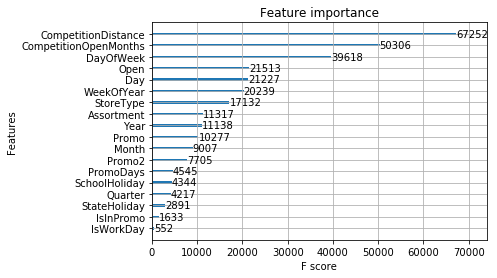

In [155]:
xgb.plot_importance(model_opt)

可以看到最重要的是竞争对手相关特征，其次是日期相关。

##### 鲁棒性

In [179]:
x_robust_test = x_valid[:1]
y_robust_test = y_valid[:1]
x_robust_test.iloc[0]

DayOfWeek                    5
Open                         1
Promo                        1
StateHoliday                 0
SchoolHoliday                1
StoreType                    3
Assortment                   1
CompetitionDistance       1270
Promo2                       0
Year                      2015
Quarter                      3
Month                        7
Day                         31
WeekOfYear                  31
IsWorkDay                 True
IsInPromo                False
PromoDays                    0
CompetitionOpenMonths       82
Name: 0, dtype: object

In [182]:
np.expm1(y_robust_test.iloc[0])

5262.9999999999973

In [180]:
np.expm1(model_opt.predict(x_robust_test)[0])

5510.4448

In [190]:
item = x_robust_test.iloc[0]
year_ = item.Year
item.Year = 0
x_robust_test.iloc[0] = item
print np.expm1(model_opt.predict(x_robust_test)[0])
x_robust_test.iloc[0].Year = year_

/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


5763.11


In [191]:
item = x_robust_test.iloc[0]
competitionDistance_ = item.CompetitionDistance
item.CompetitionDistance = -100
x_robust_test.iloc[0] = item
print np.expm1(model_opt.predict(x_robust_test)[0])
x_robust_test.iloc[0].CompetitionDistance = competitionDistance_

8143.42


In [192]:
item = x_robust_test.iloc[0]
dayOfWeek_ = item.DayOfWeek
item.DayOfWeek = 8
x_robust_test.iloc[0] = item
print np.expm1(model_opt.predict(x_robust_test)[0])
x_robust_test.iloc[0].DayOfWeek = dayOfWeek_

5692.17


#### 校正系数：校正整体偏差

观察下预测值和真值的分布情况。

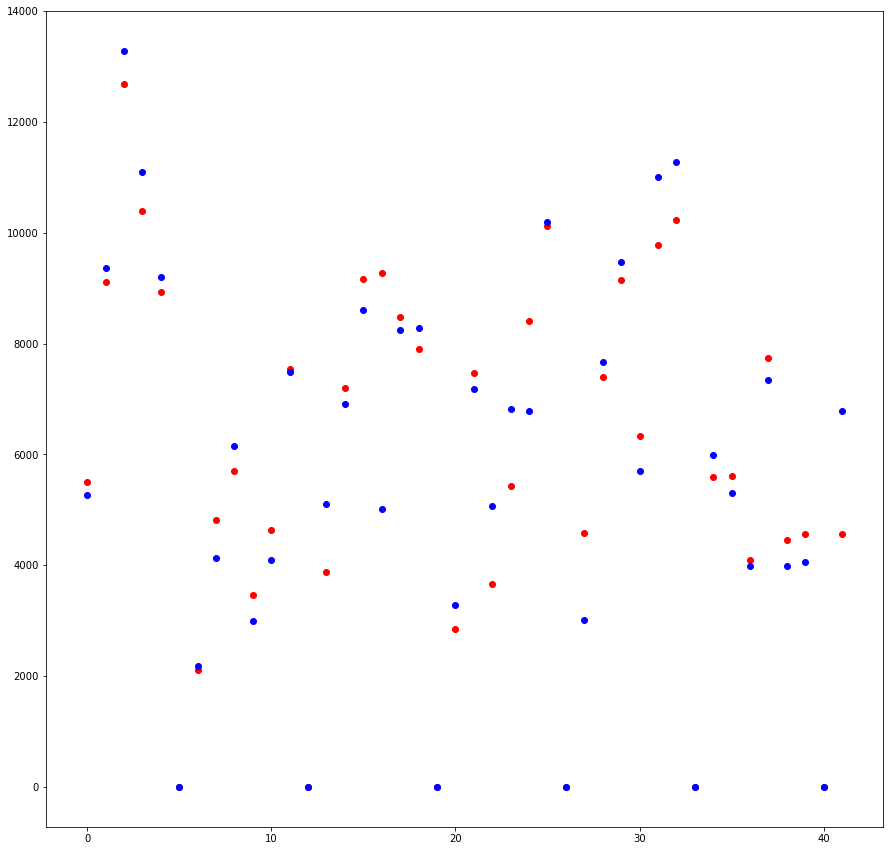

In [142]:
plt.figure(figsize=(15,15))
plt.scatter(range(len(np.expm1(pred_valid_opt)[::1115])), np.expm1(pred_valid_opt)[::1115], color='red')
plt.scatter(range(len(np.expm1(y_valid)[::1115])), np.expm1(y_valid)[::1115], color='blue')

In [143]:
np.mean(np.abs(np.expm1(pred_valid_opt)-np.expm1(y_valid)))

693.13059095674203

In [144]:
np.mean(np.expm1(pred_valid_opt)-np.expm1(y_valid))

-96.321284492246519

我们的数据整体上是低于真实值的，因此使用校正系数来整体校正偏差是合理的。

校正前：0.160303987825
校正后：
(0.995, 0.15503830432208604)


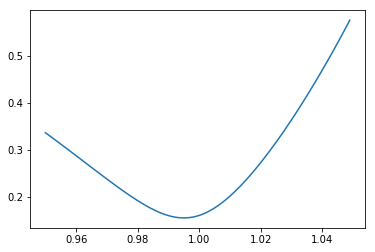

In [176]:
def get_fix_actor(pred_valid, y_valid):
    results = {}
    for actor in [0.950+i/1000. for i in range(100)]:
        results[actor]=rmspe(y_pred=np.expm1(pred_valid*actor), y_real=np.expm1(y_valid))
    return results, sorted(results.items(),key = lambda x:x[1],reverse = True)[-1]

print '校正前：'+str(rmspe(np.expm1(pred_valid_opt), np.expm1(y_valid)))
print '校正后：'
results, actor_score = get_fix_actor(pred_valid_opt, y_valid)
print actor_score
items = results.items()
items.sort()
plt.plot([k for k,v in items], [v for k,v in items])

恩恩，效果还不错，下降了0.005，最佳校正系数为0.995，看看加上校正系数后的数据与校正前、真实数据对比情况：

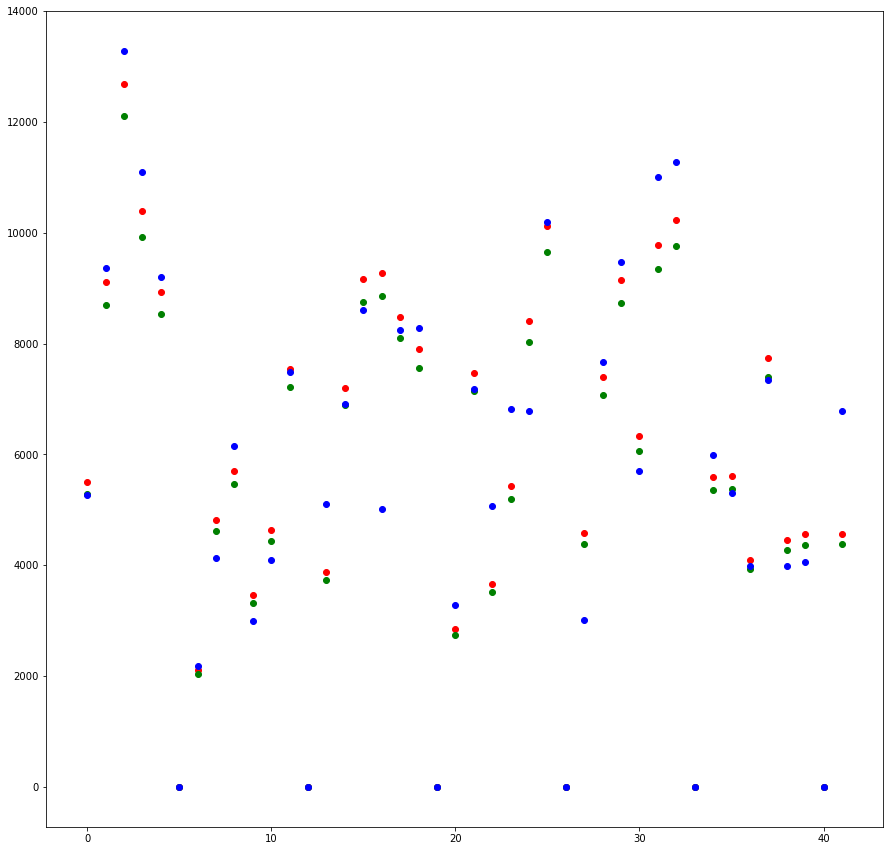

In [153]:
plt.figure(figsize=(15,15))
plt.scatter(range(len(np.expm1(pred_valid_opt)[::1115])), np.expm1(pred_valid_opt)[::1115], color='red')
plt.scatter(range(len(np.expm1(pred_valid_opt*actor_score[0])[::1115])), np.expm1(pred_valid_opt*actor_score[0])[::1115], color='green')
plt.scatter(range(len(np.expm1(y_valid)[::1115])), np.expm1(y_valid)[::1115], color='blue')

可以看到，相比较于红色的未经校正的点，绿色的校正后的点整体看更接近于实际数据。

#### 增量训练验证集数据到模型中

In [161]:
ps_opt = {
    'max_depth':7,
    'learning_rate':.05,
    'n_estimators':5000,
    'objective':'reg:linear',
    'booster':'gbtree',
    'gamma':grid_result2.best_params_['gamma'],
    'min_child_weight':1,
    'subsample':grid_result3.best_params_['subsample'],
    'colsample_bytree':grid_result3.best_params_['colsample_bytree'],
    'random_state':6,
    'silent':True,
}
model_opt_includevalid = train2(ps_opt, x_all, y_all, x_valid, y_valid)
model_opt_includevalid.save_model('/home/kael/projects/model/opt_includevalid.model')

XGBRegressor Train Start....
[0]	validation_0-rmse:7.29549
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.93256
[2]	validation_0-rmse:6.58805
[3]	validation_0-rmse:6.26192
[4]	validation_0-rmse:5.94966
[5]	validation_0-rmse:5.65401
[6]	validation_0-rmse:5.37346
[7]	validation_0-rmse:5.10682
[8]	validation_0-rmse:4.85341
[9]	validation_0-rmse:4.61236
[10]	validation_0-rmse:4.38368
[11]	validation_0-rmse:4.16673
[12]	validation_0-rmse:3.96058
[13]	validation_0-rmse:3.76572
[14]	validation_0-rmse:3.57975
[15]	validation_0-rmse:3.40337
[16]	validation_0-rmse:3.23557
[17]	validation_0-rmse:3.07619
[18]	validation_0-rmse:2.925
[19]	validation_0-rmse:2.78138
[20]	validation_0-rmse:2.64499
[21]	validation_0-rmse:2.5146
[22]	validation_0-rmse:2.39191
[23]	validation_0-rmse:2.27472
[24]	validation_0-rmse:2.16384
[25]	validation_0-rmse:2.05887
[26]	validation_0-rmse:1.95864
[27]	validation_0-rmse:1.86331
[28]	validation_0-rmse:1.77348
[29]	validation_0-r

[251]	validation_0-rmse:0.232528
[252]	validation_0-rmse:0.232223
[253]	validation_0-rmse:0.232178
[254]	validation_0-rmse:0.231952
[255]	validation_0-rmse:0.231834
[256]	validation_0-rmse:0.231718
[257]	validation_0-rmse:0.231521
[258]	validation_0-rmse:0.231173
[259]	validation_0-rmse:0.230989
[260]	validation_0-rmse:0.230322
[261]	validation_0-rmse:0.230205
[262]	validation_0-rmse:0.229978
[263]	validation_0-rmse:0.229393
[264]	validation_0-rmse:0.229072
[265]	validation_0-rmse:0.228946
[266]	validation_0-rmse:0.228906
[267]	validation_0-rmse:0.228665
[268]	validation_0-rmse:0.228432
[269]	validation_0-rmse:0.228402
[270]	validation_0-rmse:0.228297
[271]	validation_0-rmse:0.22826
[272]	validation_0-rmse:0.227838
[273]	validation_0-rmse:0.227471
[274]	validation_0-rmse:0.227253
[275]	validation_0-rmse:0.227216
[276]	validation_0-rmse:0.227182
[277]	validation_0-rmse:0.227016
[278]	validation_0-rmse:0.226788
[279]	validation_0-rmse:0.226541
[280]	validation_0-rmse:0.22619
[281]	valida

[500]	validation_0-rmse:0.188438
[501]	validation_0-rmse:0.188304
[502]	validation_0-rmse:0.188187
[503]	validation_0-rmse:0.188104
[504]	validation_0-rmse:0.188001
[505]	validation_0-rmse:0.18785
[506]	validation_0-rmse:0.187835
[507]	validation_0-rmse:0.187791
[508]	validation_0-rmse:0.187525
[509]	validation_0-rmse:0.187521
[510]	validation_0-rmse:0.187419
[511]	validation_0-rmse:0.187315
[512]	validation_0-rmse:0.187252
[513]	validation_0-rmse:0.187086
[514]	validation_0-rmse:0.186972
[515]	validation_0-rmse:0.186817
[516]	validation_0-rmse:0.186626
[517]	validation_0-rmse:0.186465
[518]	validation_0-rmse:0.186397
[519]	validation_0-rmse:0.186366
[520]	validation_0-rmse:0.186274
[521]	validation_0-rmse:0.186184
[522]	validation_0-rmse:0.186158
[523]	validation_0-rmse:0.18614
[524]	validation_0-rmse:0.18594
[525]	validation_0-rmse:0.185738
[526]	validation_0-rmse:0.185621
[527]	validation_0-rmse:0.185594
[528]	validation_0-rmse:0.185199
[529]	validation_0-rmse:0.185106
[530]	validat

[750]	validation_0-rmse:0.163022
[751]	validation_0-rmse:0.162951
[752]	validation_0-rmse:0.162884
[753]	validation_0-rmse:0.162779
[754]	validation_0-rmse:0.162754
[755]	validation_0-rmse:0.162706
[756]	validation_0-rmse:0.162649
[757]	validation_0-rmse:0.162572
[758]	validation_0-rmse:0.162557
[759]	validation_0-rmse:0.162467
[760]	validation_0-rmse:0.16245
[761]	validation_0-rmse:0.162276
[762]	validation_0-rmse:0.16221
[763]	validation_0-rmse:0.162116
[764]	validation_0-rmse:0.162092
[765]	validation_0-rmse:0.162043
[766]	validation_0-rmse:0.161892
[767]	validation_0-rmse:0.161797
[768]	validation_0-rmse:0.161747
[769]	validation_0-rmse:0.16173
[770]	validation_0-rmse:0.161654
[771]	validation_0-rmse:0.161578
[772]	validation_0-rmse:0.161548
[773]	validation_0-rmse:0.161495
[774]	validation_0-rmse:0.161394
[775]	validation_0-rmse:0.161309
[776]	validation_0-rmse:0.161287
[777]	validation_0-rmse:0.161123
[778]	validation_0-rmse:0.161075
[779]	validation_0-rmse:0.161003
[780]	validat

[1000]	validation_0-rmse:0.147233
[1001]	validation_0-rmse:0.147147
[1002]	validation_0-rmse:0.14709
[1003]	validation_0-rmse:0.147056
[1004]	validation_0-rmse:0.146934
[1005]	validation_0-rmse:0.14689
[1006]	validation_0-rmse:0.146816
[1007]	validation_0-rmse:0.146807
[1008]	validation_0-rmse:0.146732
[1009]	validation_0-rmse:0.146719
[1010]	validation_0-rmse:0.146697
[1011]	validation_0-rmse:0.146633
[1012]	validation_0-rmse:0.146553
[1013]	validation_0-rmse:0.146503
[1014]	validation_0-rmse:0.146425
[1015]	validation_0-rmse:0.146401
[1016]	validation_0-rmse:0.14636
[1017]	validation_0-rmse:0.14636
[1018]	validation_0-rmse:0.146287
[1019]	validation_0-rmse:0.146252
[1020]	validation_0-rmse:0.146224
[1021]	validation_0-rmse:0.146196
[1022]	validation_0-rmse:0.146168
[1023]	validation_0-rmse:0.146124
[1024]	validation_0-rmse:0.146064
[1025]	validation_0-rmse:0.146024
[1026]	validation_0-rmse:0.145976
[1027]	validation_0-rmse:0.145919
[1028]	validation_0-rmse:0.145893
[1029]	validation_

[1242]	validation_0-rmse:0.137474
[1243]	validation_0-rmse:0.137385
[1244]	validation_0-rmse:0.137336
[1245]	validation_0-rmse:0.137334
[1246]	validation_0-rmse:0.137329
[1247]	validation_0-rmse:0.137317
[1248]	validation_0-rmse:0.13731
[1249]	validation_0-rmse:0.137273
[1250]	validation_0-rmse:0.137247
[1251]	validation_0-rmse:0.137227
[1252]	validation_0-rmse:0.137206
[1253]	validation_0-rmse:0.137107
[1254]	validation_0-rmse:0.137029
[1255]	validation_0-rmse:0.136988
[1256]	validation_0-rmse:0.136961
[1257]	validation_0-rmse:0.136903
[1258]	validation_0-rmse:0.136891
[1259]	validation_0-rmse:0.136794
[1260]	validation_0-rmse:0.136756
[1261]	validation_0-rmse:0.136557
[1262]	validation_0-rmse:0.136518
[1263]	validation_0-rmse:0.136464
[1264]	validation_0-rmse:0.136418
[1265]	validation_0-rmse:0.13639
[1266]	validation_0-rmse:0.13632
[1267]	validation_0-rmse:0.136304
[1268]	validation_0-rmse:0.136276
[1269]	validation_0-rmse:0.136218
[1270]	validation_0-rmse:0.136185
[1271]	validation

[1484]	validation_0-rmse:0.129598
[1485]	validation_0-rmse:0.12956
[1486]	validation_0-rmse:0.12954
[1487]	validation_0-rmse:0.129479
[1488]	validation_0-rmse:0.129439
[1489]	validation_0-rmse:0.129422
[1490]	validation_0-rmse:0.129411
[1491]	validation_0-rmse:0.129389
[1492]	validation_0-rmse:0.12934
[1493]	validation_0-rmse:0.129303
[1494]	validation_0-rmse:0.129278
[1495]	validation_0-rmse:0.129222
[1496]	validation_0-rmse:0.12921
[1497]	validation_0-rmse:0.129171
[1498]	validation_0-rmse:0.129144
[1499]	validation_0-rmse:0.129138
[1500]	validation_0-rmse:0.129104
[1501]	validation_0-rmse:0.129001
[1502]	validation_0-rmse:0.128977
[1503]	validation_0-rmse:0.128926
[1504]	validation_0-rmse:0.128882
[1505]	validation_0-rmse:0.128853
[1506]	validation_0-rmse:0.128853
[1507]	validation_0-rmse:0.128841
[1508]	validation_0-rmse:0.128809
[1509]	validation_0-rmse:0.128799
[1510]	validation_0-rmse:0.128789
[1511]	validation_0-rmse:0.128767
[1512]	validation_0-rmse:0.128743
[1513]	validation_

[1726]	validation_0-rmse:0.123352
[1727]	validation_0-rmse:0.123266
[1728]	validation_0-rmse:0.123266
[1729]	validation_0-rmse:0.123264
[1730]	validation_0-rmse:0.123245
[1731]	validation_0-rmse:0.123217
[1732]	validation_0-rmse:0.123208
[1733]	validation_0-rmse:0.123204
[1734]	validation_0-rmse:0.12319
[1735]	validation_0-rmse:0.123184
[1736]	validation_0-rmse:0.123177
[1737]	validation_0-rmse:0.12317
[1738]	validation_0-rmse:0.123118
[1739]	validation_0-rmse:0.123113
[1740]	validation_0-rmse:0.123103
[1741]	validation_0-rmse:0.12309
[1742]	validation_0-rmse:0.123077
[1743]	validation_0-rmse:0.123062
[1744]	validation_0-rmse:0.123047
[1745]	validation_0-rmse:0.123026
[1746]	validation_0-rmse:0.123
[1747]	validation_0-rmse:0.122985
[1748]	validation_0-rmse:0.12294
[1749]	validation_0-rmse:0.122922
[1750]	validation_0-rmse:0.122899
[1751]	validation_0-rmse:0.122872
[1752]	validation_0-rmse:0.122862
[1753]	validation_0-rmse:0.122804
[1754]	validation_0-rmse:0.122775
[1755]	validation_0-r

[1968]	validation_0-rmse:0.1176
[1969]	validation_0-rmse:0.117578
[1970]	validation_0-rmse:0.117525
[1971]	validation_0-rmse:0.117505
[1972]	validation_0-rmse:0.117503
[1973]	validation_0-rmse:0.117499
[1974]	validation_0-rmse:0.117481
[1975]	validation_0-rmse:0.117456
[1976]	validation_0-rmse:0.117454
[1977]	validation_0-rmse:0.117445
[1978]	validation_0-rmse:0.117436
[1979]	validation_0-rmse:0.117412
[1980]	validation_0-rmse:0.117406
[1981]	validation_0-rmse:0.117399
[1982]	validation_0-rmse:0.11734
[1983]	validation_0-rmse:0.117317
[1984]	validation_0-rmse:0.117306
[1985]	validation_0-rmse:0.1173
[1986]	validation_0-rmse:0.117285
[1987]	validation_0-rmse:0.117246
[1988]	validation_0-rmse:0.11724
[1989]	validation_0-rmse:0.117223
[1990]	validation_0-rmse:0.117205
[1991]	validation_0-rmse:0.117199
[1992]	validation_0-rmse:0.11719
[1993]	validation_0-rmse:0.117186
[1994]	validation_0-rmse:0.117179
[1995]	validation_0-rmse:0.117131
[1996]	validation_0-rmse:0.117112
[1997]	validation_0-r

[2211]	validation_0-rmse:0.113664
[2212]	validation_0-rmse:0.113645
[2213]	validation_0-rmse:0.113629
[2214]	validation_0-rmse:0.113604
[2215]	validation_0-rmse:0.113576
[2216]	validation_0-rmse:0.113568
[2217]	validation_0-rmse:0.113559
[2218]	validation_0-rmse:0.113557
[2219]	validation_0-rmse:0.113549
[2220]	validation_0-rmse:0.11352
[2221]	validation_0-rmse:0.113506
[2222]	validation_0-rmse:0.113465
[2223]	validation_0-rmse:0.113454
[2224]	validation_0-rmse:0.113434
[2225]	validation_0-rmse:0.113404
[2226]	validation_0-rmse:0.1134
[2227]	validation_0-rmse:0.11339
[2228]	validation_0-rmse:0.113381
[2229]	validation_0-rmse:0.113379
[2230]	validation_0-rmse:0.113372
[2231]	validation_0-rmse:0.113368
[2232]	validation_0-rmse:0.113365
[2233]	validation_0-rmse:0.113359
[2234]	validation_0-rmse:0.113346
[2235]	validation_0-rmse:0.113331
[2236]	validation_0-rmse:0.113312
[2237]	validation_0-rmse:0.113308
[2238]	validation_0-rmse:0.113298
[2239]	validation_0-rmse:0.113255
[2240]	validation_

[2453]	validation_0-rmse:0.110445
[2454]	validation_0-rmse:0.110435
[2455]	validation_0-rmse:0.11044
[2456]	validation_0-rmse:0.110434
[2457]	validation_0-rmse:0.110425
[2458]	validation_0-rmse:0.110415
[2459]	validation_0-rmse:0.110408
[2460]	validation_0-rmse:0.110401
[2461]	validation_0-rmse:0.1104
[2462]	validation_0-rmse:0.110399
[2463]	validation_0-rmse:0.110383
[2464]	validation_0-rmse:0.110371
[2465]	validation_0-rmse:0.110362
[2466]	validation_0-rmse:0.110354
[2467]	validation_0-rmse:0.110346
[2468]	validation_0-rmse:0.11034
[2469]	validation_0-rmse:0.110326
[2470]	validation_0-rmse:0.110323
[2471]	validation_0-rmse:0.11032
[2472]	validation_0-rmse:0.110312
[2473]	validation_0-rmse:0.110303
[2474]	validation_0-rmse:0.110302
[2475]	validation_0-rmse:0.110288
[2476]	validation_0-rmse:0.110287
[2477]	validation_0-rmse:0.110268
[2478]	validation_0-rmse:0.110258
[2479]	validation_0-rmse:0.110253
[2480]	validation_0-rmse:0.110238
[2481]	validation_0-rmse:0.110233
[2482]	validation_0

[2695]	validation_0-rmse:0.107829
[2696]	validation_0-rmse:0.107822
[2697]	validation_0-rmse:0.107813
[2698]	validation_0-rmse:0.107806
[2699]	validation_0-rmse:0.107797
[2700]	validation_0-rmse:0.107782
[2701]	validation_0-rmse:0.10777
[2702]	validation_0-rmse:0.107767
[2703]	validation_0-rmse:0.107731
[2704]	validation_0-rmse:0.10773
[2705]	validation_0-rmse:0.107711
[2706]	validation_0-rmse:0.107707
[2707]	validation_0-rmse:0.107701
[2708]	validation_0-rmse:0.107693
[2709]	validation_0-rmse:0.107687
[2710]	validation_0-rmse:0.107667
[2711]	validation_0-rmse:0.107643
[2712]	validation_0-rmse:0.10764
[2713]	validation_0-rmse:0.107614
[2714]	validation_0-rmse:0.107602
[2715]	validation_0-rmse:0.107598
[2716]	validation_0-rmse:0.107574
[2717]	validation_0-rmse:0.107567
[2718]	validation_0-rmse:0.107562
[2719]	validation_0-rmse:0.107554
[2720]	validation_0-rmse:0.10755
[2721]	validation_0-rmse:0.107546
[2722]	validation_0-rmse:0.107543
[2723]	validation_0-rmse:0.10754
[2724]	validation_0

[2937]	validation_0-rmse:0.105128
[2938]	validation_0-rmse:0.105117
[2939]	validation_0-rmse:0.105097
[2940]	validation_0-rmse:0.105078
[2941]	validation_0-rmse:0.105065
[2942]	validation_0-rmse:0.10506
[2943]	validation_0-rmse:0.105045
[2944]	validation_0-rmse:0.105043
[2945]	validation_0-rmse:0.105037
[2946]	validation_0-rmse:0.105033
[2947]	validation_0-rmse:0.105028
[2948]	validation_0-rmse:0.105007
[2949]	validation_0-rmse:0.104992
[2950]	validation_0-rmse:0.104968
[2951]	validation_0-rmse:0.104965
[2952]	validation_0-rmse:0.10496
[2953]	validation_0-rmse:0.104903
[2954]	validation_0-rmse:0.104902
[2955]	validation_0-rmse:0.104893
[2956]	validation_0-rmse:0.104864
[2957]	validation_0-rmse:0.104862
[2958]	validation_0-rmse:0.104858
[2959]	validation_0-rmse:0.104853
[2960]	validation_0-rmse:0.104819
[2961]	validation_0-rmse:0.104797
[2962]	validation_0-rmse:0.104796
[2963]	validation_0-rmse:0.104784
[2964]	validation_0-rmse:0.104769
[2965]	validation_0-rmse:0.10475
[2966]	validation

[3179]	validation_0-rmse:0.102733
[3180]	validation_0-rmse:0.102713
[3181]	validation_0-rmse:0.102711
[3182]	validation_0-rmse:0.102708
[3183]	validation_0-rmse:0.102693
[3184]	validation_0-rmse:0.102675
[3185]	validation_0-rmse:0.102667
[3186]	validation_0-rmse:0.102663
[3187]	validation_0-rmse:0.102655
[3188]	validation_0-rmse:0.102653
[3189]	validation_0-rmse:0.102649
[3190]	validation_0-rmse:0.102642
[3191]	validation_0-rmse:0.10264
[3192]	validation_0-rmse:0.102635
[3193]	validation_0-rmse:0.102627
[3194]	validation_0-rmse:0.102627
[3195]	validation_0-rmse:0.102621
[3196]	validation_0-rmse:0.102611
[3197]	validation_0-rmse:0.10261
[3198]	validation_0-rmse:0.102607
[3199]	validation_0-rmse:0.102598
[3200]	validation_0-rmse:0.102581
[3201]	validation_0-rmse:0.102576
[3202]	validation_0-rmse:0.102559
[3203]	validation_0-rmse:0.102558
[3204]	validation_0-rmse:0.102556
[3205]	validation_0-rmse:0.102556
[3206]	validation_0-rmse:0.102554
[3207]	validation_0-rmse:0.102544
[3208]	validatio

[3421]	validation_0-rmse:0.100741
[3422]	validation_0-rmse:0.100735
[3423]	validation_0-rmse:0.100728
[3424]	validation_0-rmse:0.100721
[3425]	validation_0-rmse:0.10072
[3426]	validation_0-rmse:0.100703
[3427]	validation_0-rmse:0.100691
[3428]	validation_0-rmse:0.100685
[3429]	validation_0-rmse:0.100675
[3430]	validation_0-rmse:0.100672
[3431]	validation_0-rmse:0.100669
[3432]	validation_0-rmse:0.100669
[3433]	validation_0-rmse:0.100661
[3434]	validation_0-rmse:0.100634
[3435]	validation_0-rmse:0.100624
[3436]	validation_0-rmse:0.10061
[3437]	validation_0-rmse:0.100599
[3438]	validation_0-rmse:0.100587
[3439]	validation_0-rmse:0.100575
[3440]	validation_0-rmse:0.100569
[3441]	validation_0-rmse:0.100563
[3442]	validation_0-rmse:0.100557
[3443]	validation_0-rmse:0.100545
[3444]	validation_0-rmse:0.100543
[3445]	validation_0-rmse:0.100534
[3446]	validation_0-rmse:0.100531
[3447]	validation_0-rmse:0.100523
[3448]	validation_0-rmse:0.1005
[3449]	validation_0-rmse:0.100487
[3450]	validation_

[3663]	validation_0-rmse:0.098904
[3664]	validation_0-rmse:0.098889
[3665]	validation_0-rmse:0.098888
[3666]	validation_0-rmse:0.098884
[3667]	validation_0-rmse:0.098878
[3668]	validation_0-rmse:0.098876
[3669]	validation_0-rmse:0.098868
[3670]	validation_0-rmse:0.098865
[3671]	validation_0-rmse:0.09886
[3672]	validation_0-rmse:0.09884
[3673]	validation_0-rmse:0.098838
[3674]	validation_0-rmse:0.098841
[3675]	validation_0-rmse:0.098822
[3676]	validation_0-rmse:0.098818
[3677]	validation_0-rmse:0.098801
[3678]	validation_0-rmse:0.098788
[3679]	validation_0-rmse:0.098782
[3680]	validation_0-rmse:0.098774
[3681]	validation_0-rmse:0.098766
[3682]	validation_0-rmse:0.098765
[3683]	validation_0-rmse:0.098765
[3684]	validation_0-rmse:0.098762
[3685]	validation_0-rmse:0.098762
[3686]	validation_0-rmse:0.098754
[3687]	validation_0-rmse:0.098746
[3688]	validation_0-rmse:0.098737
[3689]	validation_0-rmse:0.098734
[3690]	validation_0-rmse:0.098729
[3691]	validation_0-rmse:0.098727
[3692]	validatio

[3905]	validation_0-rmse:0.097299
[3906]	validation_0-rmse:0.097297
[3907]	validation_0-rmse:0.097283
[3908]	validation_0-rmse:0.097275
[3909]	validation_0-rmse:0.097255
[3910]	validation_0-rmse:0.09725
[3911]	validation_0-rmse:0.097247
[3912]	validation_0-rmse:0.097245
[3913]	validation_0-rmse:0.09724
[3914]	validation_0-rmse:0.097243
[3915]	validation_0-rmse:0.097242
[3916]	validation_0-rmse:0.09724
[3917]	validation_0-rmse:0.097227
[3918]	validation_0-rmse:0.097223
[3919]	validation_0-rmse:0.09722
[3920]	validation_0-rmse:0.097215
[3921]	validation_0-rmse:0.097203
[3922]	validation_0-rmse:0.097203
[3923]	validation_0-rmse:0.097201
[3924]	validation_0-rmse:0.097199
[3925]	validation_0-rmse:0.097182
[3926]	validation_0-rmse:0.097174
[3927]	validation_0-rmse:0.097171
[3928]	validation_0-rmse:0.097168
[3929]	validation_0-rmse:0.097165
[3930]	validation_0-rmse:0.097162
[3931]	validation_0-rmse:0.097149
[3932]	validation_0-rmse:0.097141
[3933]	validation_0-rmse:0.097139
[3934]	validation_

[4147]	validation_0-rmse:0.095914
[4148]	validation_0-rmse:0.095912
[4149]	validation_0-rmse:0.095903
[4150]	validation_0-rmse:0.095899
[4151]	validation_0-rmse:0.095898
[4152]	validation_0-rmse:0.095897
[4153]	validation_0-rmse:0.095893
[4154]	validation_0-rmse:0.095888
[4155]	validation_0-rmse:0.095884
[4156]	validation_0-rmse:0.095884
[4157]	validation_0-rmse:0.09588
[4158]	validation_0-rmse:0.095874
[4159]	validation_0-rmse:0.095871
[4160]	validation_0-rmse:0.095865
[4161]	validation_0-rmse:0.095861
[4162]	validation_0-rmse:0.095855
[4163]	validation_0-rmse:0.095854
[4164]	validation_0-rmse:0.095842
[4165]	validation_0-rmse:0.095838
[4166]	validation_0-rmse:0.095833
[4167]	validation_0-rmse:0.09583
[4168]	validation_0-rmse:0.095823
[4169]	validation_0-rmse:0.09582
[4170]	validation_0-rmse:0.095819
[4171]	validation_0-rmse:0.095817
[4172]	validation_0-rmse:0.095816
[4173]	validation_0-rmse:0.095802
[4174]	validation_0-rmse:0.095796
[4175]	validation_0-rmse:0.095793
[4176]	validation

[4389]	validation_0-rmse:0.094657
[4390]	validation_0-rmse:0.094653
[4391]	validation_0-rmse:0.094649
[4392]	validation_0-rmse:0.094645
[4393]	validation_0-rmse:0.094643
[4394]	validation_0-rmse:0.094634
[4395]	validation_0-rmse:0.094626
[4396]	validation_0-rmse:0.094623
[4397]	validation_0-rmse:0.094617
[4398]	validation_0-rmse:0.094615
[4399]	validation_0-rmse:0.094606
[4400]	validation_0-rmse:0.094595
[4401]	validation_0-rmse:0.094591
[4402]	validation_0-rmse:0.094588
[4403]	validation_0-rmse:0.094584
[4404]	validation_0-rmse:0.094582
[4405]	validation_0-rmse:0.094573
[4406]	validation_0-rmse:0.094571
[4407]	validation_0-rmse:0.09457
[4408]	validation_0-rmse:0.094569
[4409]	validation_0-rmse:0.09456
[4410]	validation_0-rmse:0.094553
[4411]	validation_0-rmse:0.094548
[4412]	validation_0-rmse:0.094535
[4413]	validation_0-rmse:0.094516
[4414]	validation_0-rmse:0.094512
[4415]	validation_0-rmse:0.094509
[4416]	validation_0-rmse:0.094516
[4417]	validation_0-rmse:0.094514
[4418]	validatio

[4631]	validation_0-rmse:0.09342
[4632]	validation_0-rmse:0.093417
[4633]	validation_0-rmse:0.093413
[4634]	validation_0-rmse:0.093408
[4635]	validation_0-rmse:0.093408
[4636]	validation_0-rmse:0.093405
[4637]	validation_0-rmse:0.093403
[4638]	validation_0-rmse:0.093402
[4639]	validation_0-rmse:0.0934
[4640]	validation_0-rmse:0.093404
[4641]	validation_0-rmse:0.093391
[4642]	validation_0-rmse:0.093382
[4643]	validation_0-rmse:0.093378
[4644]	validation_0-rmse:0.093372
[4645]	validation_0-rmse:0.09337
[4646]	validation_0-rmse:0.093367
[4647]	validation_0-rmse:0.093361
[4648]	validation_0-rmse:0.093354
[4649]	validation_0-rmse:0.093347
[4650]	validation_0-rmse:0.093346
[4651]	validation_0-rmse:0.093345
[4652]	validation_0-rmse:0.093339
[4653]	validation_0-rmse:0.093337
[4654]	validation_0-rmse:0.093333
[4655]	validation_0-rmse:0.093331
[4656]	validation_0-rmse:0.093326
[4657]	validation_0-rmse:0.093318
[4658]	validation_0-rmse:0.093317
[4659]	validation_0-rmse:0.093314
[4660]	validation_

[4873]	validation_0-rmse:0.09235
[4874]	validation_0-rmse:0.092346
[4875]	validation_0-rmse:0.092343
[4876]	validation_0-rmse:0.092341
[4877]	validation_0-rmse:0.09234
[4878]	validation_0-rmse:0.092339
[4879]	validation_0-rmse:0.092337
[4880]	validation_0-rmse:0.092334
[4881]	validation_0-rmse:0.092327
[4882]	validation_0-rmse:0.092322
[4883]	validation_0-rmse:0.092321
[4884]	validation_0-rmse:0.09232
[4885]	validation_0-rmse:0.092315
[4886]	validation_0-rmse:0.092311
[4887]	validation_0-rmse:0.092306
[4888]	validation_0-rmse:0.092295
[4889]	validation_0-rmse:0.09228
[4890]	validation_0-rmse:0.092269
[4891]	validation_0-rmse:0.092267
[4892]	validation_0-rmse:0.092267
[4893]	validation_0-rmse:0.092264
[4894]	validation_0-rmse:0.092256
[4895]	validation_0-rmse:0.092255
[4896]	validation_0-rmse:0.092253
[4897]	validation_0-rmse:0.092254
[4898]	validation_0-rmse:0.092249
[4899]	validation_0-rmse:0.092248
[4900]	validation_0-rmse:0.092243
[4901]	validation_0-rmse:0.09224
[4902]	validation_0

## kaggle上对比

In [ ]:
test_id = test_all.Id
test_all.drop(['Id'], axis=1, inplace=True)

### 基准模型

In [165]:
pd.DataFrame({'Id':test_id, 'Sales':pd.Series([pred_base]*len(test_id))}).to_csv('submission_baseline.csv', index=False)

#### kaggle反馈

![截图](image/基准模型.png)

### XGB模型

In [169]:
pred_test_xgb = np.expm1(model_first.predict(test_all))
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb}).to_csv('submission_xgb.csv', index=False)

#### kaggle反馈

![截图](image/XGBoost.png)

### XGB模型&参数优化

In [171]:
pred_test_xgb_opt = np.expm1(model_opt.predict(test_all))
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb_opt}).to_csv('submission_xgb_opt.csv', index=False)

#### kaggle反馈

![截图](image/参数优化.png)

### XGB模型&参数优化&校正系数

In [172]:
pred_test_xgb_opt_actor = np.expm1(model_opt.predict(test_all)*actor_score[0])
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb_opt_actor}).to_csv('submission_xgb_opt_actor.csv', index=False)

#### kaggle反馈

![截图](image/校正系数.png)

### XGB模型&完整训练集

In [173]:
pred_test_xgb_opt_actor_incluevalid = np.expm1(model_opt_includevalid.predict(test_all)*actor_score[0])
pd.DataFrame({'Id':test_id, 'Sales':pred_test_xgb_opt_actor_incluevalid}).to_csv('submission_xgb_opt_actor_inc.csv', index=False)

#### kaggle反馈

![截图](image/全数据训练.png)

## 结论

能够看到，XGBoost模型经过参数优化、校正系数、补充全数据训练后，在Kaggle的得分上取得以下进展：
* private:从0.18316提升到0.16027
* public:从0.17733提升到0.14474

可以看到，优化还是提到了很大的效果的。